In [1]:
%load_ext autoreload
%autoreload 2

# What is this notebook?
This notebook complements my master thesis titled "Policy Evaluation In Distributional Reinforcement Learning"
and demonstrates the viability and quality of the findings - namely the effect of different kinds of projections along with parameter algorithms on the quality of the return distribution function estimate obtained after generating a number of iterates in the extended DDP framework. Moreover results are compared with regards to their (space) runtime-complexity.

Goal: Evaluate space-time complexity and performance of algorithms presented in thesis.

# A word of caution
Some functions in this codebase are decorated with the njit decorator from the numba package.
This results in a just-in-time compilation of these functions, leading to very long execution times on their first call.
When designing the experiments and using the execution time as a proxy for algorithm perfomance, this must be taken into account.

# Design of Experiments
- the iteration number for algorithms is chosen such that the run time $T(n) \leq 45$ Sec
- the iteration number for the *bernoulli case* is set sucht that T(n) \leq 15
  due to the simplicty of the problem

- to take into account the jit step, we execute each algorithm for 2 iterations beforehand

- Monte Carlo Methods: Traj len 30

# Imports

In [38]:
from copy import deepcopy
import functools
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import time


from src.random_variables import RV, DiscreteRV, ContinuousRV

from src.drl_primitives import (
    ReturnDistributionFunction,
    RewardDistributionCollection,
    extended_metric,
    wasserstein_beta,
    birnb_orl_avg_dist_beta
    )

from src.ddp import (dbo, ddp)

from src.projections import QuantileProjection, RandomProjection, GridValueProjection

from src.param_algorithms import (
    q_proj_poly_poly,
    SizeFun,
    DecayFun,
    combine_to_param_algo,
    transform_to_param_algo,
    param_algo_from_size_fun,
    algo_cdf_1
    )

from src.monte_carlo import monte_carlo_eval
from src.utils import dkw_bounds

# Plain DBO Iteration vs Extended DDP vs Monte Carlo Simulation for two Environments
We investigate the space-runtime-performance tradeoff in 2 different settings.
In this section, the projections are chose as $\Pi_{\text{in}} = \Pi_{\text{out}} = \Pi_{\text{q}}$ with
size functions $M_{\text{in}}(n) \coloneqq n^2$ and $M_{\text{out}}(n) \coloneqq n^3$.

# Bernoulli MDP
Prior to the above investigation, we introduce some easy example to show parts of the implementation.

This example is in the notebook for demo purposes only and will not be included in the evaluations due to it being too simple.
Nontheless, playing around with the code will already illustrate the issues intrisic to the iterated application of the DBO without projections.
Setting the number of iterations in this example >> 25 will lead to tremendous runtimes of the iterated DBO application as well as memory consumption that exceeds
the RAM of most consumer devices.
Moreover, solely setting the iteration number to 20 (in which case the computation of the iterated DBO application finish rather quickly), the CDF evaluation
at a large number (~1000) of locations becomes difficult.

An back-of-the-envelope calculation indicates that in the bernoulli setting, after 20 iterations, the distribution has approx 2**20 ~ 1 000 000 atoms and the same number of weights.
Evaluating the CDF at 1000 locations, considerung that every value if a double-precision floating point value, this amounts to approx 125 GBytes of data (if vectorized in one big chunk) that
has to be wrangled for the CDF evaluation.

In [2]:
# calc for above text
2**20 * 64 * 1000 / 1024**3 * 2


125.0

Initial Return Distr.: (array([0]), array([1]))


Text(0.5, 1.0, 'Init. Return Distribution Function Estimate')

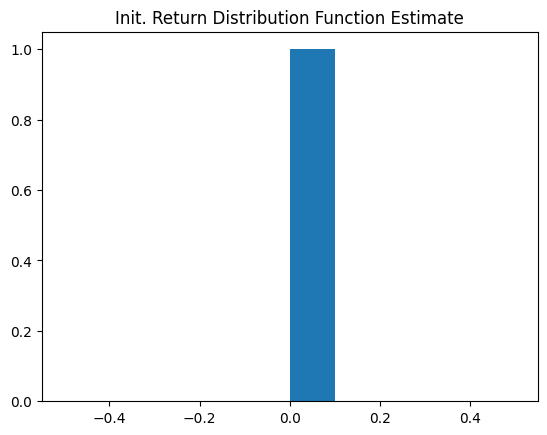

In [4]:
from src.sample_envs import bernoulli_env

# intiial return distribution function estimate
b_states = bernoulli_env.mdp.states
b_ret_est: ReturnDistributionFunction = ReturnDistributionFunction(
    states=bernoulli_env.mdp.states,
    distributions=[DiscreteRV(xk=np.array([0]), pk=np.array([1]))]
)
b_ret_est_cp = deepcopy(b_ret_est)
b_ret_est_warmup = deepcopy(b_ret_est)
print(f"Initial Return Distr.: {b_ret_est[b_states[0]].distr()}")
# plotting initial return distribution estimate
plt.hist(b_ret_est[b_states[0]].xk,
         bins=None,
         # bins=b_ret_est[b_states[0]].size*20,
         weights=b_ret_est[b_states[0]].pk,
         histtype="bar")
plt.title("Init. Return Distribution Function Estimate")

### Plain DBO application


In [23]:
num_iterations: int = 10 

In [ ]:
b_ret_est_cp = deepcopy(b_ret_est)
b_ret_est_warmup = deepcopy(b_ret_est)

# warm up
for _ in range(2):
    dbo(bernoulli_env.mdp, b_ret_est_warmup)

# max iteration in under 15 seconds: 26
b_ret_est = deepcopy(b_ret_est_cp)
start = time.time()
for i in range(num_iterations):
    dbo(bernoulli_env.mdp, b_ret_est)  
    # print(i+1)
stop = time.time()
print(stop-start)

In [ ]:
# Number of atoms of estimate
print(f"# atoms of return distr estimate: {b_ret_est[b_states[0]].xk.size}")
# This is exactly 2**26 atoms, i.e. 2**(#iterations) atoms
b_ret_est[b_states[0]].xk.size == 2**num_iterations

In [26]:
# Plotting the return distribution function estimate's CDF 
# against the actual return distr function CDF
support = (b_ret_est[b_states[0]].xk[0], b_ret_est[b_states[0]].xk[-1])
cdf_evals_x = np.linspace(support[0], support[1], 1000)
cdf_evals_y = b_ret_est[b_states[0]].cdf(cdf_evals_x)

In [ ]:
gt_return_distr_function = sp.uniform(0,2)

plt.title("CDF of Estimate vs Ground Truth")
plt.plot(cdf_evals_x, cdf_evals_y, label="Estimate CDF")
plt.plot(cdf_evals_x, 
         gt_return_distr_function.cdf(cdf_evals_x)+0.01,
         label="Ground Truth CDF")
plt.legend()

### Extended DDP

- choose $\Pi_{\text{in}} = \Pi_{\text{rand}} $ and $\Pi_{\text{out}} = \Pi_{\text{q}}$
- as size functions choose $M_{\text{in}}(n) \coloneqq n^4$ and $M_{\text{out}}(n) \coloneqq 2^n$

#### Defining The Parameter Algorithm


In [17]:
# define the size functions 
import functools
M_in = functools.partial(SizeFun.POLY, 4)  # exponent=4, must pass as positional arg
M_out = functools.partial(SizeFun.EXP, 2)  # base=2, must pass as positional arg

print(f"M_in(3) = {M_in(x=3)}")
print(f"M_out(3) = {M_out(x=3)}")

M_in(3) = 81
M_out(3) = 8


In [18]:
# create algorithms for one parameter each
algo_in = transform_to_param_algo(param_algo_from_size_fun, size_fun=M_in)
algo_out = transform_to_param_algo(param_algo_from_size_fun, size_fun=M_out, distr_coll=None)  
# this is important, always pass distr_coll=None for the outer collection


In [23]:
# create param algo by combining the algorithms for the inner and outer parameter
qrand_poly_exp = combine_to_param_algo(algo_in, algo_out)

#### Running Extended DDP With The Choices Above

In [20]:
# reset b_ret_est_cp
b_ret_est = b_ret_est_cp

# warmup
for i in range(1, 3):
    b_ret_est = ddp(
        bernoulli_env.mdp,
        QuantileProjection,
        RandomProjection,
        qrand_poly_exp,
        b_ret_est,
        bernoulli_env.mdp.rewards,
        i)
print("Warmup complete")
# reset
b_ret_est = b_ret_est_cp
assert b_ret_est[b_states[0]].xk.size == 1, "return distr function not reset correctly."

start_time = time.time()
for i in range(1, 10):
    b_ret_est = ddp(
        bernoulli_env.mdp,
        QuantileProjection,
        RandomProjection,
        qrand_poly_exp,
        b_ret_est_cp,
        bernoulli_env.mdp.rewards,
        i)
    print(f"Completed iteration {i}")
stop_time = time.time()
print(f"Time passed: {stop_time - start_time}")

/Users/Andy/.local/share/virtualenvs/master_thesis-8HvZwd8T/lib/python3.9/site-packages/numba/core/lowering.py:112: NumbaDebugInfoWarning: Could not find source for function: <function __numba_array_expr_0x138892f10 at 0x138ac08b0>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/Users/Andy/.local/share/virtualenvs/master_thesis-8HvZwd8T/lib/python3.9/site-packages/numba/core/lowering.py:112: NumbaDebugInfoWarning: Could not find source for function: <function __numba_array_expr_0x139118e20 at 0x138cefdc0>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))


Warmup complete
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Time passed: 0.007876157760620117


In [21]:
support = (b_ret_est[b_states[0]].xk[0], b_ret_est[b_states[0]].xk[-1])
cdf_evals_x = np.linspace(support[0], support[1], 1000)
cdf_evals_y = b_ret_est[b_states[0]].cdf(cdf_evals_x)

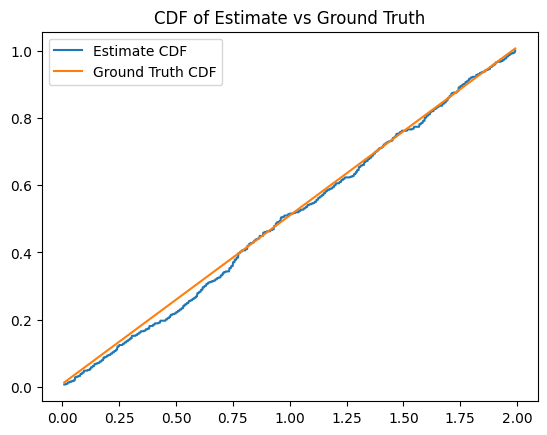

In [22]:
gt_return_distr_function = sp.uniform(0,2)

plt.title("CDF of Estimate vs Ground Truth")
plt.plot(cdf_evals_x, cdf_evals_y, label="Estimate CDF")
plt.plot(cdf_evals_x, 
         gt_return_distr_function.cdf(cdf_evals_x)+0.01,
         label="Ground Truth CDF")
plt.legend()

### Monte Carlo

In [33]:
b_ret_est = deepcopy(b_ret_est_cp)
b_ret_est_mc = monte_carlo_eval(bernoulli_env.mdp, trajectory_len=30, num_trajectories=2000)

In [ ]:
plt.title("CDF of MC estimate and ground truth")
confidence_level = 0.95
xvals = np.linspace(0, 2, 1000)
# unif_02 = sp.uniform(0,2)
mc_bernoulli = b_ret_est_mc[0]
mc_bernoulli_cdf = mc_bernoulli.get_cdf()
y_cdf, lb, ub = dkw_bounds(gt_return_distr_function.cdf, xvals, 2000, confidence_level)
plt.plot(xvals, y_cdf, label="cdf")
plt.plot(xvals, lb, label=f"dkw lower bound @ {confidence_level} conf.")
plt.plot(xvals, ub, label=f"dkw upper bound @ {confidence_level}conf.")
plt.plot(xvals, mc_bernoulli.cdf(xvals), label="MC approximation")
plt.legend()

# Cyclical MDP with rewards ~ $Norm(\mu_i, \sigma^2_i)$

In [25]:
# Caution: name might be misleading, this is the cyclical env from paper by Gerstenberg et al.
# with Norm(mu, sigma^2) rewards
from src.sample_envs import cyclical_env
from src.sample_envs import cyclical_real_return_distr_fun as gt_n_ret_distr_fun
n_ret_est = ReturnDistributionFunction(
    states=cyclical_env.mdp.states,
    distributions=[DiscreteRV(xk=np.array([0]), pk=np.array([1])) 
                   for _ in cyclical_env.mdp.states]
)

n_ret_est_cp = deepcopy(n_ret_est)
n_mdp = cyclical_env.mdp
n_states = n_mdp.states
# ground truth return distribitutions for the three states
gt_n0 = sp.norm(loc=0.761, scale=np.sqrt(2.380))
gt_n1 = sp.norm(loc=5.373, scale=np.sqrt(2.816))
gt_n2 = sp.norm(loc=0.533, scale=np.sqrt(1.666))

## Plain DBO application
Note: The dbo application needs the reward distributions to be discrete / finitely represented. 
An alterative would be to directly calculate CDF of the distribution collection returned after a single application of the DBO which can be analytically determined.
This might be implemented in the future.

In [9]:
ks = list(cyclical_env.mdp.rewards.rewards.keys())
discretized_rewards = RewardDistributionCollection(
    ks,
    [cyclical_env.mdp.rewards[k].empirical(50) for k in ks]
    )

In [10]:
n_ret_est = deepcopy(n_ret_est_cp)
# warmup
for i in range(3):
    dbo(cyclical_env.mdp, n_ret_est, reward_distr_coll=discretized_rewards)
    print(f"Iteration {i} completed.")

# actual
n_ret_est = deepcopy(n_ret_est_cp)

start = time.time()
for i in range(4):
    dbo(cyclical_env.mdp, n_ret_est, reward_distr_coll=discretized_rewards)
    print(f"Iteration {i} completed.")
stop = time.time()
print(stop-start)
# for 4 iterations takes approx 1 min 40 sec --> 3 iterations make sense

Iteration 0 completed.
Iteration 1 completed.
Iteration 2 completed.
Iteration 0 completed.
Iteration 1 completed.
Iteration 2 completed.
Iteration 3 completed.
4.939446926116943


Memory usage of CDF evaluation:                     372.4849224090576 GB.
Memory usage of CDF evaluation:                     372.4822402000427 GB.
Memory usage of CDF evaluation:                     372.4812865257263 GB.


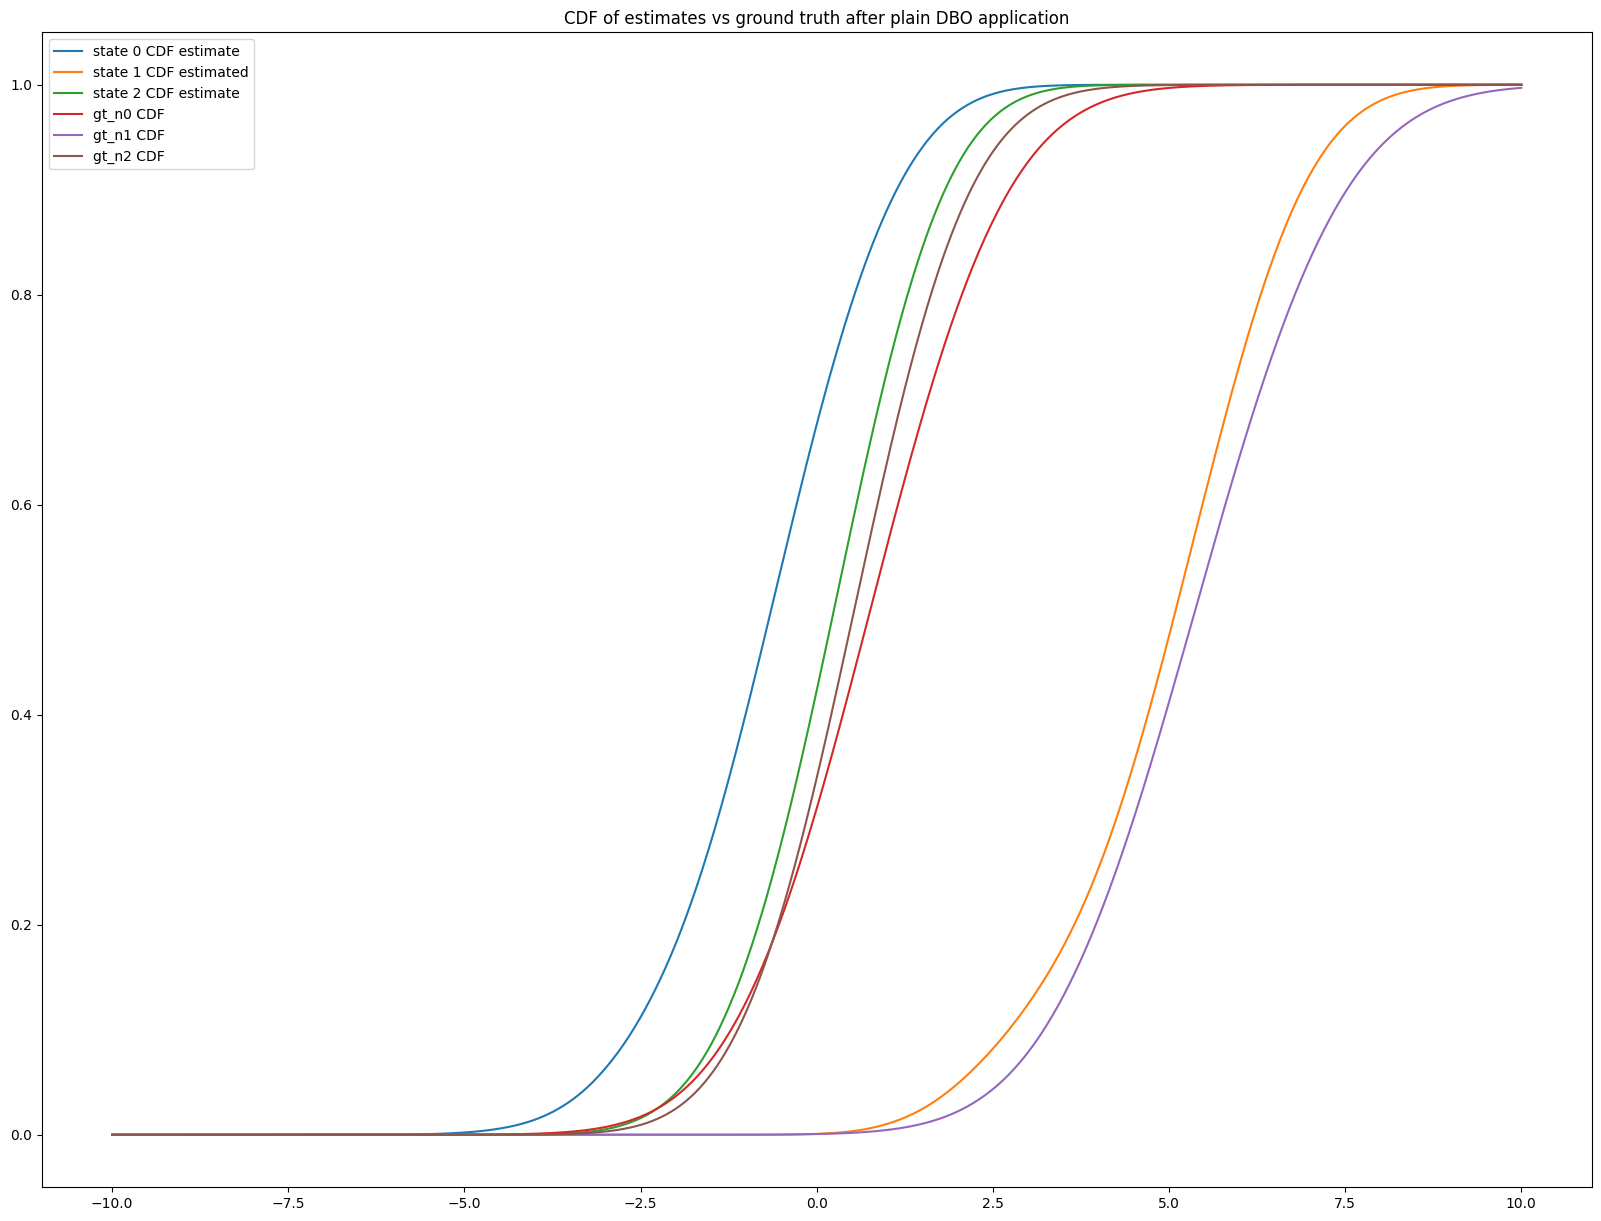

In [5]:
# get estimates -> RVs
n_est_0 = n_ret_est[n_states[0]]
n_est_1 = n_ret_est[n_states[1]]
n_est_2 = n_ret_est[n_states[2]]


common_support = np.linspace(-10, 10, 1000)

plt.figure(figsize=(20,15))
plt.title("CDF of estimates vs ground truth after plain DBO application")
plt.plot(common_support, n_est_0.cdf(common_support), label="state 0 CDF estimate")
plt.plot(common_support, n_est_1.cdf(common_support), label="state 1 CDF estimated")
plt.plot(common_support, n_est_2.cdf(common_support), label="state 2 CDF estimate")

plt.plot(np.linspace(-10,10, 1000), gt_n0.cdf(np.linspace(-10,10,1000)), label="gt_n0 CDF")
plt.plot(np.linspace(-10,10, 1000), gt_n1.cdf(np.linspace(-10,10,1000)), label="gt_n1 CDF")
plt.plot(np.linspace(-10,10, 1000), gt_n2.cdf(np.linspace(-10,10,1000)), label="gt_n2 CDF")
plt.legend()


In [11]:
n_w1_bar = extended_metric(wasserstein_beta, gt_n_ret_distr_fun.distr, n_ret_est.distr)
# n_linf_bar = extended_metric(birnb_orl_avg_dist_beta, gt_n_ret_distr_fun.distr, n_ret_est.distr, beta=np.inf)
print(f"Extended 1-Wasserstein Distance: {n_w1_bar}")
# print(f"Extended Kolmogorov Smirnov Distance: {n_linf_bar}")
print(f"Max Distribution Size: {n_ret_est.get_max_size()}")

Extended 1-Wasserstein Distance: 1.597494952383498
Max Distribution Size: 6249242


## Extended DDP
- extended ddp with different kind of projections
- emphasis on q-q-Case with size functions chose as suggested in paper

In [12]:
n_ret_est = deepcopy(n_ret_est_cp)

# warmup
for i in range(1,4):
    n_ret_est = ddp(
        cyclical_env.mdp,
        QuantileProjection,
        QuantileProjection,
        q_proj_poly_poly,
        n_ret_est,
        cyclical_env.mdp.rewards,
        i
        )

# resetting return distribution estimate
n_ret_est = deepcopy(n_ret_est_cp)

start = time.time()
for i in range(1, 26):
    n_ret_est = ddp(
        cyclical_env.mdp,
        QuantileProjection,
        QuantileProjection,
        q_proj_poly_poly,
        n_ret_est,
        cyclical_env.mdp.rewards,
        i
        )
    print(f"Iteration {i} of DDP completed.")
stop = time.time()
print(f"Duration: {stop - start}")
# #iterations = 26 -> runtime ~ 46 sec

Iteration 1 of DDP completed.
Iteration 2 of DDP completed.
Iteration 3 of DDP completed.
Iteration 4 of DDP completed.
Iteration 5 of DDP completed.
Iteration 6 of DDP completed.
Iteration 7 of DDP completed.
Iteration 8 of DDP completed.
Iteration 9 of DDP completed.
Iteration 10 of DDP completed.
Iteration 11 of DDP completed.
Iteration 12 of DDP completed.
Iteration 13 of DDP completed.
Iteration 14 of DDP completed.
Iteration 15 of DDP completed.
Iteration 16 of DDP completed.
Iteration 17 of DDP completed.
Iteration 18 of DDP completed.
Iteration 19 of DDP completed.
Iteration 20 of DDP completed.
Iteration 21 of DDP completed.
Iteration 22 of DDP completed.
Iteration 23 of DDP completed.
Iteration 24 of DDP completed.
Iteration 25 of DDP completed.
Duration: 36.03805112838745


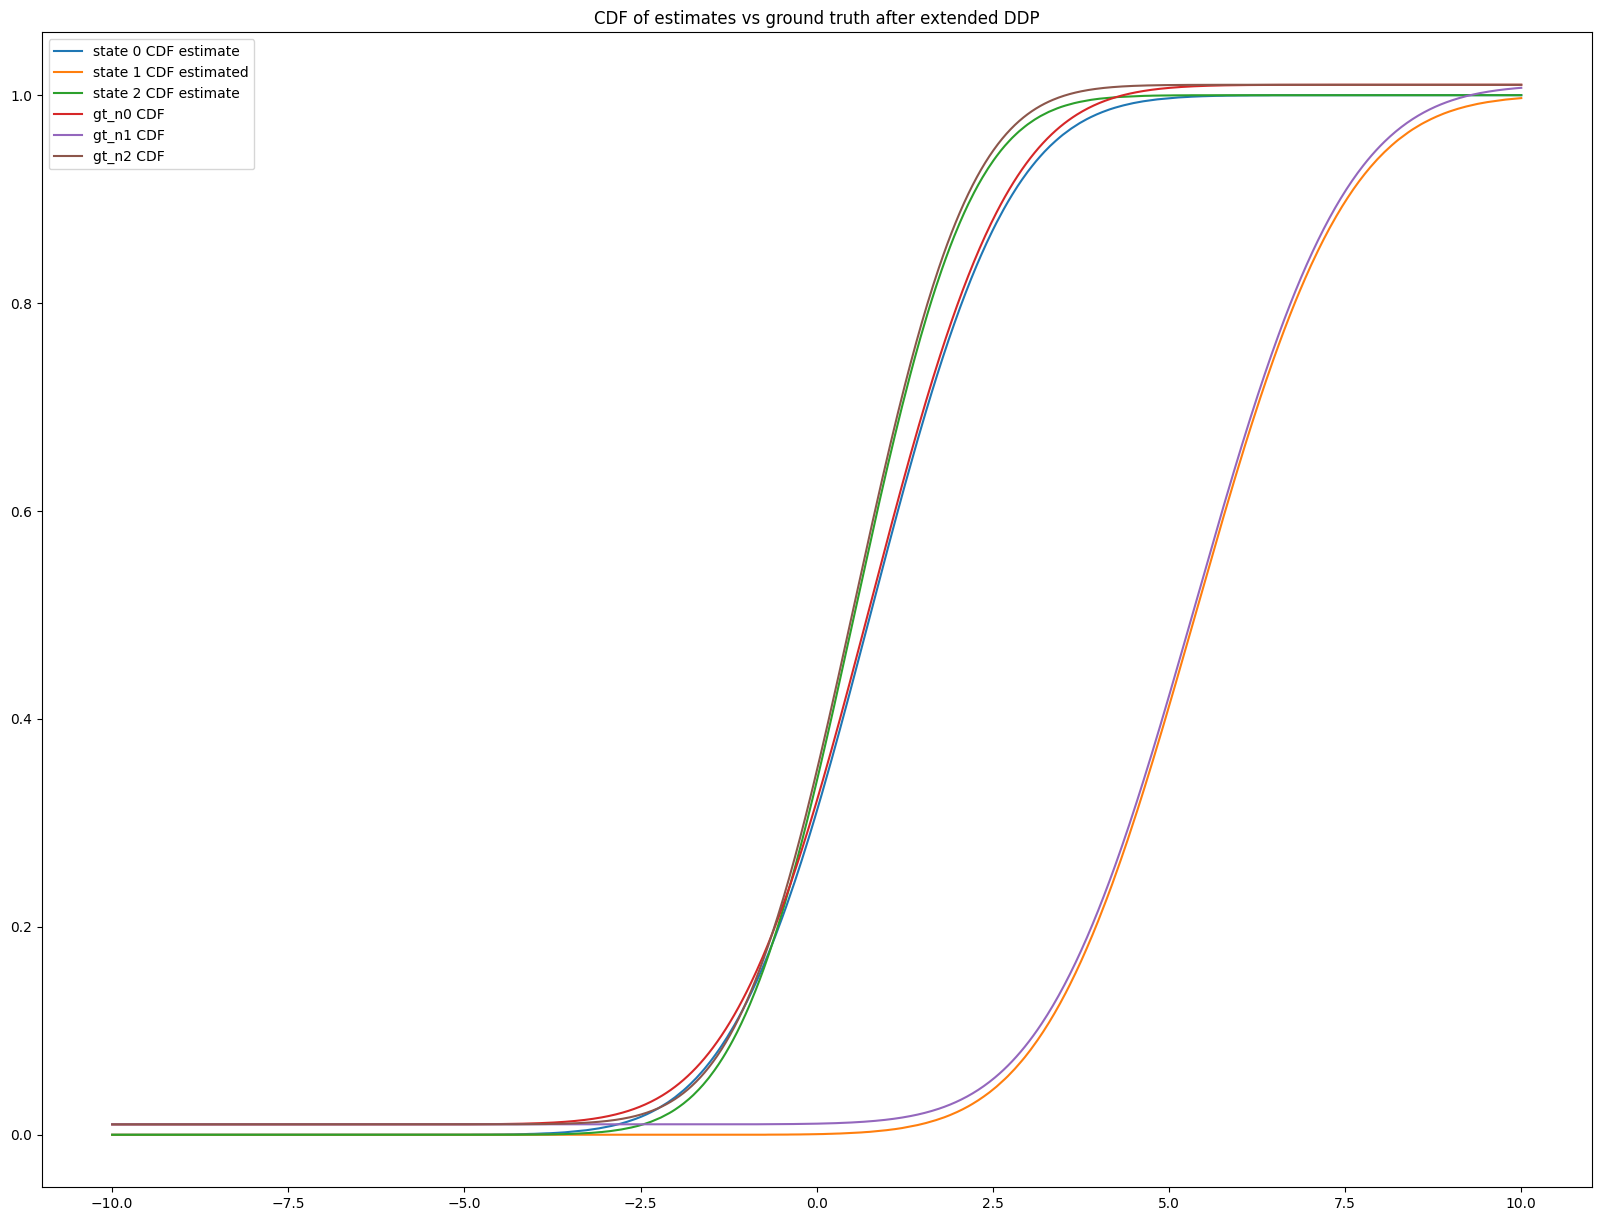

In [13]:
n_est_0 = n_ret_est[n_states[0]]
n_est_1 = n_ret_est[n_states[1]]
n_est_2 = n_ret_est[n_states[2]]


common_support = np.linspace(-10, 10, 1000)

plt.figure(figsize=(20,15))
plt.title("CDF of estimates vs ground truth after extended DDP")
plt.plot(common_support, n_est_0.cdf(common_support), label="state 0 CDF estimate")
plt.plot(common_support, n_est_1.cdf(common_support), label="state 1 CDF estimated")
plt.plot(common_support, n_est_2.cdf(common_support), label="state 2 CDF estimate")

plt.plot(np.linspace(-10,10, 1000), gt_n0.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n0 CDF")
plt.plot(np.linspace(-10,10, 1000), gt_n1.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n1 CDF")
plt.plot(np.linspace(-10,10, 1000), gt_n2.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n2 CDF")
plt.legend()


### 1-Wasserstein distance and # particles

In [14]:
n_w1_bar = extended_metric(wasserstein_beta, gt_n_ret_distr_fun.distr, n_ret_est.distr)
n_linf_bar = extended_metric(birnb_orl_avg_dist_beta, gt_n_ret_distr_fun.distr, n_ret_est.distr, np.inf)
print(f"Extended 1-Wasserstein Distance: {n_w1_bar}")
print(f"Extended Kolmogorov Smirnov Distance: {n_linf_bar}")
print(f"Max Distribution Size: {n_ret_est.get_max_size()}")

Extended 1-Wasserstein Distance: 0.001303456890994064
Extended Kolmogorov Smirnov Distance: 0.055103999999999986
Max Distribution Size: 15625


## Monte Carlo 

### Running MC simulation for $t \leq 45$ sec

In [15]:
# monte carlo estimate
n_num_mc: int = 2900  # number of trajectories simulated
mc_start_time = time.time()
n_ret_est_mc = monte_carlo_eval(cyclical_env.mdp, n_num_mc, 30)
mc_stop_time = time.time()
print(mc_stop_time - mc_start_time)

44.97327184677124


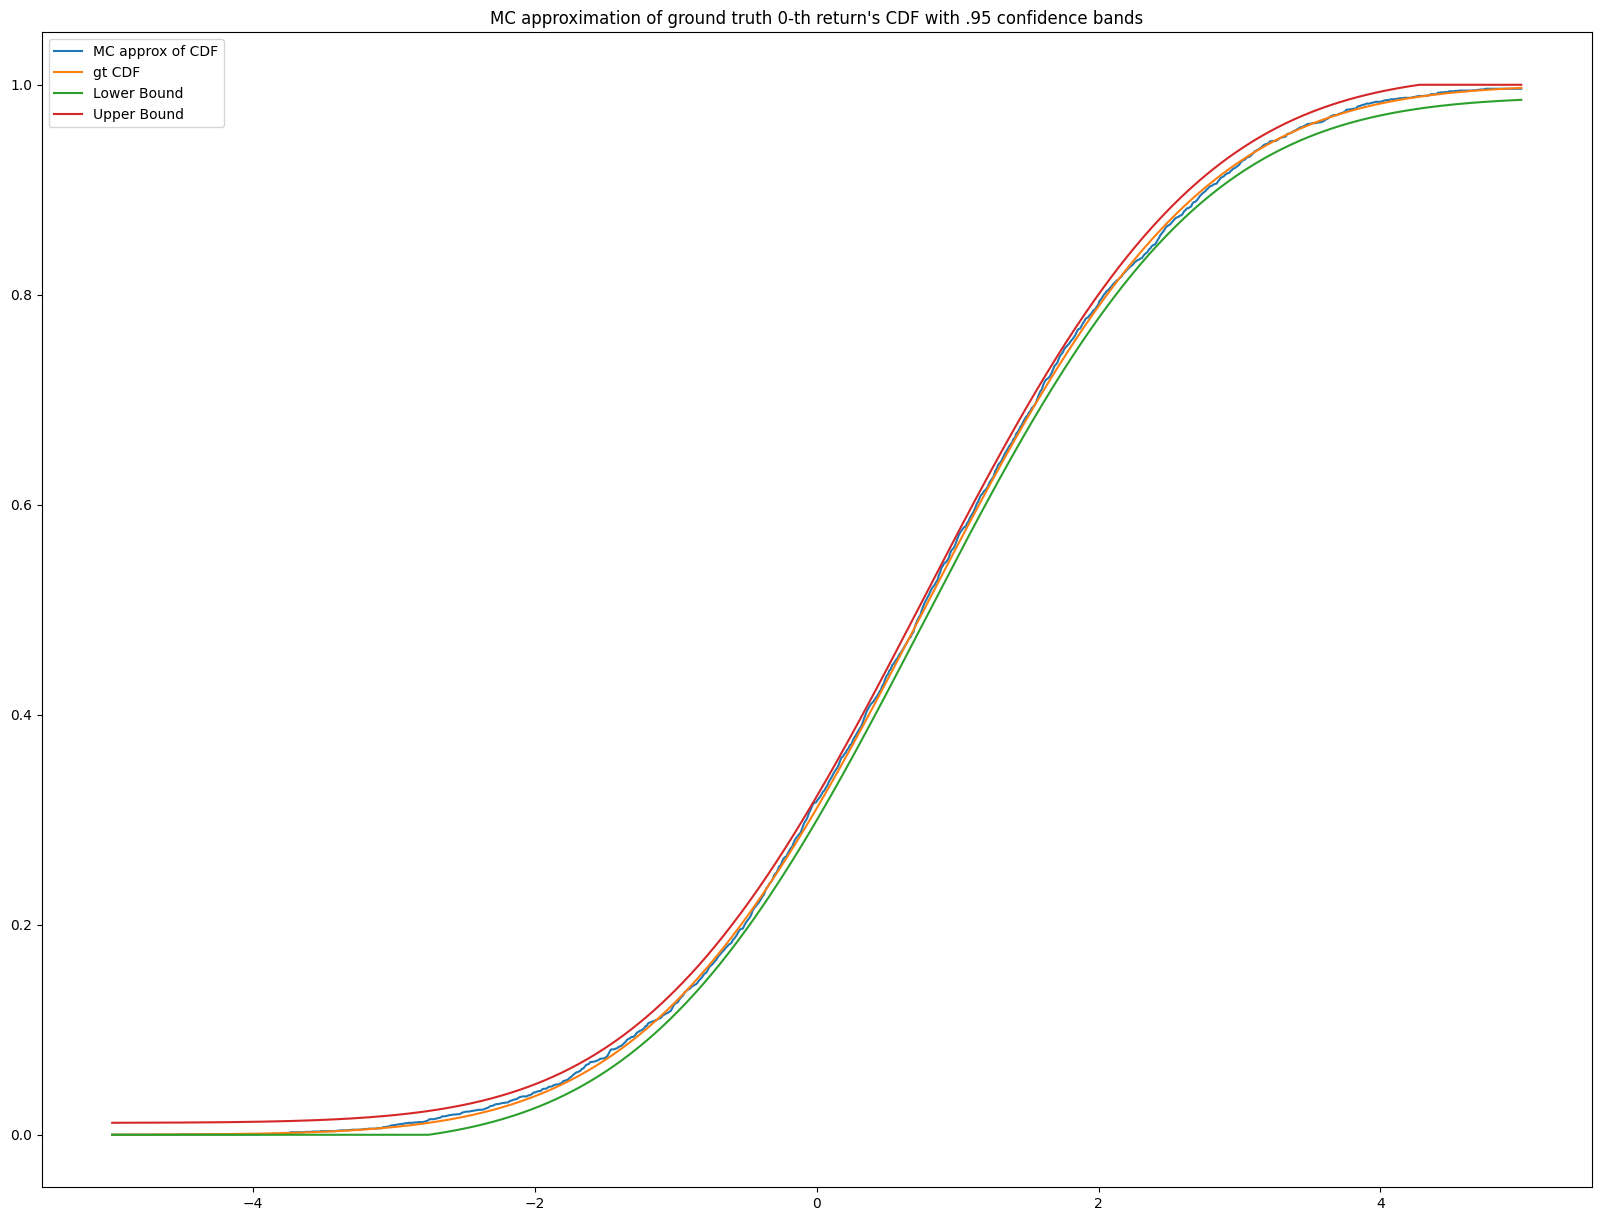

In [16]:
xvals = np.linspace(-5, 5, 1000)

plt.figure(figsize=(20,15))
plt.title("MC approximation of ground truth 0-th return's CDF with .95 confidence bands")
plt.plot(xvals, n_ret_est_mc[n_states[0]].cdf(xvals), label="MC approx of CDF")
cdf, lb, ub = dkw_bounds(gt_n0.cdf, xvals, n_num_mc, 0.95)
plt.plot(xvals, cdf, label="gt CDF")
plt.plot(xvals, lb, label="Lower Bound")
plt.plot(xvals, ub, label="Upper Bound")
plt.legend()

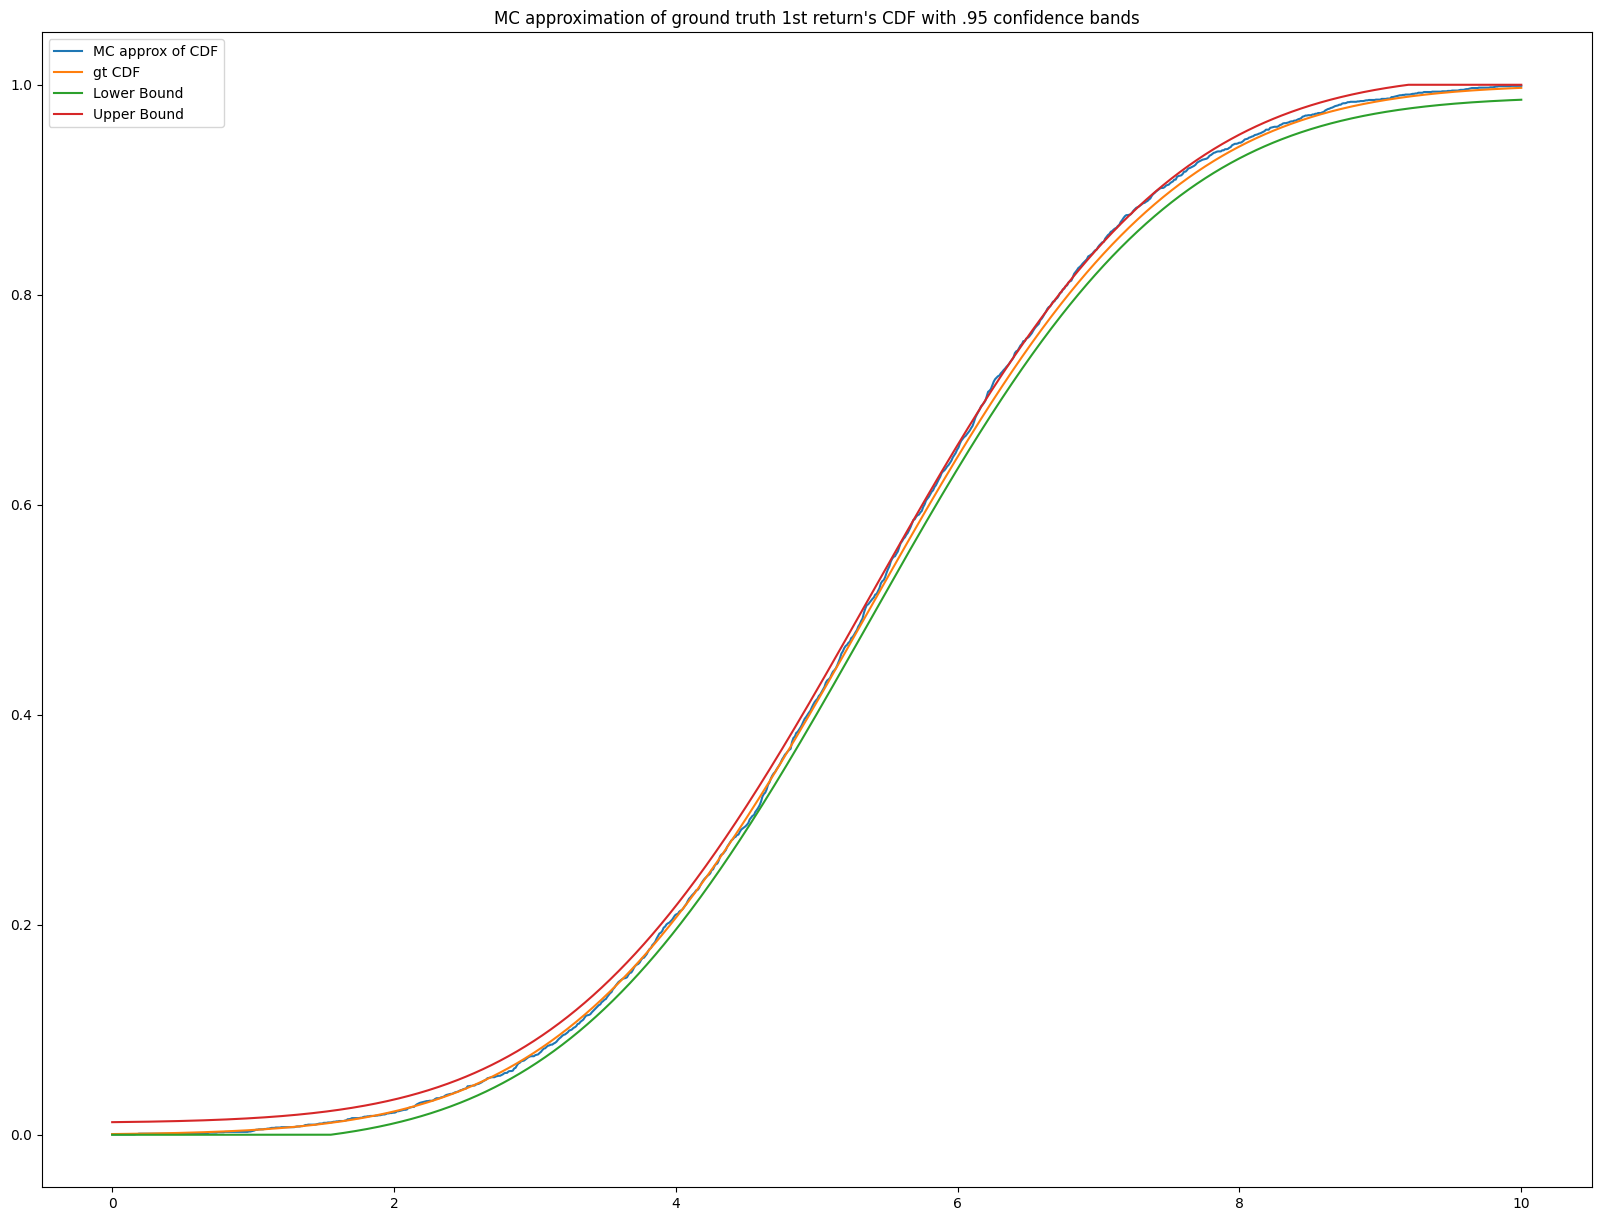

In [17]:
xvals = np.linspace(0, 10, 1000)

plt.figure(figsize=(20,15))
plt.title("MC approximation of ground truth 1st return's CDF with .95 confidence bands")
plt.plot(xvals, n_ret_est_mc[n_states[1]].cdf(xvals), label="MC approx of CDF")
cdf, lb, ub = dkw_bounds(gt_n1.cdf, xvals, n_num_mc, 0.95)
plt.plot(xvals, cdf, label="gt CDF")
plt.plot(xvals, lb, label="Lower Bound")
plt.plot(xvals, ub, label="Upper Bound")
plt.legend()

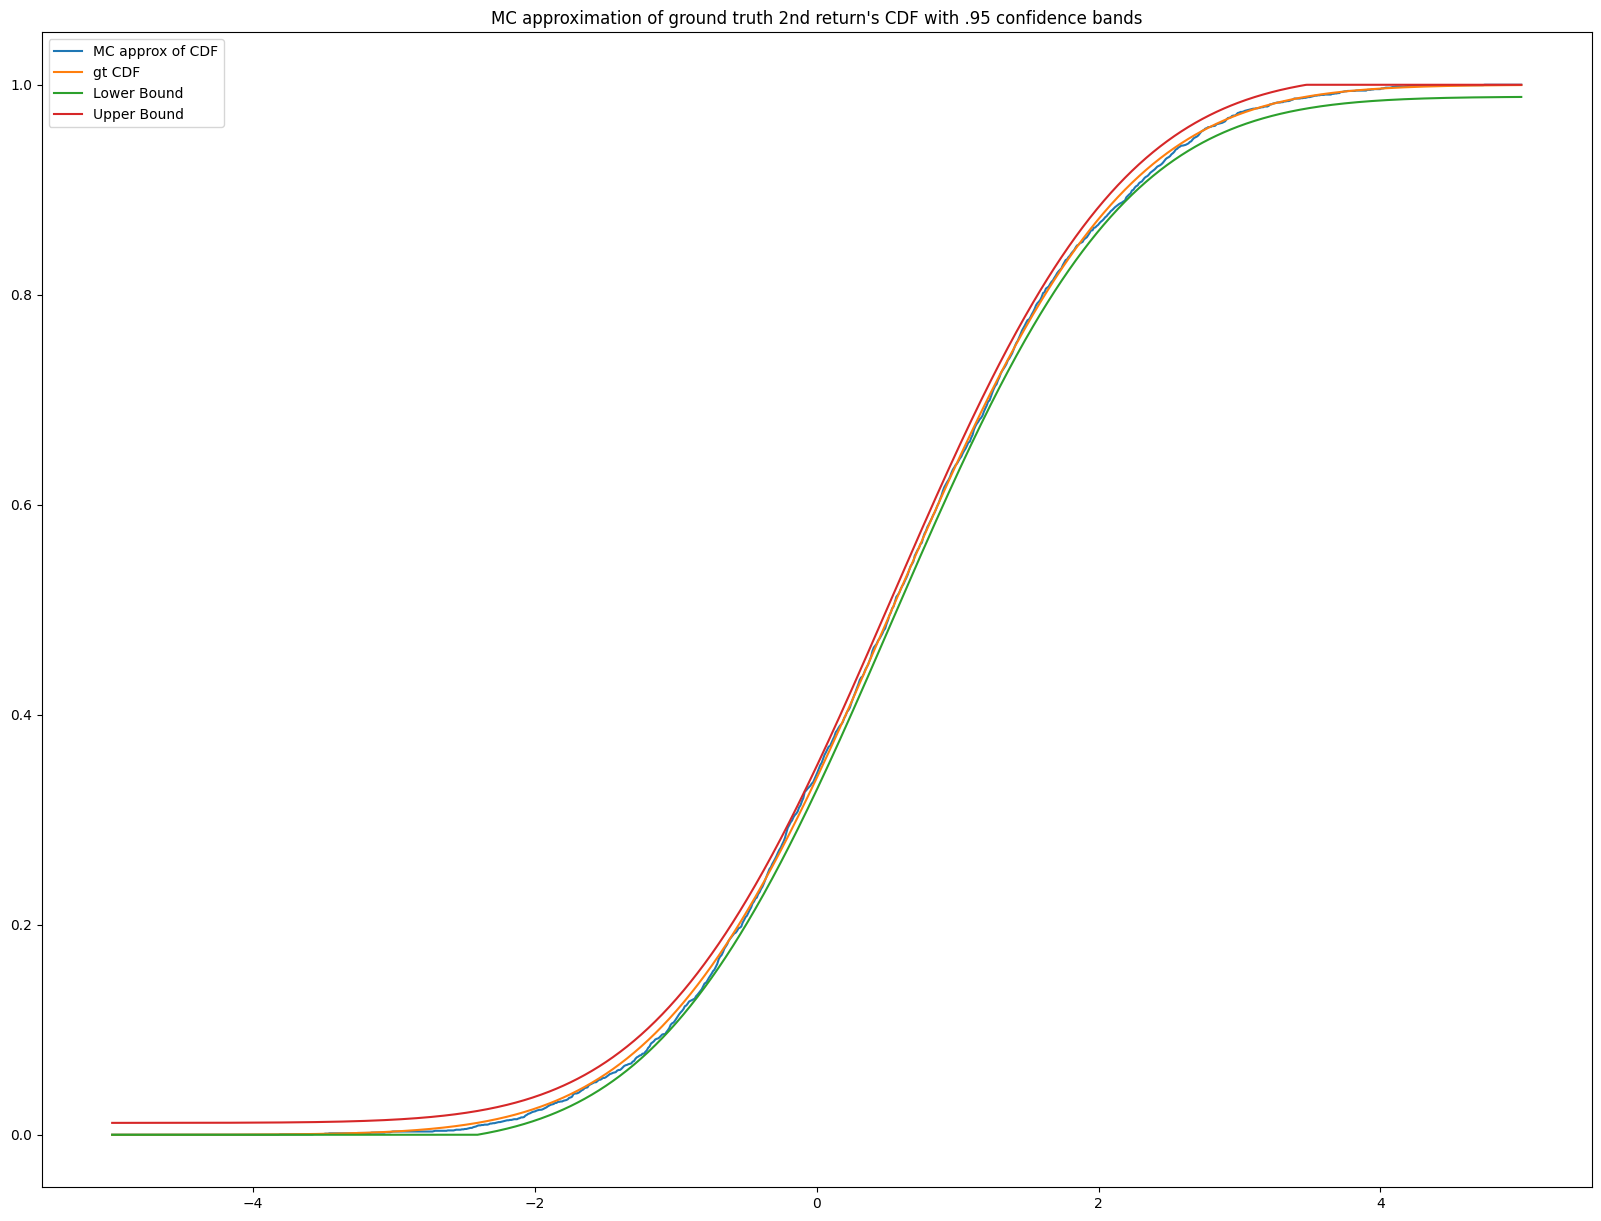

In [18]:
xvals = np.linspace(-5, 5, 1000)

plt.figure(figsize=(20,15))
plt.title("MC approximation of ground truth 2nd return's CDF with .95 confidence bands")
plt.plot(xvals, n_ret_est_mc[n_states[2]].cdf(xvals), label="MC approx of CDF")
cdf, lb, ub = dkw_bounds(gt_n2.cdf, xvals, n_num_mc, 0.95)
plt.plot(xvals, cdf, label="gt CDF")
plt.plot(xvals, lb, label="Lower Bound")
plt.plot(xvals, ub, label="Upper Bound")
plt.legend()

In [19]:
print(
    "Extended 1-Wasserstein distance:",
    f"{extended_metric(wasserstein_beta,gt_n_ret_distr_fun.distr, n_ret_est_mc.distr)}"
    )
print(
    "Extended Kolmogorov-Smirnov distance:",
    f"{extended_metric(birnb_orl_avg_dist_beta, gt_n_ret_distr_fun.distr, n_ret_est_mc.distr, beta=np.inf)}"
)
print(f"Max Distribution Size: {n_ret_est_mc.get_max_size()}")
print(f"Runtime of MC sim: {mc_stop_time - mc_start_time}")

Extended 1-Wasserstein distance: 0.03958997205103268
Extended Kolmogorov-Smirnov distance: 0.05868965517241387
Max Distribution Size: 2900
Runtime of MC sim: 44.97327184677124


### Running MC sim to match size of final return distribution function estimate

In [20]:
n_num_mc_to_match = 15625
mc_start_time = time.time()
n_ret_est_mc = monte_carlo_eval(cyclical_env.mdp, n_num_mc_to_match, 30)
mc_stop_time = time.time()
print(mc_stop_time - mc_start_time)

225.50123381614685


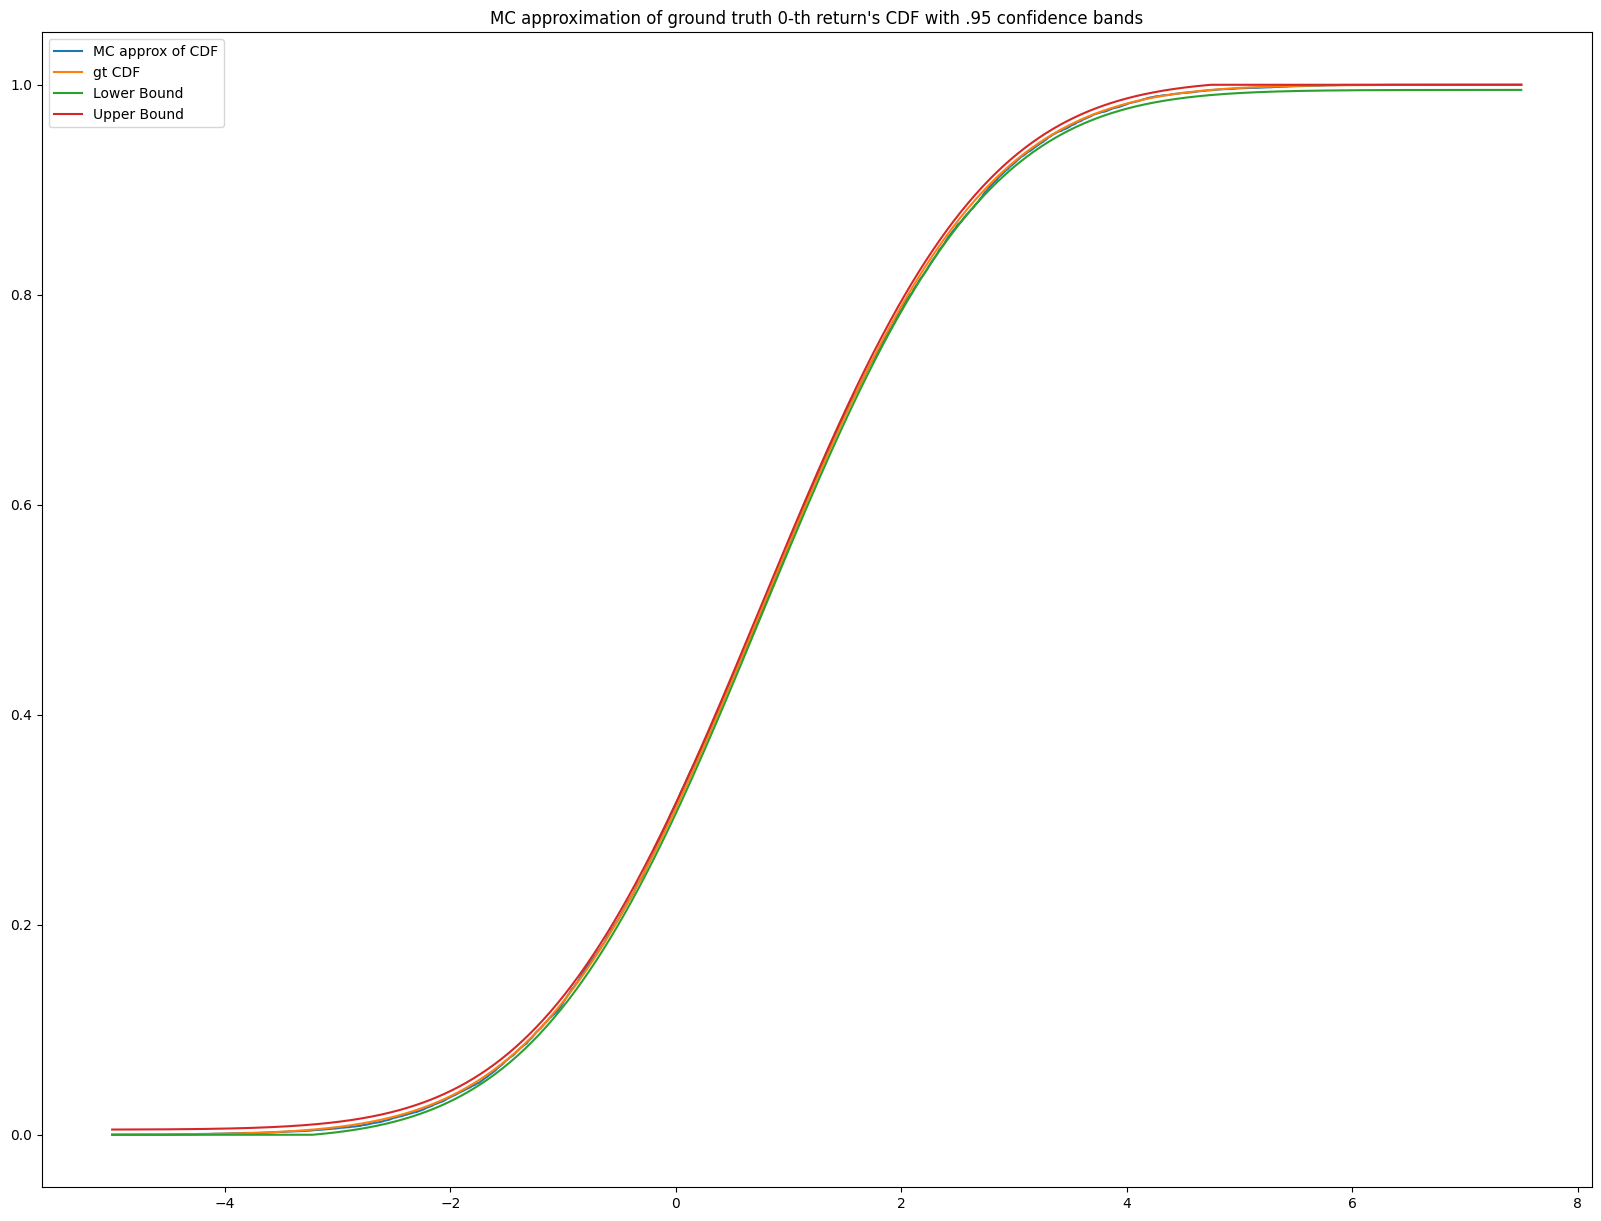

In [21]:
xvals = np.linspace(-5, 7.5, 1000)

plt.figure(figsize=(20,15))
plt.title("MC approximation of ground truth 0-th return's CDF with .95 confidence bands")
plt.plot(xvals, n_ret_est_mc[n_states[0]].cdf(xvals), label="MC approx of CDF")
cdf, lb, ub = dkw_bounds(gt_n0.cdf, xvals, n_num_mc_to_match, 0.95)
plt.plot(xvals, cdf, label="gt CDF")
plt.plot(xvals, lb, label="Lower Bound")
plt.plot(xvals, ub, label="Upper Bound")
plt.legend()

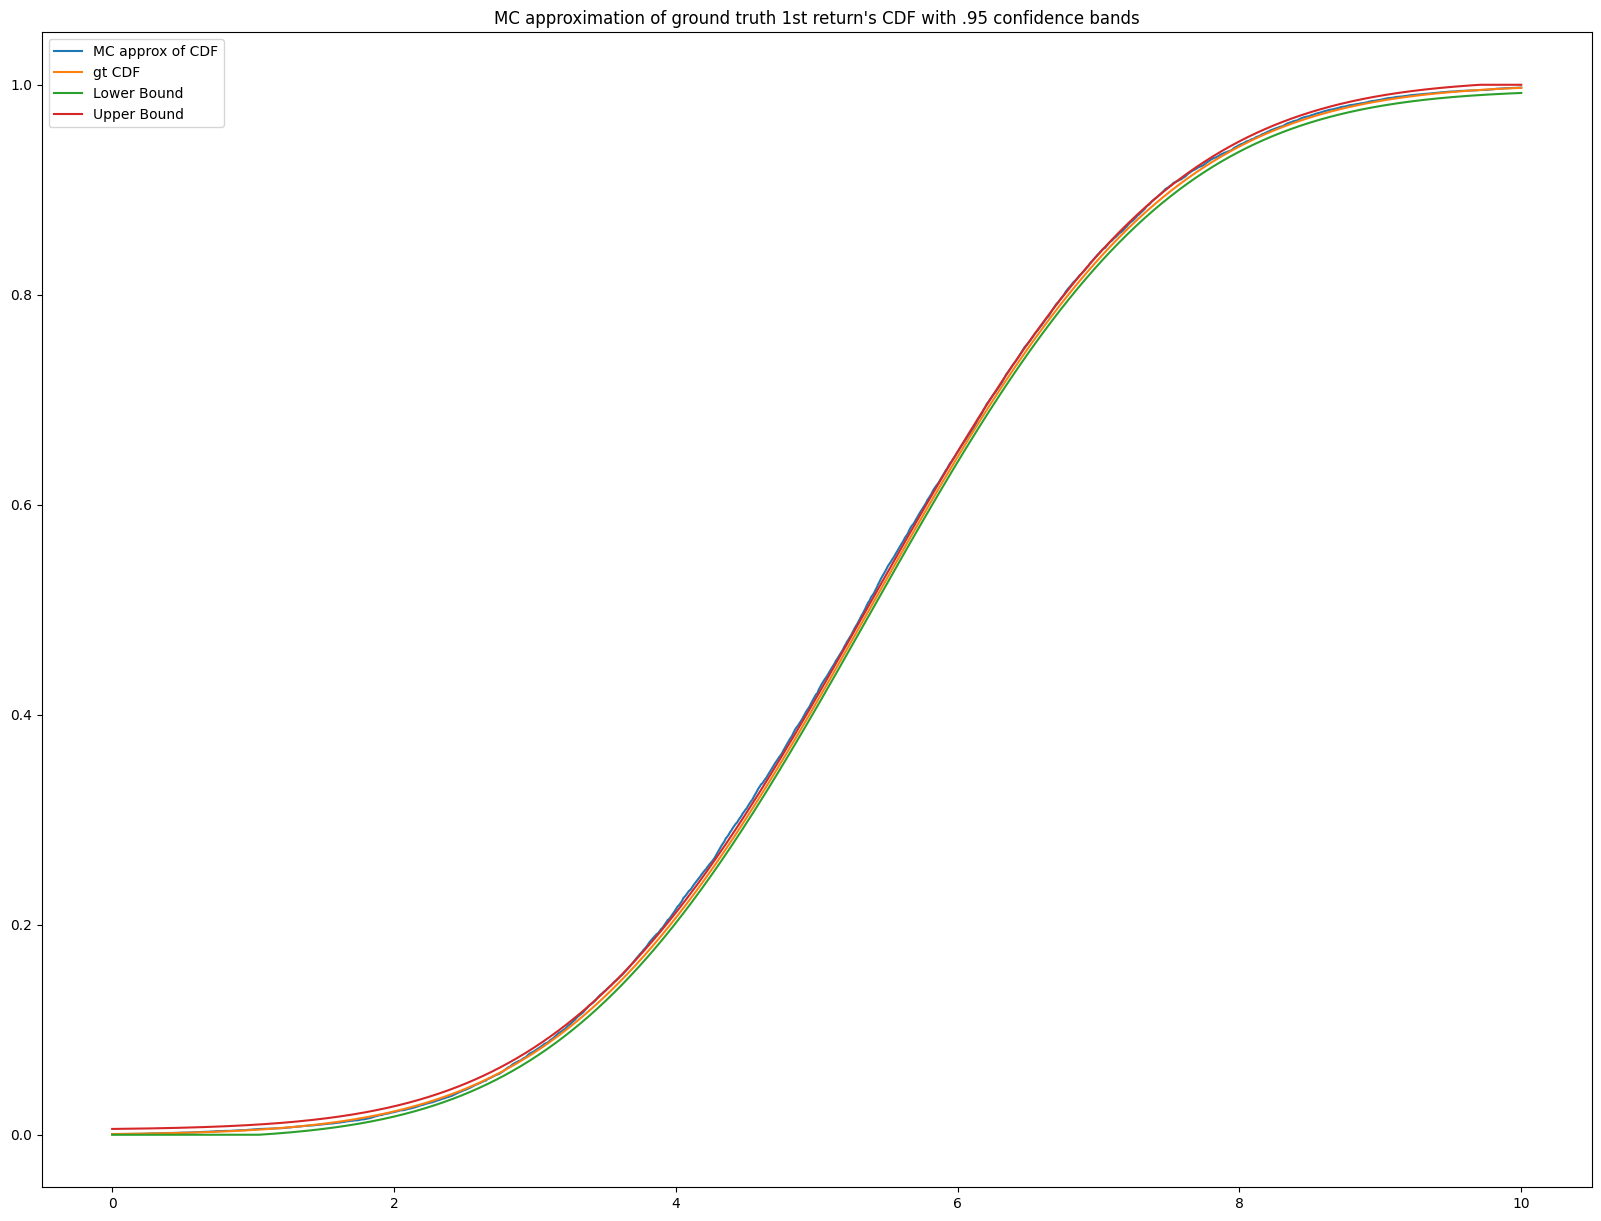

In [22]:

xvals = np.linspace(0, 10, 1000)

plt.figure(figsize=(20,15))
plt.title("MC approximation of ground truth 1st return's CDF with .95 confidence bands")
plt.plot(xvals, n_ret_est_mc[n_states[1]].cdf(xvals), label="MC approx of CDF")
cdf, lb, ub = dkw_bounds(gt_n1.cdf, xvals, n_num_mc_to_match, 0.95)
plt.plot(xvals, cdf, label="gt CDF")
plt.plot(xvals, lb, label="Lower Bound")
plt.plot(xvals, ub, label="Upper Bound")
plt.legend()

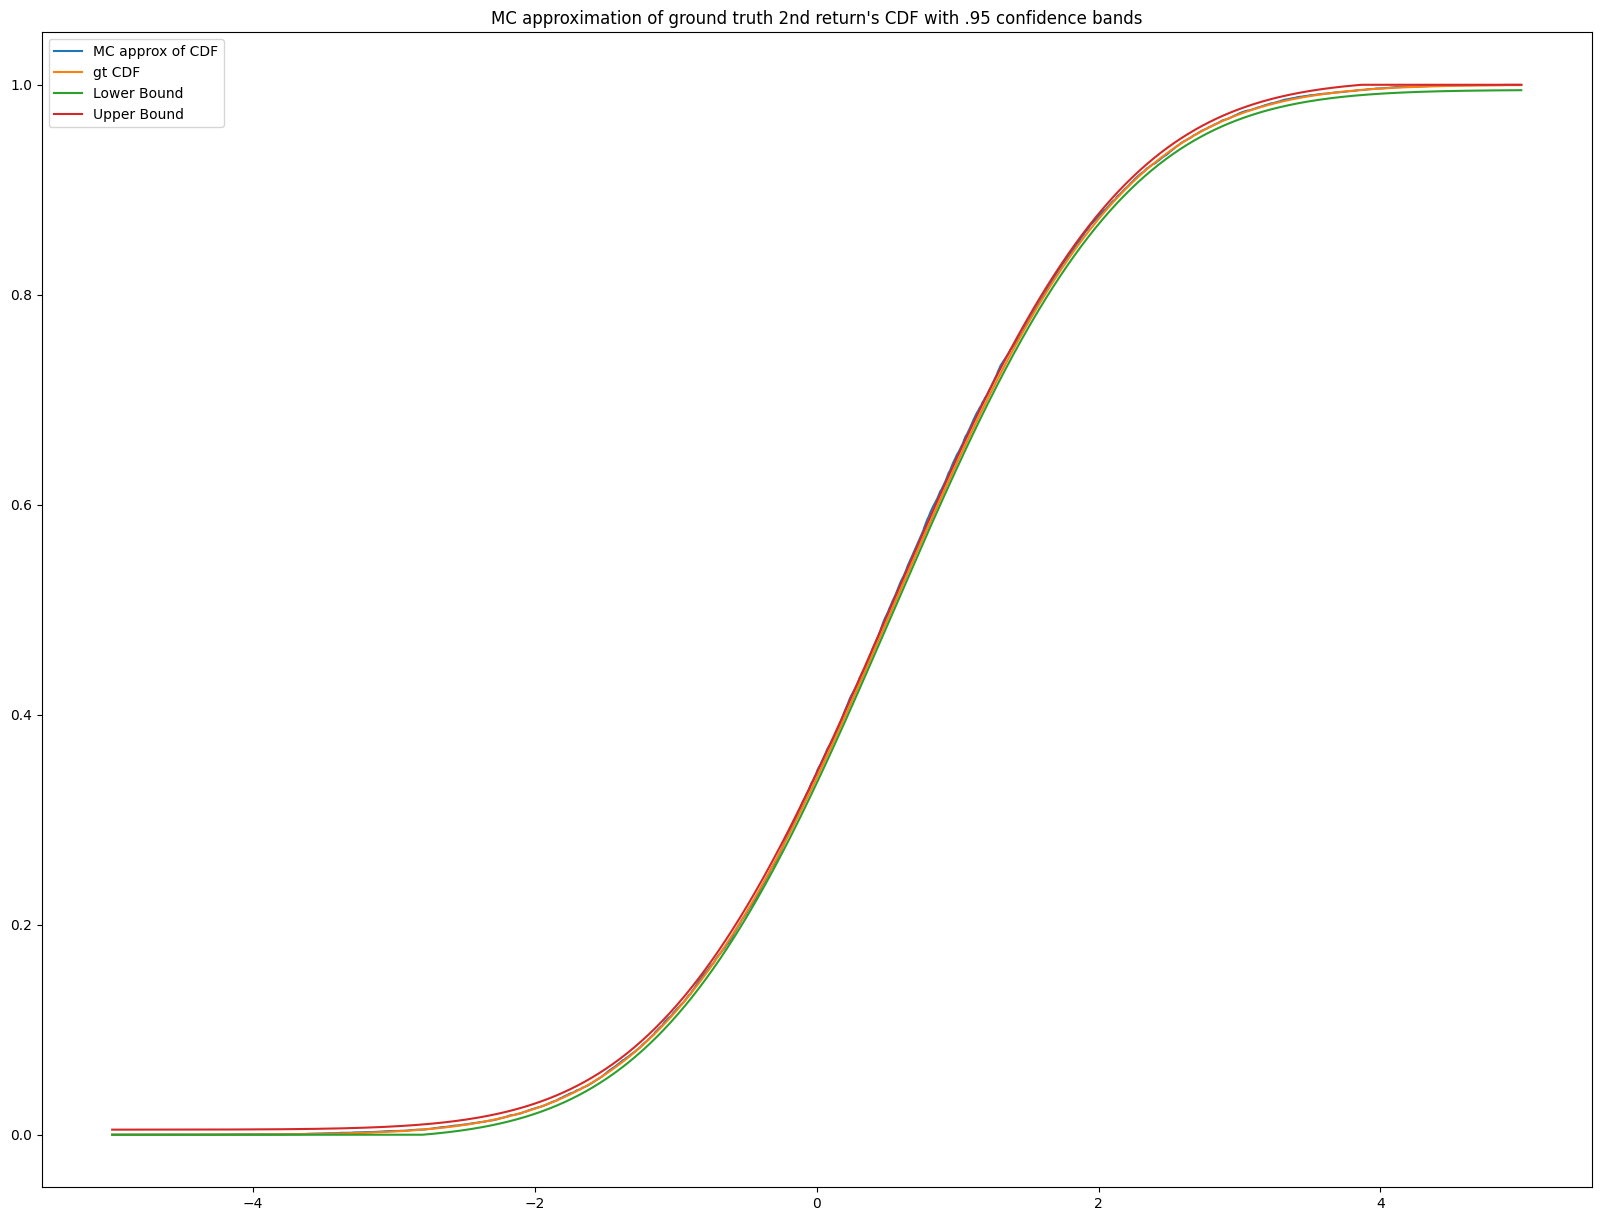

In [23]:
xvals = np.linspace(-5, 5, 1000)

plt.figure(figsize=(20,15))
plt.title("MC approximation of ground truth 2nd return's CDF with .95 confidence bands")
plt.plot(xvals, n_ret_est_mc[n_states[2]].cdf(xvals), label="MC approx of CDF")
cdf, lb, ub = dkw_bounds(gt_n2.cdf, xvals, n_num_mc_to_match, 0.95)
plt.plot(xvals, cdf, label="gt CDF")
plt.plot(xvals, lb, label="Lower Bound")
plt.plot(xvals, ub, label="Upper Bound")
plt.legend()

In [25]:

print(
    "Extended 1-Wasserstein Distance:",
    f"{extended_metric(wasserstein_beta,gt_n_ret_distr_fun.distr, n_ret_est_mc.distr)}"
    )

print(
    "Extended Kolmogorov-Smirnov distance:",
    f"{extended_metric(birnb_orl_avg_dist_beta, gt_n_ret_distr_fun.distr, n_ret_est_mc.distr, beta=np.inf)}"
)
print(f"Max Distribution Size: {n_ret_est_mc.get_max_size()}")
print(f"Runtime of MC sim: {mc_stop_time - mc_start_time}s = {(mc_stop_time - mc_start_time) / 60} min")

Extended 1-Wasserstein Distance: 0.033227700684018285
Extended Kolmogorov-Smirnov distance: 0.03156800000000026
Max Distribution Size: 15625
Runtime of MC sim: 225.50123381614685s = 3.758353896935781 min


# Cyclical MDP with rewards ~ $Cauchy(loc, scale)$

In [3]:
from src.sample_envs import cauchy_env
from src.sample_envs import cauchy_real_return_distr_fun as gt_cau_ret_distr_fun
cau_mdp = cauchy_env.mdp
cau_states = cau_mdp.states
cau_ret_est = ReturnDistributionFunction(
    states=cau_states,
    distributions=[DiscreteRV(np.asarray([0]), np.asarray([1])) for _ in cau_states]
    )
cau_ret_est_cp = deepcopy(cau_ret_est)



## Plain DBO
- applying the DBO without any projections, equivalent to P_in = Pi_out = P_id

In [4]:

cau_ret_est = deepcopy(cau_ret_est_cp)
ks = list(cauchy_env.mdp.rewards.rewards.keys())
cauchy_discretized_rewards = RewardDistributionCollection(
    ks,
    [cauchy_env.mdp.rewards[k].empirical(50) for k in ks]
    )
print("DBO application with discretized rewards.")

# warmup
for i in range(1):
    dbo(cauchy_env.mdp, cau_ret_est, cauchy_discretized_rewards)

cau_ret_est = deepcopy(cau_ret_est_cp)

start_time = time.time()
for i in range(4):
    dbo(cauchy_env.mdp, cau_ret_est, cauchy_discretized_rewards)
    print(f"Iteration {i} completed.")
stop_time = time.time()
cau_time_plain_dbo = stop_time - start_time
print(cau_time_plain_dbo)
# 4th iteration takes 100 seconds

DBO application with discretized rewards.
Iteration 0 completed.
Iteration 1 completed.
Iteration 2 completed.
Iteration 3 completed.
5.8208723068237305


Memory usage of CDF evaluation:                     372.5113272666931 GB.


Memory usage of CDF evaluation:                     372.5169897079468 GB.
Memory usage of CDF evaluation:                     372.52116203308105 GB.


Text(0.5, 1.0, 'Return Distribution Approximation with plain DBO iteration')

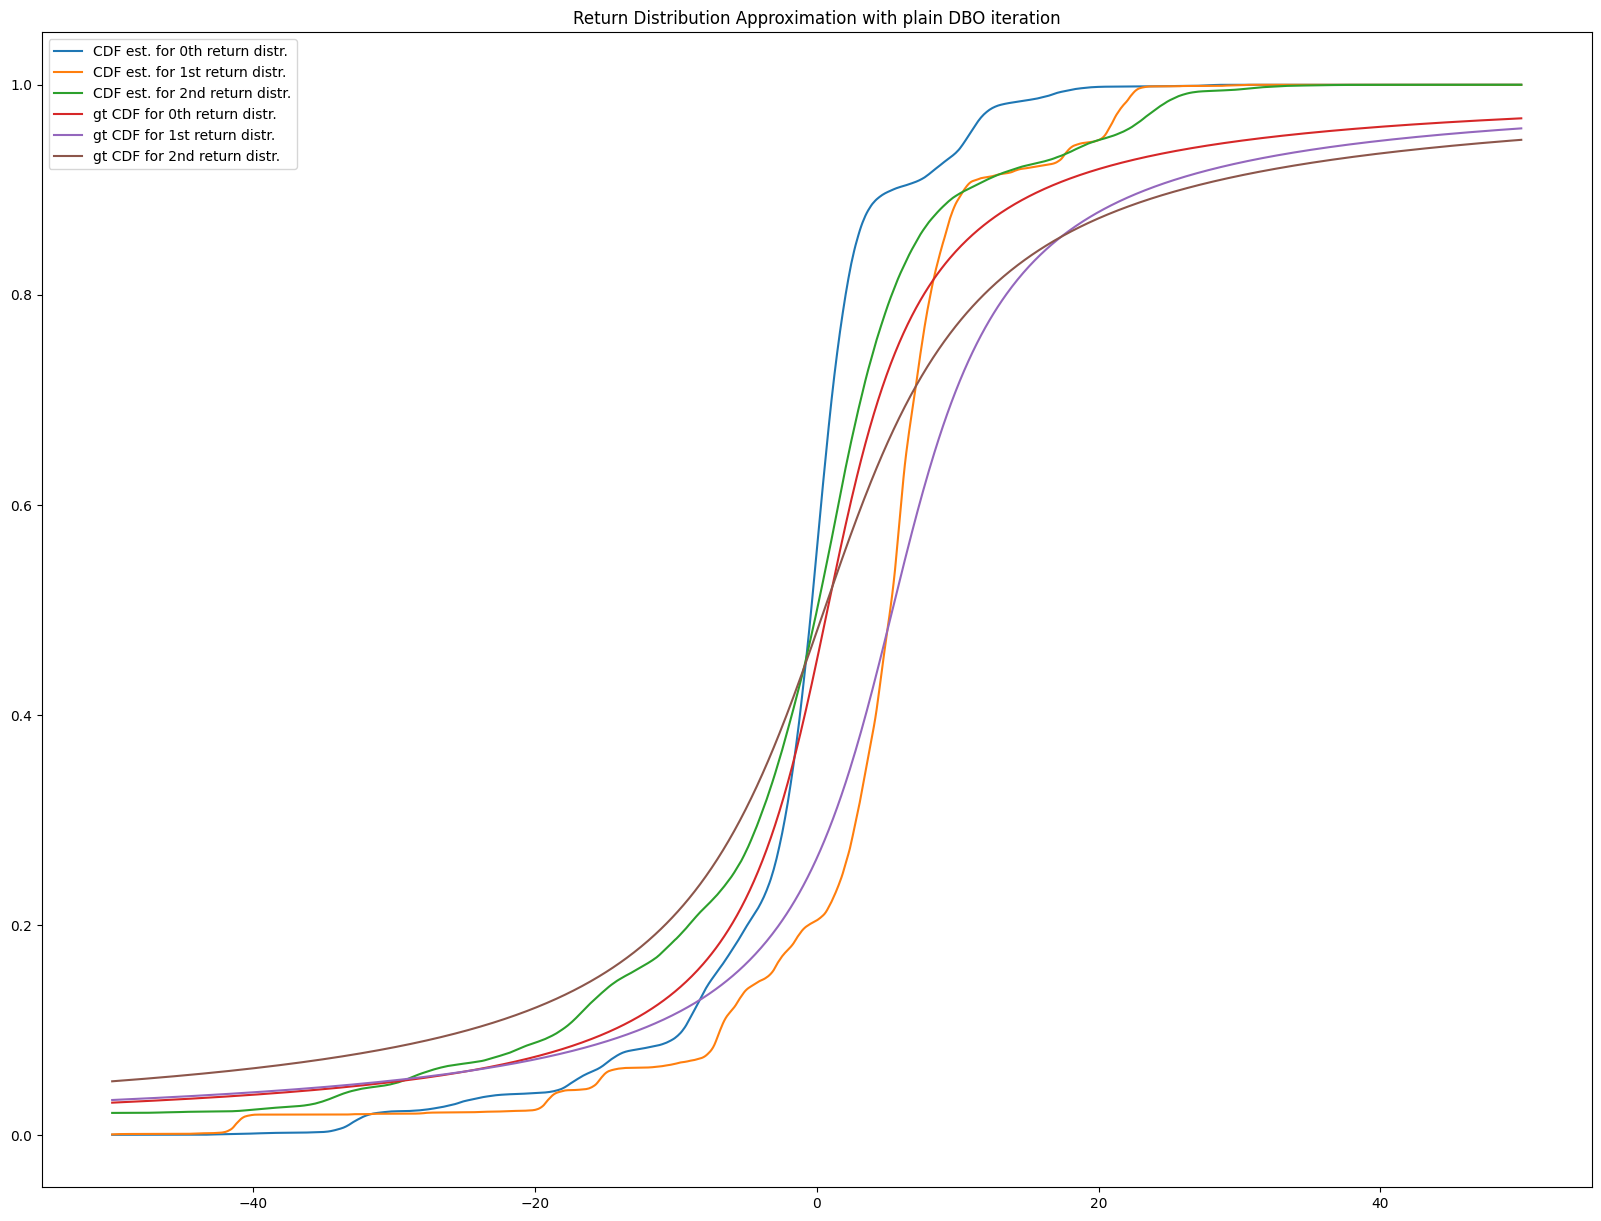

In [5]:
plt.figure(figsize=(20,15))
xvals = np.linspace(-50, 50, 1000)
plt.plot(xvals, cau_ret_est[0].cdf(xvals), label="CDF est. for 0th return distr.")
plt.plot(xvals, cau_ret_est[1].cdf(xvals), label="CDF est. for 1st return distr.")
plt.plot(xvals, cau_ret_est[2].cdf(xvals), label="CDF est. for 2nd return distr.")

plt.plot(xvals, gt_cau_ret_distr_fun[cau_states[0]].cdf(xvals), label="gt CDF for 0th return distr.")
plt.plot(xvals, gt_cau_ret_distr_fun[cau_states[1]].cdf(xvals), label="gt CDF for 1st return distr.")
plt.plot(xvals, gt_cau_ret_distr_fun[cau_states[2]].cdf(xvals), label="gt CDF for 2nd return distr.")
plt.legend()
plt.title("Return Distribution Approximation with plain DBO iteration")


In [ ]:
print(f"Max Distribution size: {cau_ret_est.get_max_size()}")


Max Distribution size: 6249868


Memory usage of CDF evaluation:                     186.27053499221802 GB.
Memory usage of CDF evaluation:                     2328271.04270494 GB.


## Extended DDP

In [4]:
cau_ret_est = deepcopy(cau_ret_est_cp)

# warmup
for i in range(1, 3):
    cau_ret_est = ddp(
        cau_mdp,
        QuantileProjection,
        QuantileProjection,
        q_proj_poly_poly,
        cau_ret_est,
        reward_distr_coll=cau_mdp.rewards,
        iteration_num=i)

# reset return distr. function estimate
cau_ret_est = deepcopy(cau_ret_est_cp)

# actual computation
start_time = time.time()
for i in range(1, 26):
    cau_ret_est = ddp(
        cau_mdp,
        QuantileProjection,
        QuantileProjection,
        q_proj_poly_poly,
        cau_ret_est,
        reward_distr_coll=cau_mdp.rewards,
        iteration_num=i)

    print(f"Completed iteration {i}")
stop_time = time.time()
cau_time_ddp = stop_time - start_time
print(f"Time spent on DDP: {cau_time_ddp}")

Completed iteration 1
Completed iteration 2


/Users/Andy/.local/share/virtualenvs/master_thesis-8HvZwd8T/lib/python3.9/site-packages/numba/core/lowering.py:112: NumbaDebugInfoWarning: Could not find source for function: <function __numba_array_expr_0x12639b490 at 0x125f68670>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/Users/Andy/.local/share/virtualenvs/master_thesis-8HvZwd8T/lib/python3.9/site-packages/numba/core/lowering.py:112: NumbaDebugInfoWarning: Could not find source for function: <function __numba_array_expr_0x126201310 at 0x125f7dd30>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))


Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Time spent on DDP: 39.386427879333496


Text(0.5, 1.0, 'Return Distribution approximation with extended DDP')

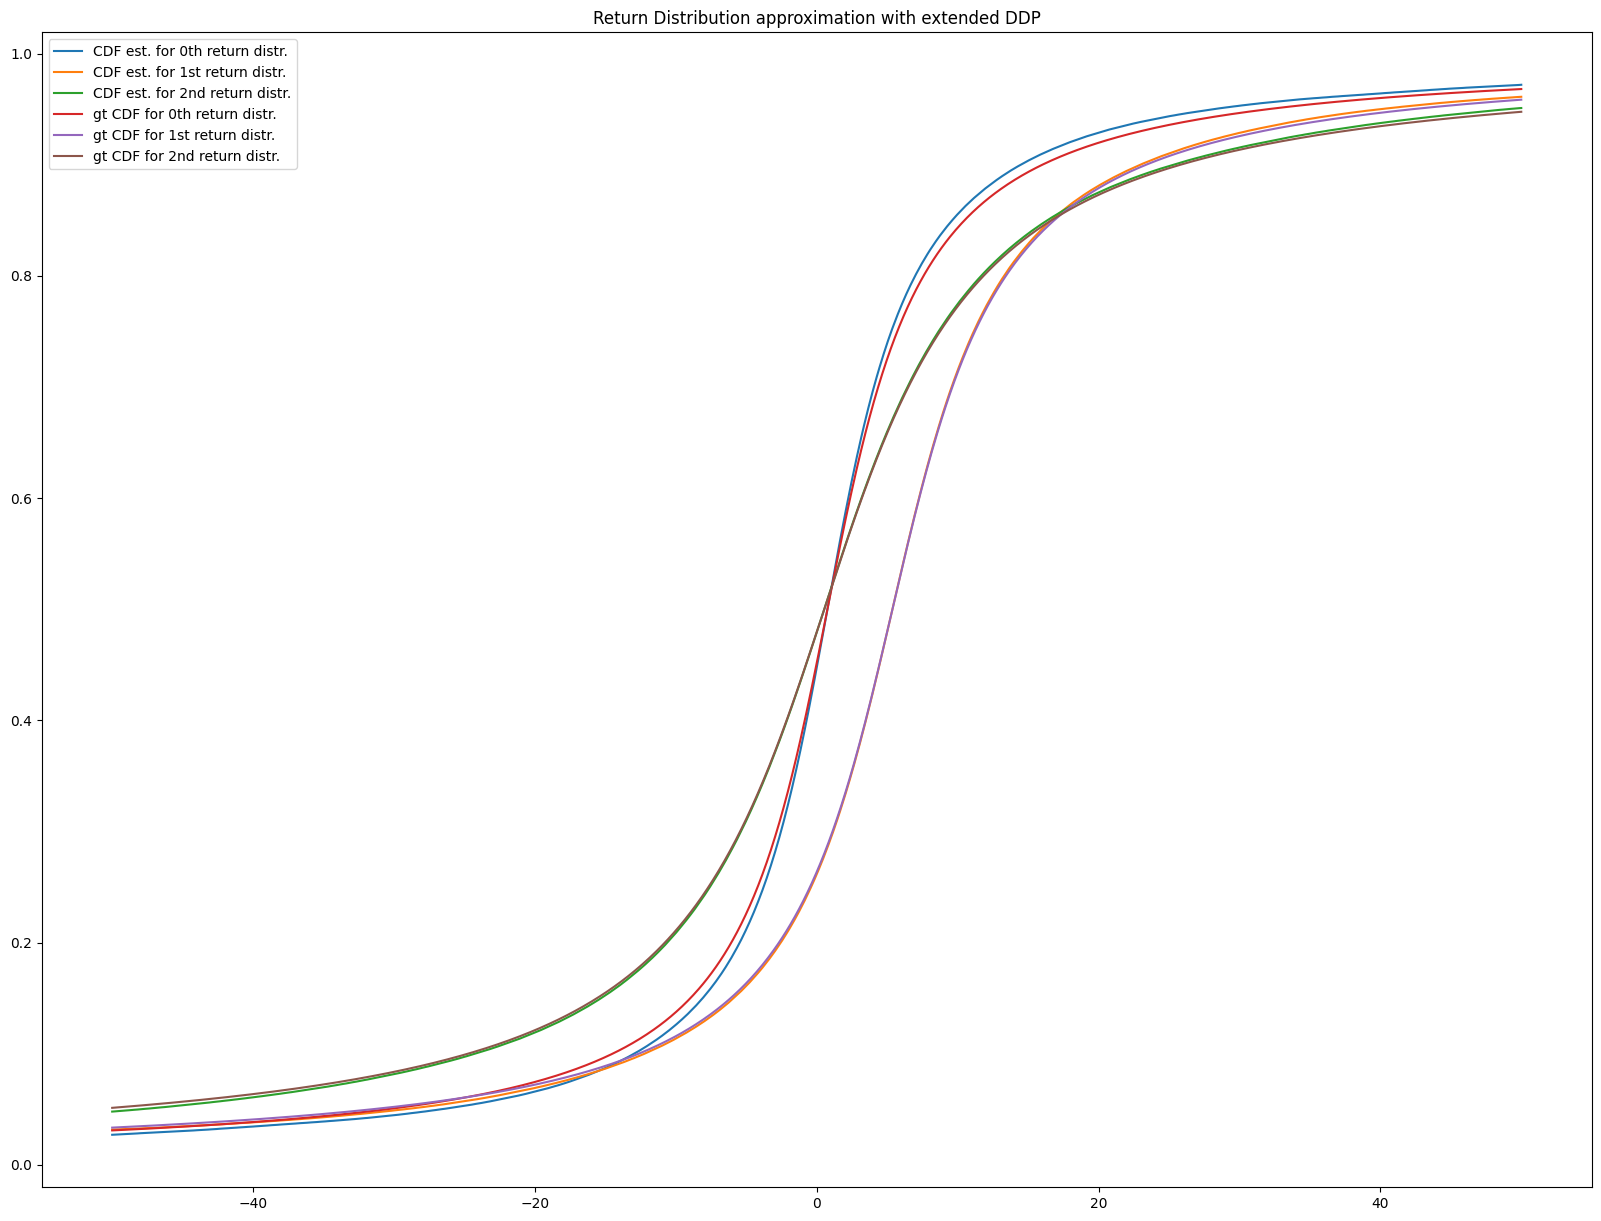

In [7]:
plt.figure(figsize=(20,15))
xvals = np.linspace(-50, 50, 1000)
plt.plot(xvals, cau_ret_est[0].cdf(xvals), label="CDF est. for 0th return distr.")
plt.plot(xvals, cau_ret_est[1].cdf(xvals), label="CDF est. for 1st return distr.")
plt.plot(xvals, cau_ret_est[2].cdf(xvals), label="CDF est. for 2nd return distr.")

plt.plot(xvals, gt_cau_ret_distr_fun[cau_states[0]].cdf(xvals), label="gt CDF for 0th return distr.")
plt.plot(xvals, gt_cau_ret_distr_fun[cau_states[1]].cdf(xvals), label="gt CDF for 1st return distr.")
plt.plot(xvals, gt_cau_ret_distr_fun[cau_states[2]].cdf(xvals), label="gt CDF for 2nd return distr.")
plt.legend()
plt.title("Return Distribution approximation with extended DDP")

In [6]:
print(
    "Extended 2-Birnbaum-Orlicz Distance:",
    f"{extended_metric(birnb_orl_avg_dist_beta,gt_cau_ret_distr_fun.distr, cau_ret_est.distr, beta=2)}"
    )
print(
    "Extended Kolmogorov-Smirnov Distance",
    f"{extended_metric(birnb_orl_avg_dist_beta,gt_cau_ret_distr_fun.distr, cau_ret_est.distr, beta=np.inf)}"
    )
print(f"Max Distribution Size: {cau_ret_est.get_max_size()}")
print(f"Runtime of extended DDP: {cau_time_ddp}")

Extended 2-Birnbaum-Orlicz Distance: 0.858493327165465
Extended Kolmogorov-Smirnov Distance 0.05379199999999984
Max Distribution Size: 15625
Runtime of extended DDP: 39.386427879333496


## Monte Carlo

### Running MC simulation for $t \leq 45$ sec

In [8]:
# monte carlo estimate 
confidence_level = 0.95 # used for dkw bounds
cau_num_mc = 2700
start_time = time.time()
cau_ret_est_mc = monte_carlo_eval(cau_mdp, cau_num_mc, 30)
stop_time = time.time()
cau_time_mc = stop_time - start_time
print(f"MC sim runtime: {cau_time_mc}")

MC sim runtime: 40.949179887771606


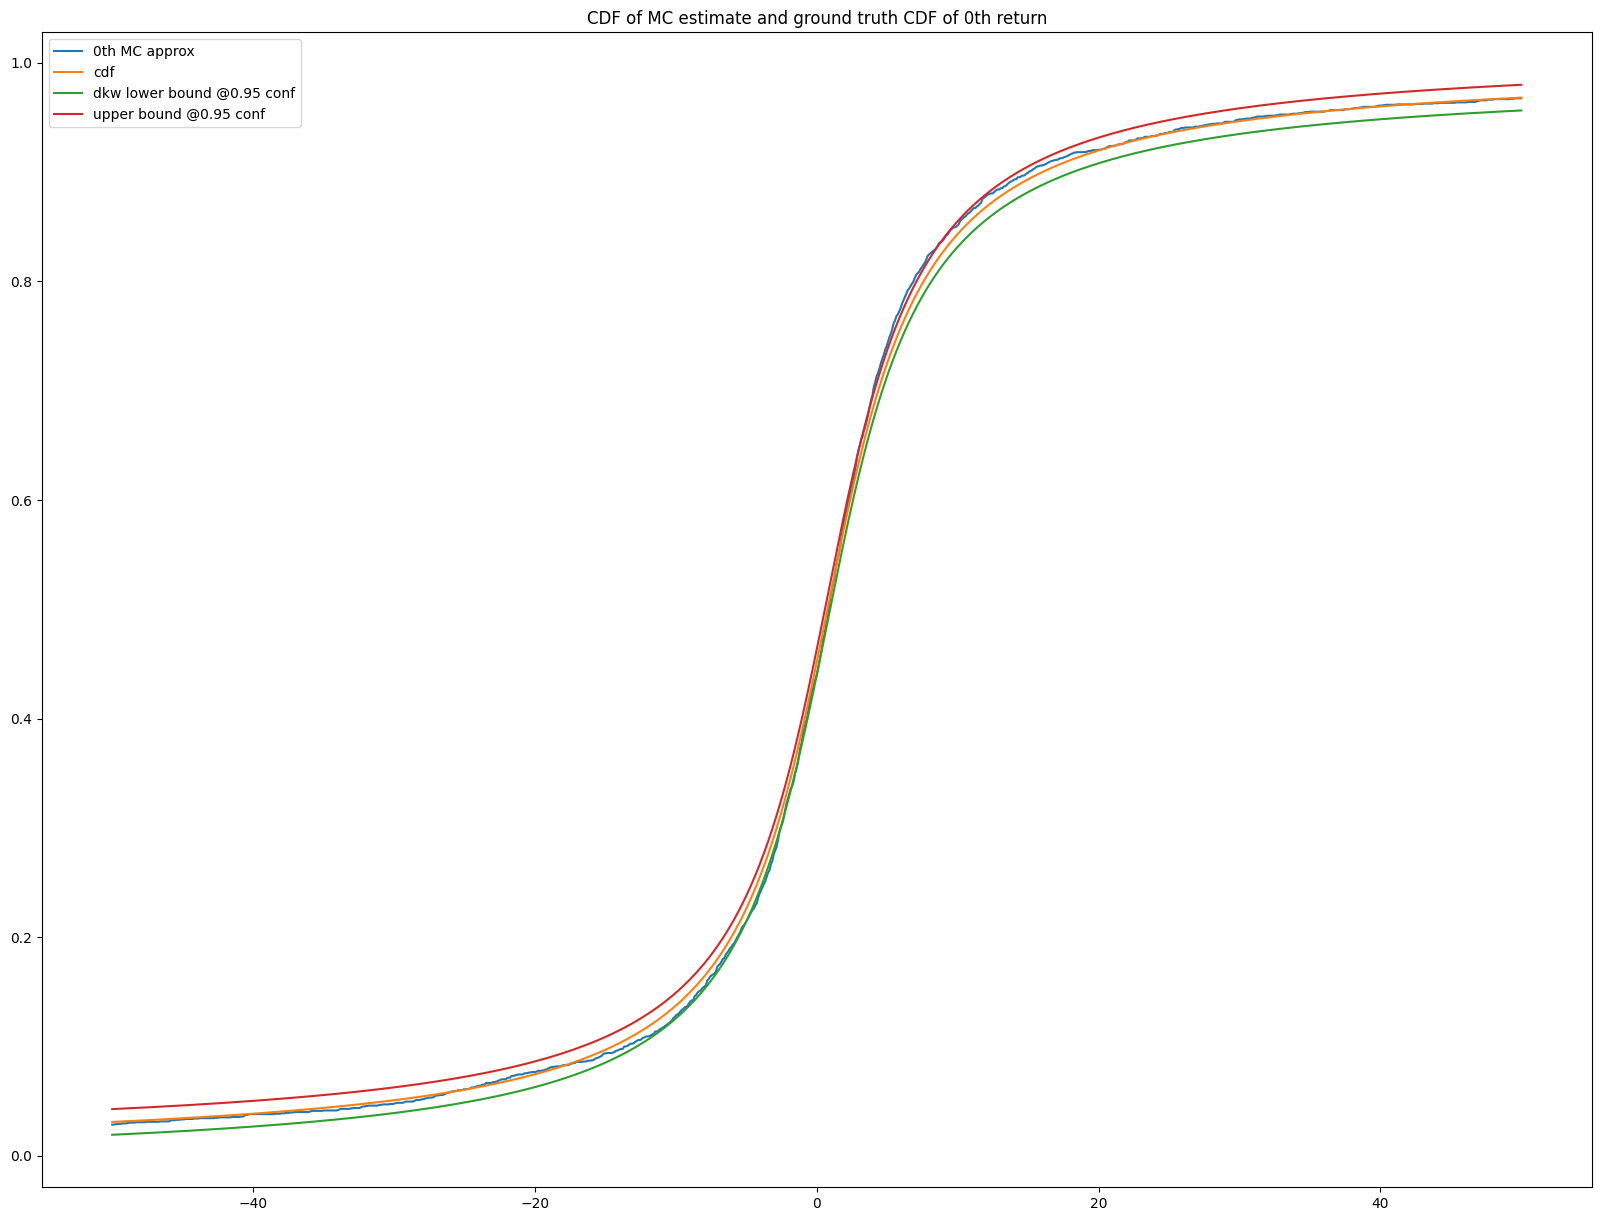

In [9]:
plt.figure(figsize=(20,15))
plt.title("CDF of MC estimate and ground truth CDF of 0th return")
plt.plot(xvals, cau_ret_est_mc[cau_states[0]].cdf(xvals), label="0th MC approx")
cdf, lb, ub = dkw_bounds(gt_cau_ret_distr_fun[cau_states[0]].cdf, xvals, cau_num_mc, confidence_level)
# plt.plot(r1_cauchy[0], n1.cdf(r1_cauchy[0]), label="real")
plt.plot(xvals, cdf, label="cdf")
plt.plot(xvals, lb, label=f"dkw lower bound @{confidence_level} conf")
plt.plot(xvals, ub, label=f"upper bound @{confidence_level} conf")
plt.legend()

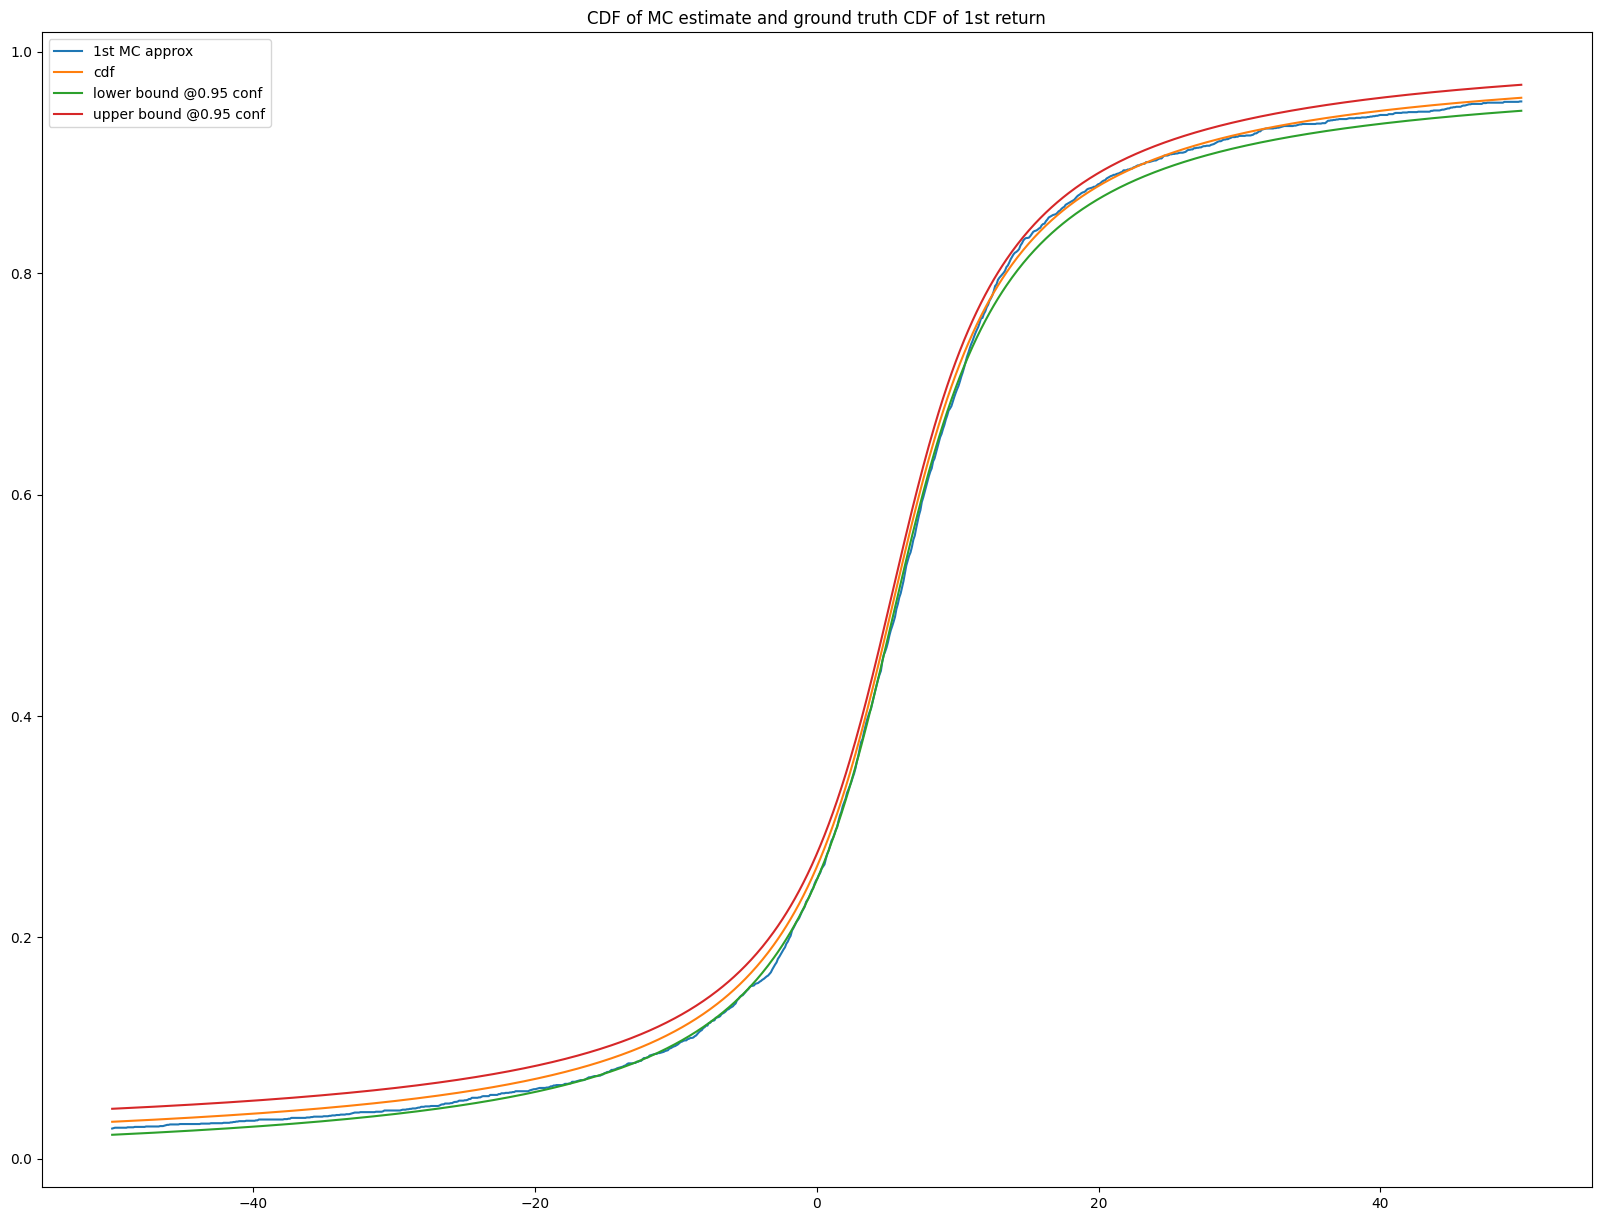

In [10]:
plt.figure(figsize=(20,15))
plt.title("CDF of MC estimate and ground truth CDF of 1st return")
plt.plot(xvals, cau_ret_est_mc[cau_states[1]].cdf(xvals), label="1st MC approx")
cdf, lb, ub = dkw_bounds(gt_cau_ret_distr_fun[cau_states[1]].cdf, xvals, cau_num_mc, 0.95)
plt.plot(xvals, cdf, label="cdf")
plt.plot(xvals, lb, label=f"lower bound @{confidence_level} conf")
plt.plot(xvals, ub, label=f"upper bound @{confidence_level} conf")
plt.legend()

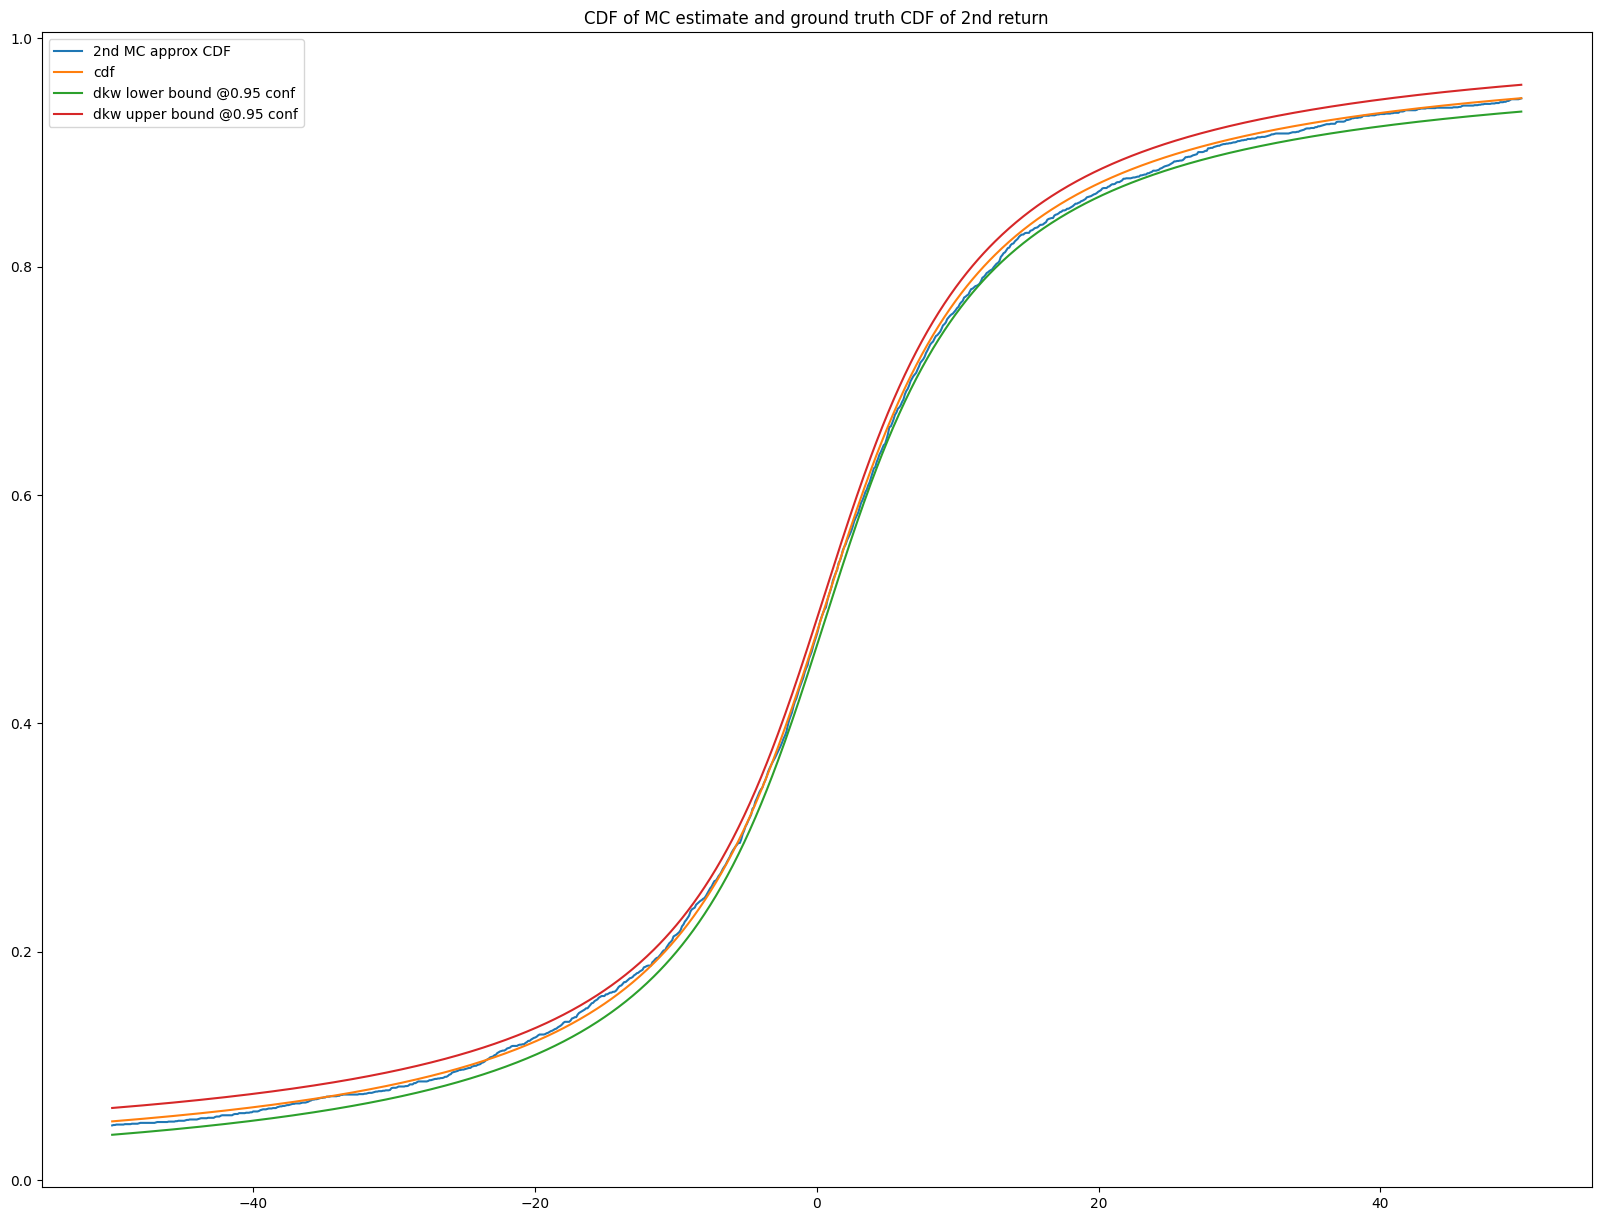

In [11]:
plt.figure(figsize=(20,15))
plt.title("CDF of MC estimate and ground truth CDF of 2nd return")
plt.plot(xvals, cau_ret_est_mc[cau_states[2]].cdf(xvals), label="2nd MC approx CDF")
cdf, lb, ub = dkw_bounds(gt_cau_ret_distr_fun[cau_states[2]].cdf, xvals, cau_num_mc, 0.95)
plt.plot(xvals, cdf, label="cdf")
plt.plot(xvals, lb, label=f"dkw lower bound @{confidence_level} conf")
plt.plot(xvals, ub, label=f"dkw upper bound @{confidence_level} conf")
plt.legend()

In [12]:
print(
    "Extended 2-Birnbaum-Orlicz Distance:",
    f"{extended_metric(birnb_orl_avg_dist_beta,gt_cau_ret_distr_fun.distr, cau_ret_est_mc.distr, beta=2)}"
    )
print(
    "Extended Kolmogorov-Smirnoff-distance",
    f"{extended_metric(birnb_orl_avg_dist_beta,gt_cau_ret_distr_fun.distr, cau_ret_est_mc.distr, beta=np.inf)}"
    )
print(f"MC sim runtime: {cau_time_mc}")
print(f"MC estimate number of atoms / distribution: {cau_num_mc}")

Extended 2-Birnbaum-Orlicz Distance: 0.2862217614207924
Extended Kolmogorov-Smirnoff-distance 0.07037037037037008
MC sim runtime: 40.949179887771606
MC estimate number of atoms / distribution: 2700


### Running MC sim to match size of final return distribution function estimate
- run MC simulation generating a total of 15625 trajectories per state

In [13]:
confidence_level = 0.95 # used for dkw bounds
cau_num_mc_match = 15625
start_time = time.time()
cau_ret_est_mc = monte_carlo_eval(cau_mdp, cau_num_mc_match, 30)
stop_time = time.time()
cau_time_mc_match = stop_time - start_time
print(f"MC sim runtime: {cau_time_mc_match}")

MC sim runtime: 240.25484490394592


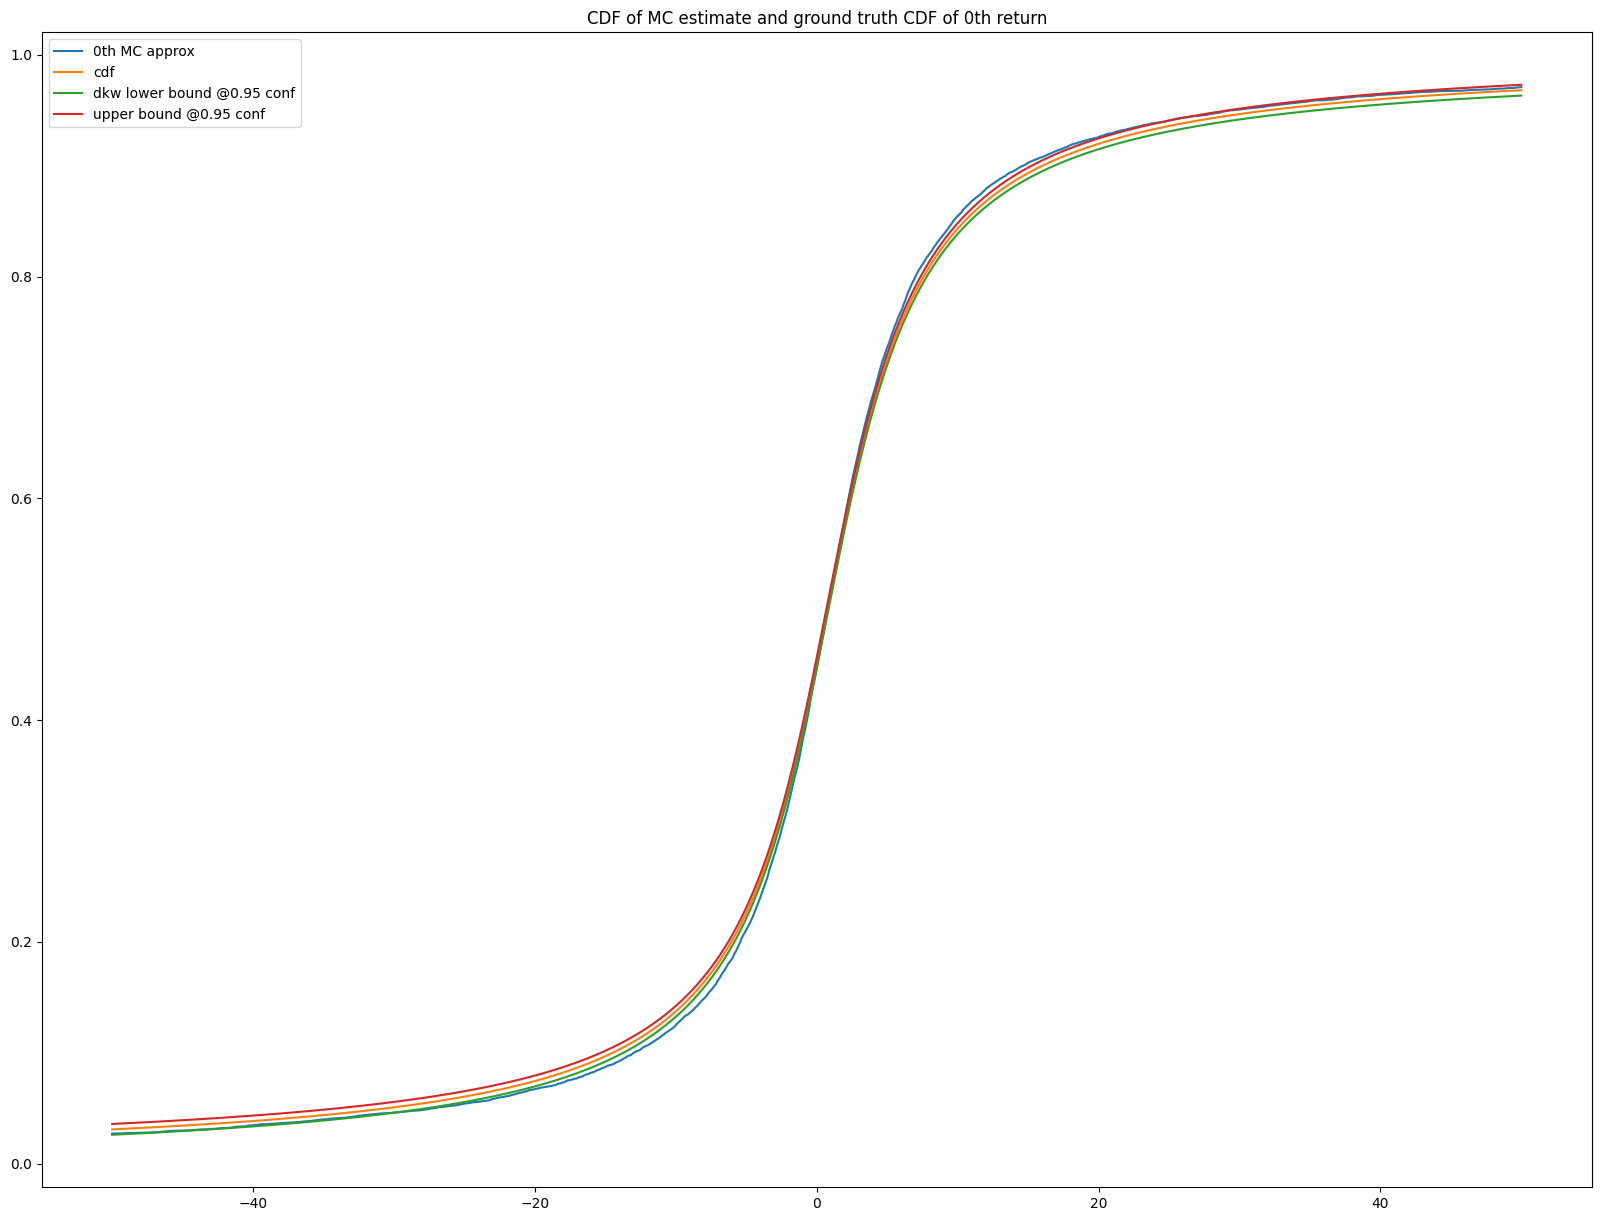

In [19]:
plt.figure(figsize=(20,15))
plt.title("CDF of MC estimate and ground truth CDF of 0th return")
plt.plot(xvals, cau_ret_est_mc[cau_states[0]].cdf(xvals), label="0th MC approx")
cdf, lb, ub = dkw_bounds(gt_cau_ret_distr_fun[cau_states[0]].cdf, xvals, cau_num_mc_match, confidence_level)
# plt.plot(r1_cauchy[0], n1.cdf(r1_cauchy[0]), label="real")
plt.plot(xvals, cdf, label="cdf")
plt.plot(xvals, lb, label=f"dkw lower bound @{confidence_level} conf")
plt.plot(xvals, ub, label=f"upper bound @{confidence_level} conf")
plt.legend()

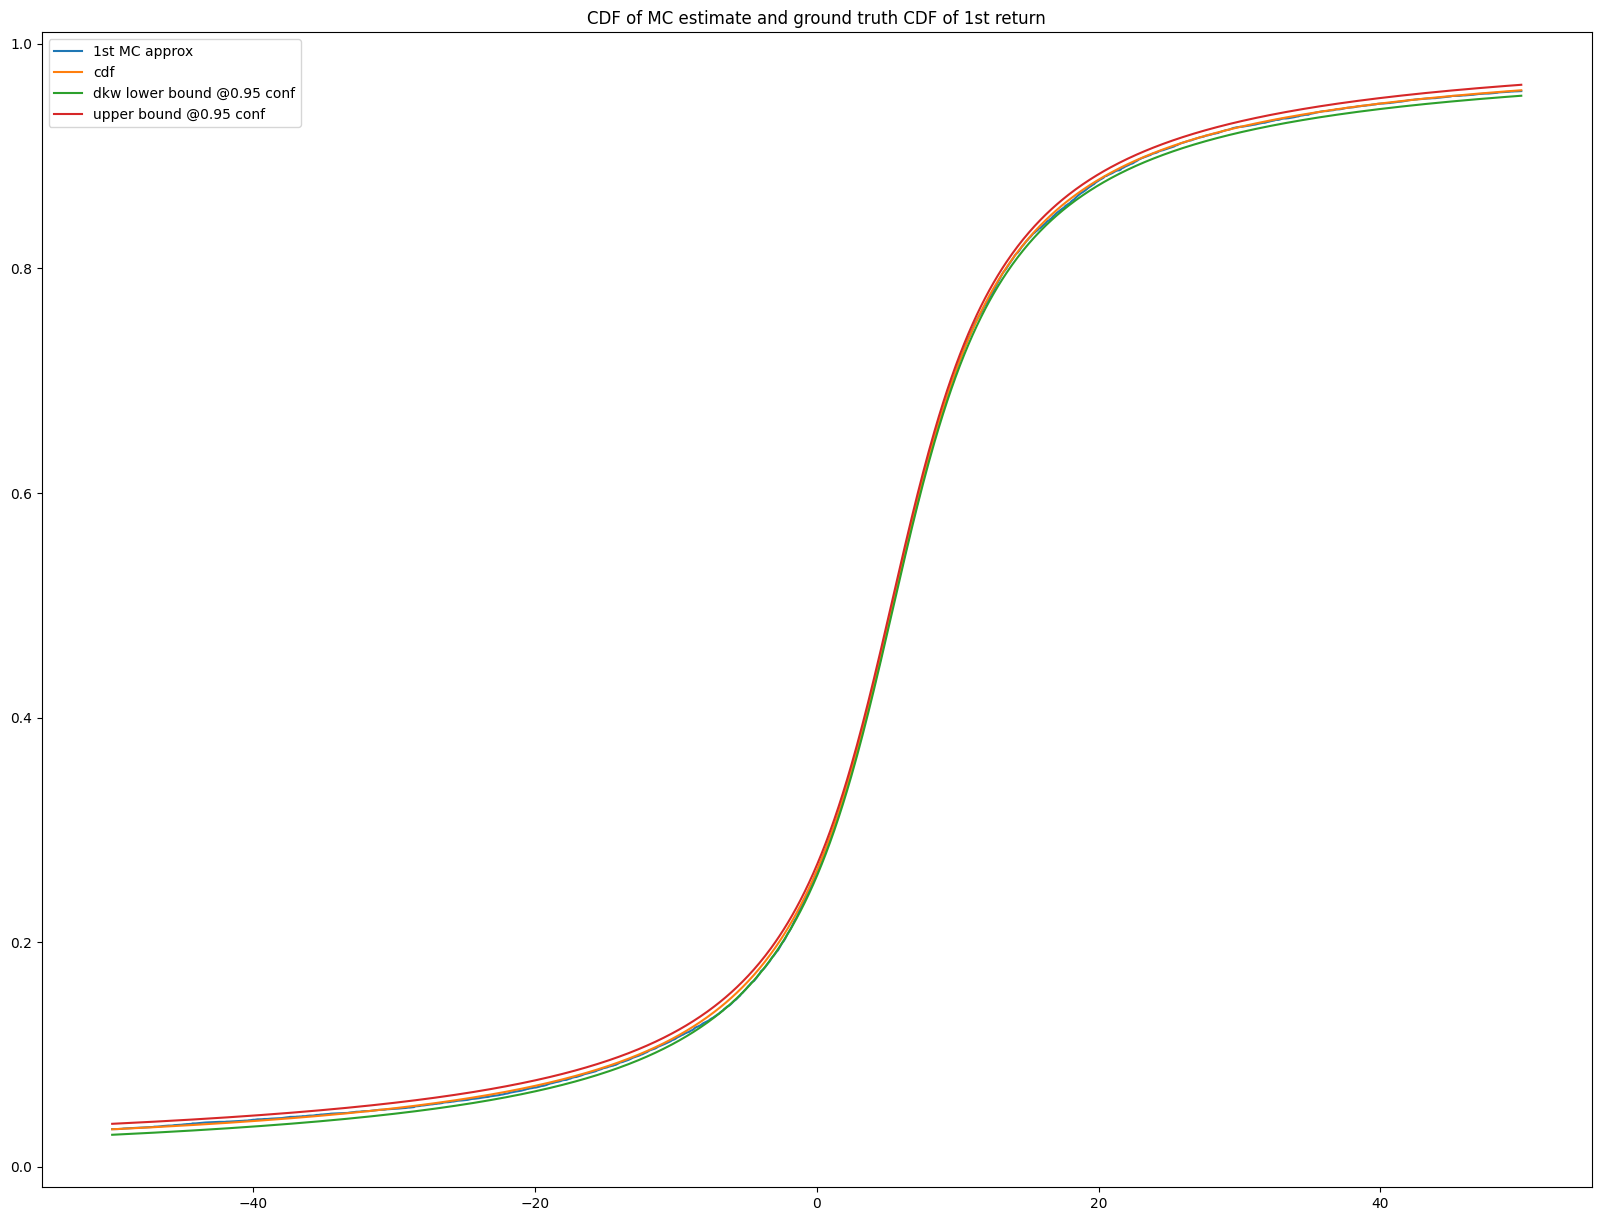

In [20]:
plt.figure(figsize=(20,15))
plt.title("CDF of MC estimate and ground truth CDF of 1st return")
plt.plot(xvals, cau_ret_est_mc[cau_states[1]].cdf(xvals), label="1st MC approx")
cdf, lb, ub = dkw_bounds(gt_cau_ret_distr_fun[cau_states[1]].cdf, xvals, cau_num_mc_match, confidence_level)
# plt.plot(r1_cauchy[0], n1.cdf(r1_cauchy[0]), label="real")
plt.plot(xvals, cdf, label="cdf")
plt.plot(xvals, lb, label=f"dkw lower bound @{confidence_level} conf")
plt.plot(xvals, ub, label=f"upper bound @{confidence_level} conf")
plt.legend()

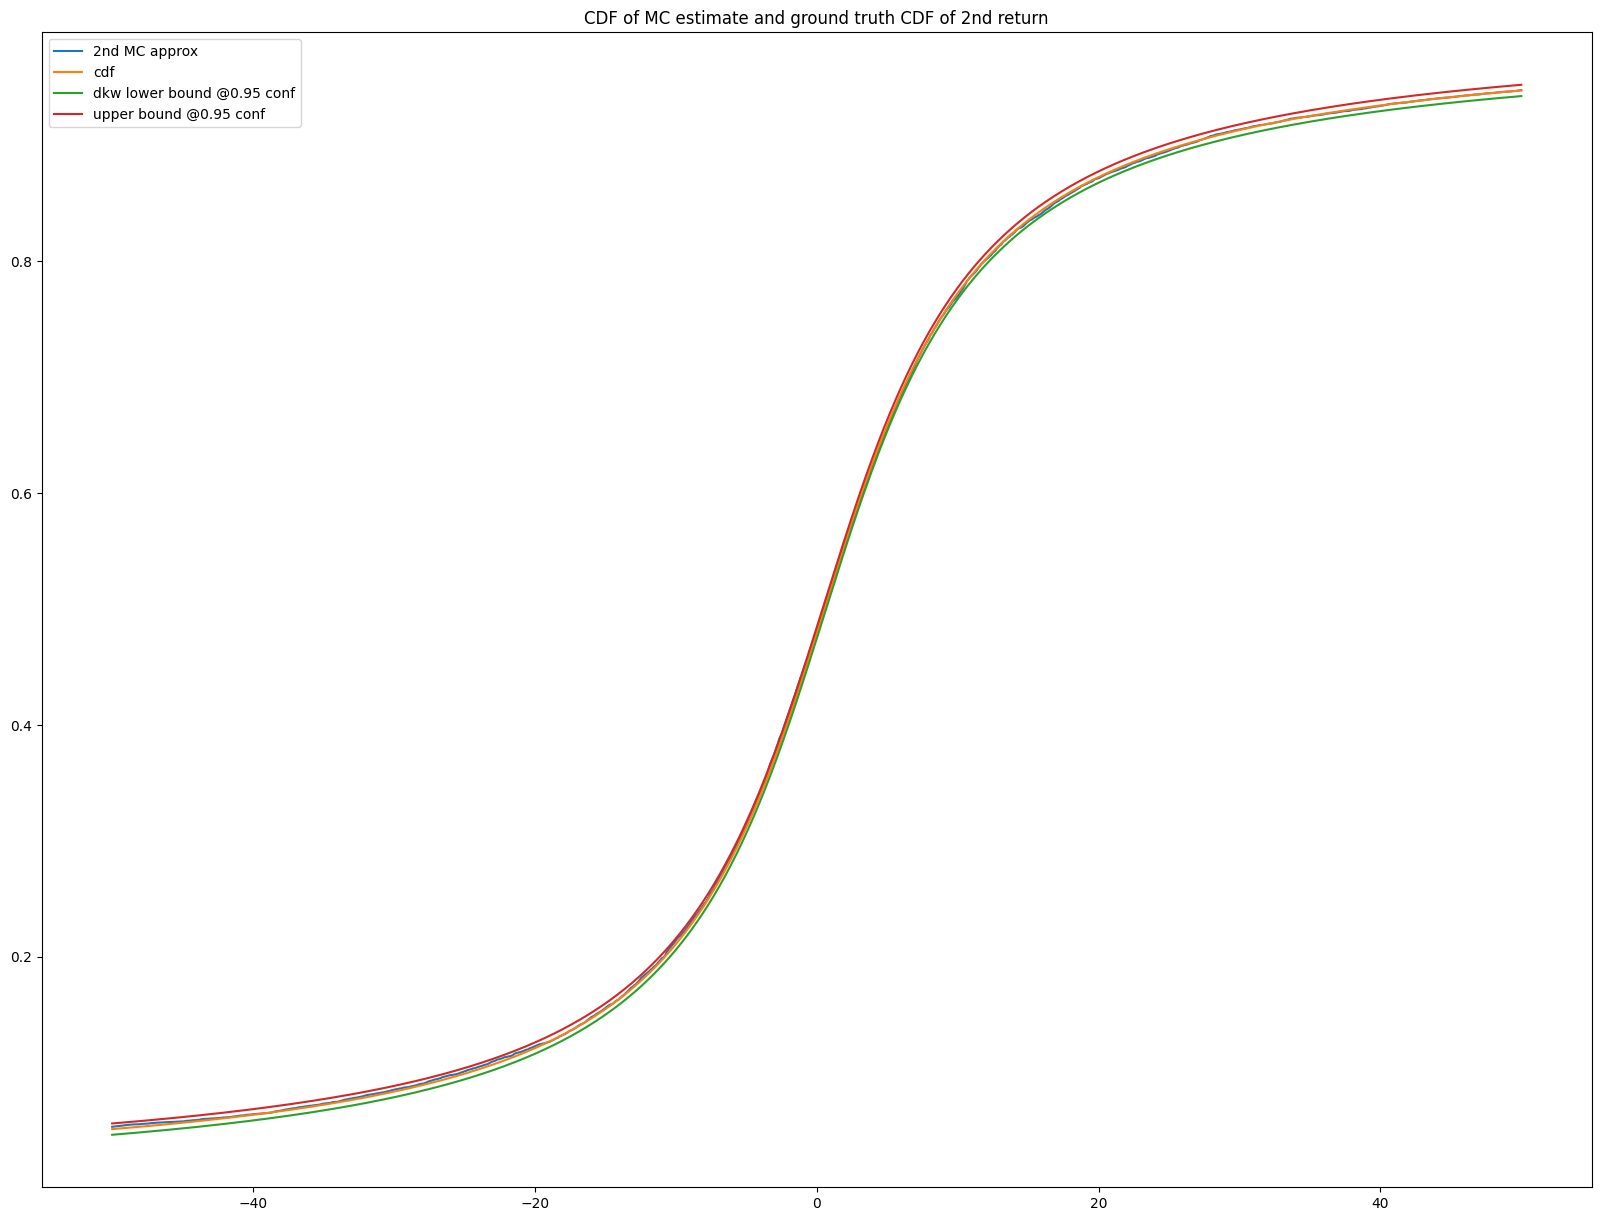

In [21]:
plt.figure(figsize=(20,15))
plt.title("CDF of MC estimate and ground truth CDF of 2nd return")
plt.plot(xvals, cau_ret_est_mc[cau_states[2]].cdf(xvals), label="2nd MC approx")
cdf, lb, ub = dkw_bounds(gt_cau_ret_distr_fun[cau_states[2]].cdf, xvals, cau_num_mc_match, confidence_level)
# plt.plot(r1_cauchy[0], n1.cdf(r1_cauchy[0]), label="real")
plt.plot(xvals, cdf, label="cdf")
plt.plot(xvals, lb, label=f"dkw lower bound @{confidence_level} conf")
plt.plot(xvals, ub, label=f"upper bound @{confidence_level} conf")
plt.legend()

In [23]:
print(
    "Extended 2-Birnbaum-Orlicz Distance:",
    f"{extended_metric(birnb_orl_avg_dist_beta,gt_cau_ret_distr_fun.distr, cau_ret_est_mc.distr, beta=2)}"
    )
print(
    "Extended Kolmogorov-Smirnov Distance",
    f"{extended_metric(birnb_orl_avg_dist_beta,gt_cau_ret_distr_fun.distr, cau_ret_est_mc.distr, beta=np.inf)}"
    )
print(f"MC sim runtime: {cau_time_mc_match}")
print(f"MC estimate number of atoms / distribution: {cau_num_mc_match}")

Extended 2-Birnbaum-Orlicz Distance: 0.30903506363681316
Extended Kolmogorov-Smirnov Distance 0.04504000000000019
MC sim runtime: 240.25484490394592
MC estimate number of atoms / distribution: 15625


In [18]:
extended_metric(birnb_orl_avg_dist_beta, cau_ret_est_mc.distr, gt_cau_ret_distr_fun.distr, beta=2)

np.float64(0.5404359255381508)

# Projections

In this section, different projections are compared on the Cyclical Environment with normally distributed rewards.

The following choices are compared for the parameter algorithms (guided by the theoretical results):
- $\Pi_{\text{in}} = \Pi_{\Pi_{\text{q}}}$, $\Pi_{\text{out}} = \Pi_{\Pi_{\text{q}}}$ with size functions $M_{\text{in}}(n) \coloneqq n^{2}$, $M_{\text{out}}(n) \coloneqq n^{4}$

- $\Pi_{\text{in}} = \Pi_{\Pi_{\text{rand}}}$, $\Pi_{\text{out}} = \Pi_{\Pi_{\text{q}}}$ with size functions $M_{\text{in}}(n) \coloneqq n^{2}$, $M_{\text{out}}(n) \coloneqq n^{4}$

- $\Pi_{\text{in}} = \Pi_{\Pi_{\text{CDF}}}$, $\Pi_{\text{out}} = \Pi_{\Pi_{\text{q}}}$ with size functions $M_{\text{out}}(n) \coloneqq n^{2}$ and to produce the inner parameter we use the 
- algorithm $A_{\text{CDF, 1}}$


In [38]:
from src.projections import RandomProjection, QuantileProjection, GridValueProjection
from src.param_algorithms import (
    combine_to_param_algo,
    param_algo_from_size_fun,
    SizeFun,
    DecayFun,
    algo_cdf_1,
    algo_cdf_2,
    plain_parameter_algorithm
    )

In [39]:
from src.sample_envs import cyclical_env
from src.sample_envs import cyclical_real_return_distr_fun as gt_n_ret_distr_fun
n_ret_est = ReturnDistributionFunction(
    states=cyclical_env.mdp.states,
    distributions=[DiscreteRV(xk=np.array([0]), pk=np.array([1])) 
                   for _ in cyclical_env.mdp.states]
)

n_ret_est_cp = deepcopy(n_ret_est)
n_mdp = cyclical_env.mdp
n_states = n_mdp.states
# ground truth return distribitutions for the three states
gt_n0 = sp.norm(loc=0.761, scale=np.sqrt(2.380))
gt_n1 = sp.norm(loc=5.373, scale=np.sqrt(2.816))
gt_n2 = sp.norm(loc=0.533, scale=np.sqrt(1.666))

## Quantile-Quantile-Projection

$\Pi_{\text{in}} = \Pi_{\Pi_{\text{q}}}$, $\Pi_{\text{out}} = \Pi_{\Pi_{\text{q}}}$ with size functions $M_{\text{in}}(n) \coloneqq n^{2}$, $M_{\text{out}}(n) \coloneqq n^{4}$

In [40]:
poly2 = functools.partial(SizeFun.POLY, 2)
poly4 = functools.partial(SizeFun.POLY, 4)

param_algo_qq_poly2_poly4 = combine_to_param_algo(
    transform_to_param_algo(
        param_algo_from_size_fun,
        size_fun=poly2),
    transform_to_param_algo(
        param_algo_from_size_fun,
        size_fun=poly4,
        distr_coll=None)
    )

In [41]:
n_ret_est = deepcopy(n_ret_est_cp)

# warmup
for i in range(1,4):
    n_ret_est = ddp(
        cyclical_env.mdp,
        QuantileProjection,
        QuantileProjection,
        param_algo_qq_poly2_poly4,
        n_ret_est,
        cyclical_env.mdp.rewards,
        i
        )

# resetting return distribution estimate
n_ret_est = deepcopy(n_ret_est_cp)

start = time.time()
for i in range(1, 17):
    n_ret_est = ddp(
        cyclical_env.mdp,
        QuantileProjection,
        QuantileProjection,
        param_algo_qq_poly2_poly4,
        n_ret_est,
        cyclical_env.mdp.rewards,
        i
        )
    print(f"Iteration {i} of DDP completed.")
stop = time.time()
print(f"Duration: {stop - start}")

Iteration 1 of DDP completed.
Iteration 2 of DDP completed.
Iteration 3 of DDP completed.
Iteration 4 of DDP completed.
Iteration 5 of DDP completed.
Iteration 6 of DDP completed.
Iteration 7 of DDP completed.
Iteration 8 of DDP completed.
Iteration 9 of DDP completed.
Iteration 10 of DDP completed.
Iteration 11 of DDP completed.
Iteration 12 of DDP completed.
Iteration 13 of DDP completed.
Iteration 14 of DDP completed.
Iteration 15 of DDP completed.
Iteration 16 of DDP completed.
Duration: 87.14874291419983


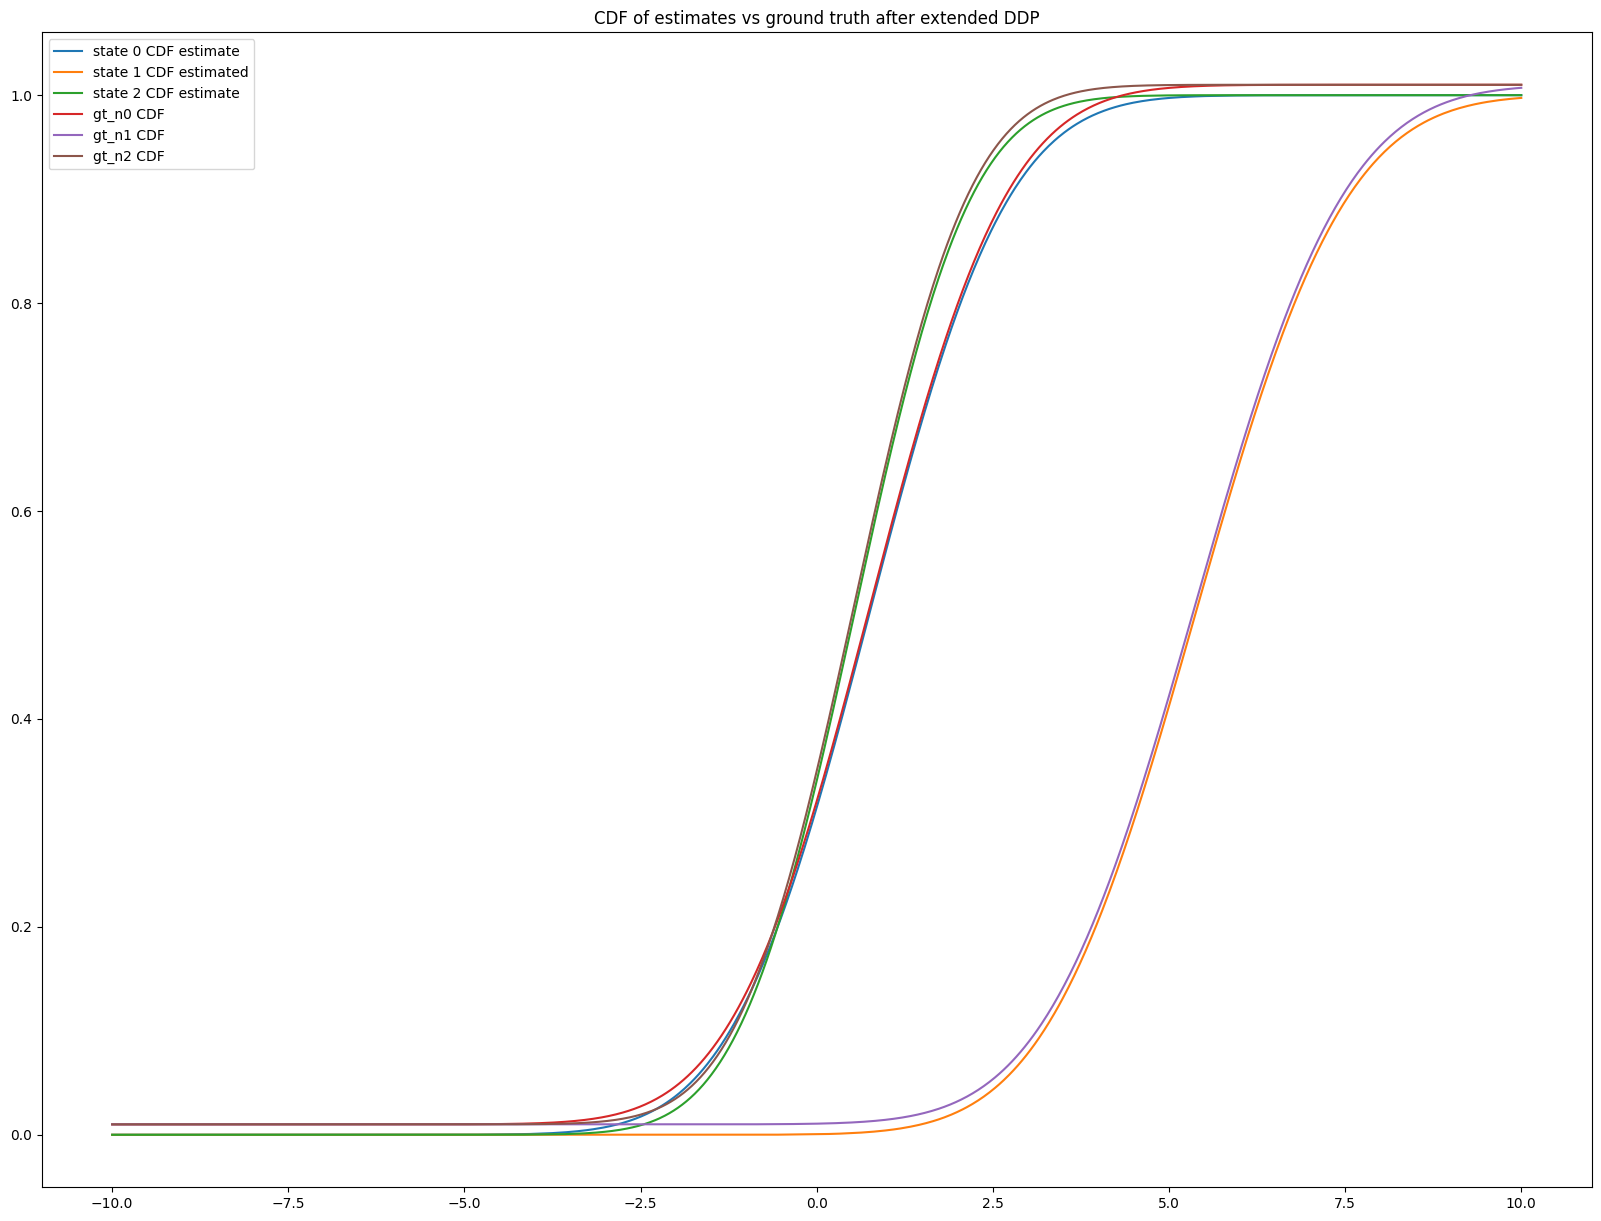

In [42]:
n_est_0 = n_ret_est[n_states[0]]
n_est_1 = n_ret_est[n_states[1]]
n_est_2 = n_ret_est[n_states[2]]


common_support = np.linspace(-10, 10, 1000)

plt.figure(figsize=(20,15))
plt.title("CDF of estimates vs ground truth after extended DDP")
plt.plot(common_support, n_est_0.cdf(common_support), label="state 0 CDF estimate")
plt.plot(common_support, n_est_1.cdf(common_support), label="state 1 CDF estimated")
plt.plot(common_support, n_est_2.cdf(common_support), label="state 2 CDF estimate")

plt.plot(np.linspace(-10,10, 1000), gt_n0.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n0 CDF")
plt.plot(np.linspace(-10,10, 1000), gt_n1.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n1 CDF")
plt.plot(np.linspace(-10,10, 1000), gt_n2.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n2 CDF")
plt.legend()

In [43]:
n_w1_bar = extended_metric(wasserstein_beta, gt_n_ret_distr_fun.distr, n_ret_est.distr)
print(f"Extended 1-Wasserstein Distance: {n_w1_bar}")
print(f"Max Distribution Size: {n_ret_est.get_max_size()}")

Extended 1-Wasserstein Distance: 0.018209230646912822
Max Distribution Size: 65536



## Quantile-Quantile-Projection

$\Pi_{\text{in}} = \Pi_{\Pi_{\text{q}}}$, $\Pi_{\text{out}} = \Pi_{\Pi_{\text{q}}}$ with size functions $M_{\text{in}}(n) \coloneqq n^{2}$, $M_{\text{out}}(n) \coloneqq n^{2}$

In [44]:
poly2 = functools.partial(SizeFun.POLY, 2)

param_algo_qq_poly2_poly2 = combine_to_param_algo(
    transform_to_param_algo(
        param_algo_from_size_fun,
        size_fun=poly2),
    transform_to_param_algo(
        param_algo_from_size_fun,
        size_fun=poly2,
        distr_coll=None)
    )

In [45]:
n_ret_est = deepcopy(n_ret_est_cp)

# warmup
for i in range(1,4):
    n_ret_est = ddp(
        cyclical_env.mdp,
        QuantileProjection,
        QuantileProjection,
        param_algo_qq_poly2_poly2,
        n_ret_est,
        cyclical_env.mdp.rewards,
        i
        )

# resetting return distribution estimate
n_ret_est = deepcopy(n_ret_est_cp)

start = time.time()
for i in range(1, 47):
    n_ret_est = ddp(
        cyclical_env.mdp,
        QuantileProjection,
        QuantileProjection,
        param_algo_qq_poly2_poly2,
        n_ret_est,
        cyclical_env.mdp.rewards,
        i
        )
    print(f"Iteration {i} of DDP completed.")
stop = time.time()
print(f"Duration: {stop - start}")

Iteration 1 of DDP completed.
Iteration 2 of DDP completed.
Iteration 3 of DDP completed.
Iteration 4 of DDP completed.
Iteration 5 of DDP completed.
Iteration 6 of DDP completed.
Iteration 7 of DDP completed.
Iteration 8 of DDP completed.
Iteration 9 of DDP completed.
Iteration 10 of DDP completed.
Iteration 11 of DDP completed.
Iteration 12 of DDP completed.
Iteration 13 of DDP completed.
Iteration 14 of DDP completed.
Iteration 15 of DDP completed.
Iteration 16 of DDP completed.
Iteration 17 of DDP completed.
Iteration 18 of DDP completed.
Iteration 19 of DDP completed.
Iteration 20 of DDP completed.
Iteration 21 of DDP completed.
Iteration 22 of DDP completed.
Iteration 23 of DDP completed.
Iteration 24 of DDP completed.
Iteration 25 of DDP completed.
Iteration 26 of DDP completed.
Iteration 27 of DDP completed.
Iteration 28 of DDP completed.
Iteration 29 of DDP completed.
Iteration 30 of DDP completed.
Iteration 31 of DDP completed.
Iteration 32 of DDP completed.
Iteration 33 of D

Extended 1-Wasserstein Distance: 0.0016503105291994155
Max Distribution Size: 2116
Runtime of extended DDP: 41.19503998756409 seconds


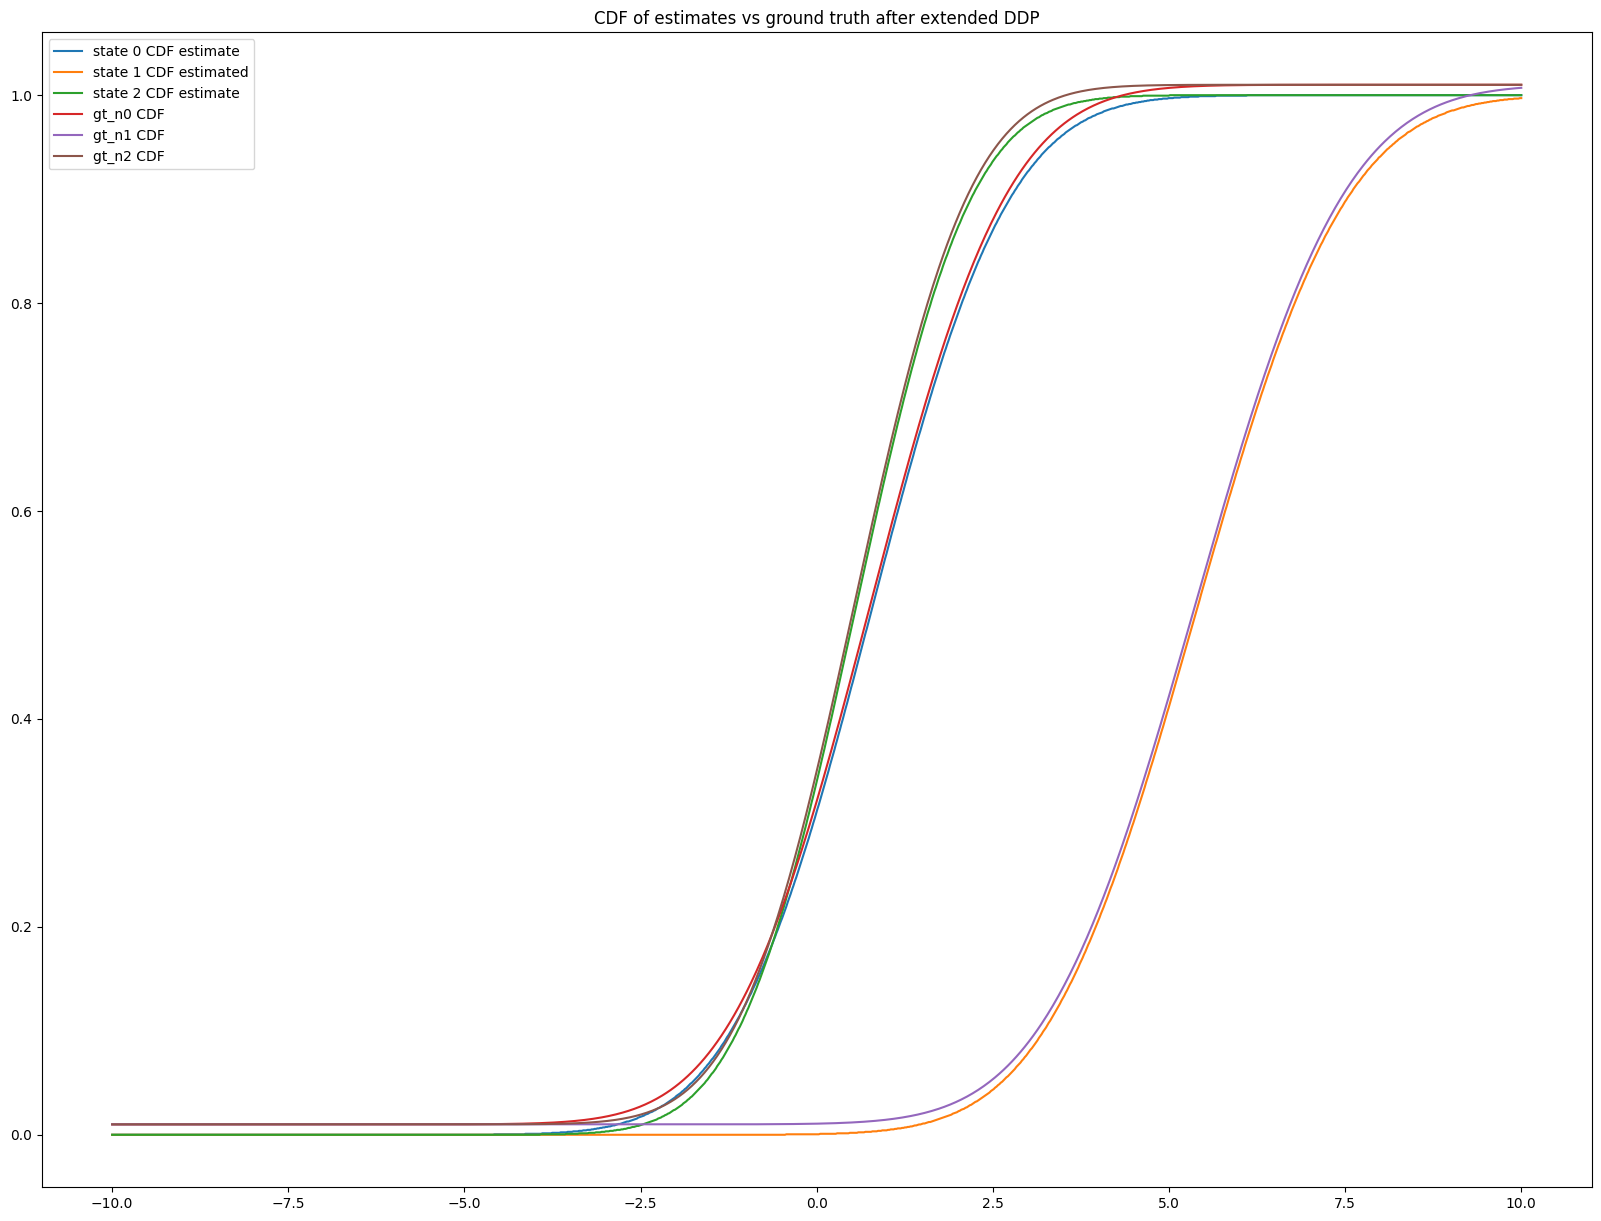

In [46]:
n_est_0 = n_ret_est[n_states[0]]
n_est_1 = n_ret_est[n_states[1]]
n_est_2 = n_ret_est[n_states[2]]


common_support = np.linspace(-10, 10, 1000)

plt.figure(figsize=(20,15))
plt.title("CDF of estimates vs ground truth after extended DDP")
plt.plot(common_support, n_est_0.cdf(common_support), label="state 0 CDF estimate")
plt.plot(common_support, n_est_1.cdf(common_support), label="state 1 CDF estimated")
plt.plot(common_support, n_est_2.cdf(common_support), label="state 2 CDF estimate")

plt.plot(np.linspace(-10,10, 1000), gt_n0.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n0 CDF")
plt.plot(np.linspace(-10,10, 1000), gt_n1.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n1 CDF")
plt.plot(np.linspace(-10,10, 1000), gt_n2.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n2 CDF")
plt.legend()


n_w1_bar = extended_metric(wasserstein_beta, gt_n_ret_distr_fun.distr, n_ret_est.distr)
print(f"Extended 1-Wasserstein Distance: {n_w1_bar}")
print(f"Max Distribution Size: {n_ret_est.get_max_size()}")
print(f"Runtime of extended DDP: {stop-start} seconds")

## Quantile-Quantile-Projection

$\Pi_{\text{in}} = \Pi_{\Pi_{\text{q}}}$, $\Pi_{\text{out}} = \Pi_{\Pi_{\text{q}}}$ with size functions $M_{\text{in}}(n) \coloneqq n^{3}$, $M_{\text{out}}(n) \coloneqq n^{2}$

In [45]:
# param algo spec
poly2 = functools.partial(SizeFun.POLY, 2)
poly3 = functools.partial(SizeFun.POLY, 3)

param_algo_qq_poly3_poly2 = combine_to_param_algo(
    transform_to_param_algo(
        param_algo_from_size_fun,
        size_fun=poly3),
    transform_to_param_algo(
        param_algo_from_size_fun,
        size_fun=poly2,
        distr_coll=None)
    )

n_ret_est = deepcopy(n_ret_est_cp)
# warmup
for i in range(1,4):
    n_ret_est = ddp(
        cyclical_env.mdp,
        QuantileProjection,
        QuantileProjection,
        param_algo_qq_poly3_poly2,
        n_ret_est,
        cyclical_env.mdp.rewards,
        i
        )

# resetting return distribution estimate
n_ret_est = deepcopy(n_ret_est_cp)

start = time.time()
for i in range(1, 25):
    n_ret_est = ddp(
        cyclical_env.mdp,
        QuantileProjection,
        QuantileProjection,
        param_algo_qq_poly3_poly2,
        n_ret_est,
        cyclical_env.mdp.rewards,
        i
        )
    print(f"Iteration {i} of DDP completed.")
stop = time.time()
print(f"Duration: {stop - start}")

Iteration 1 of DDP completed.
Iteration 2 of DDP completed.
Iteration 3 of DDP completed.
Iteration 4 of DDP completed.
Iteration 5 of DDP completed.
Iteration 6 of DDP completed.
Iteration 7 of DDP completed.
Iteration 8 of DDP completed.
Iteration 9 of DDP completed.
Iteration 10 of DDP completed.
Iteration 11 of DDP completed.
Iteration 12 of DDP completed.
Iteration 13 of DDP completed.
Iteration 14 of DDP completed.
Iteration 15 of DDP completed.
Iteration 16 of DDP completed.
Iteration 17 of DDP completed.
Iteration 18 of DDP completed.
Iteration 19 of DDP completed.
Iteration 20 of DDP completed.
Iteration 21 of DDP completed.
Iteration 22 of DDP completed.
Iteration 23 of DDP completed.
Iteration 24 of DDP completed.
Duration: 34.84256172180176


Extended 1-Wasserstein Distance: 0.005603576763647868
Extended Kolmogorov Smirnov Distance: 0.051736111111111205
Max Distribution Size: 576
Runtime of extended DDP: 34.84256172180176 seconds


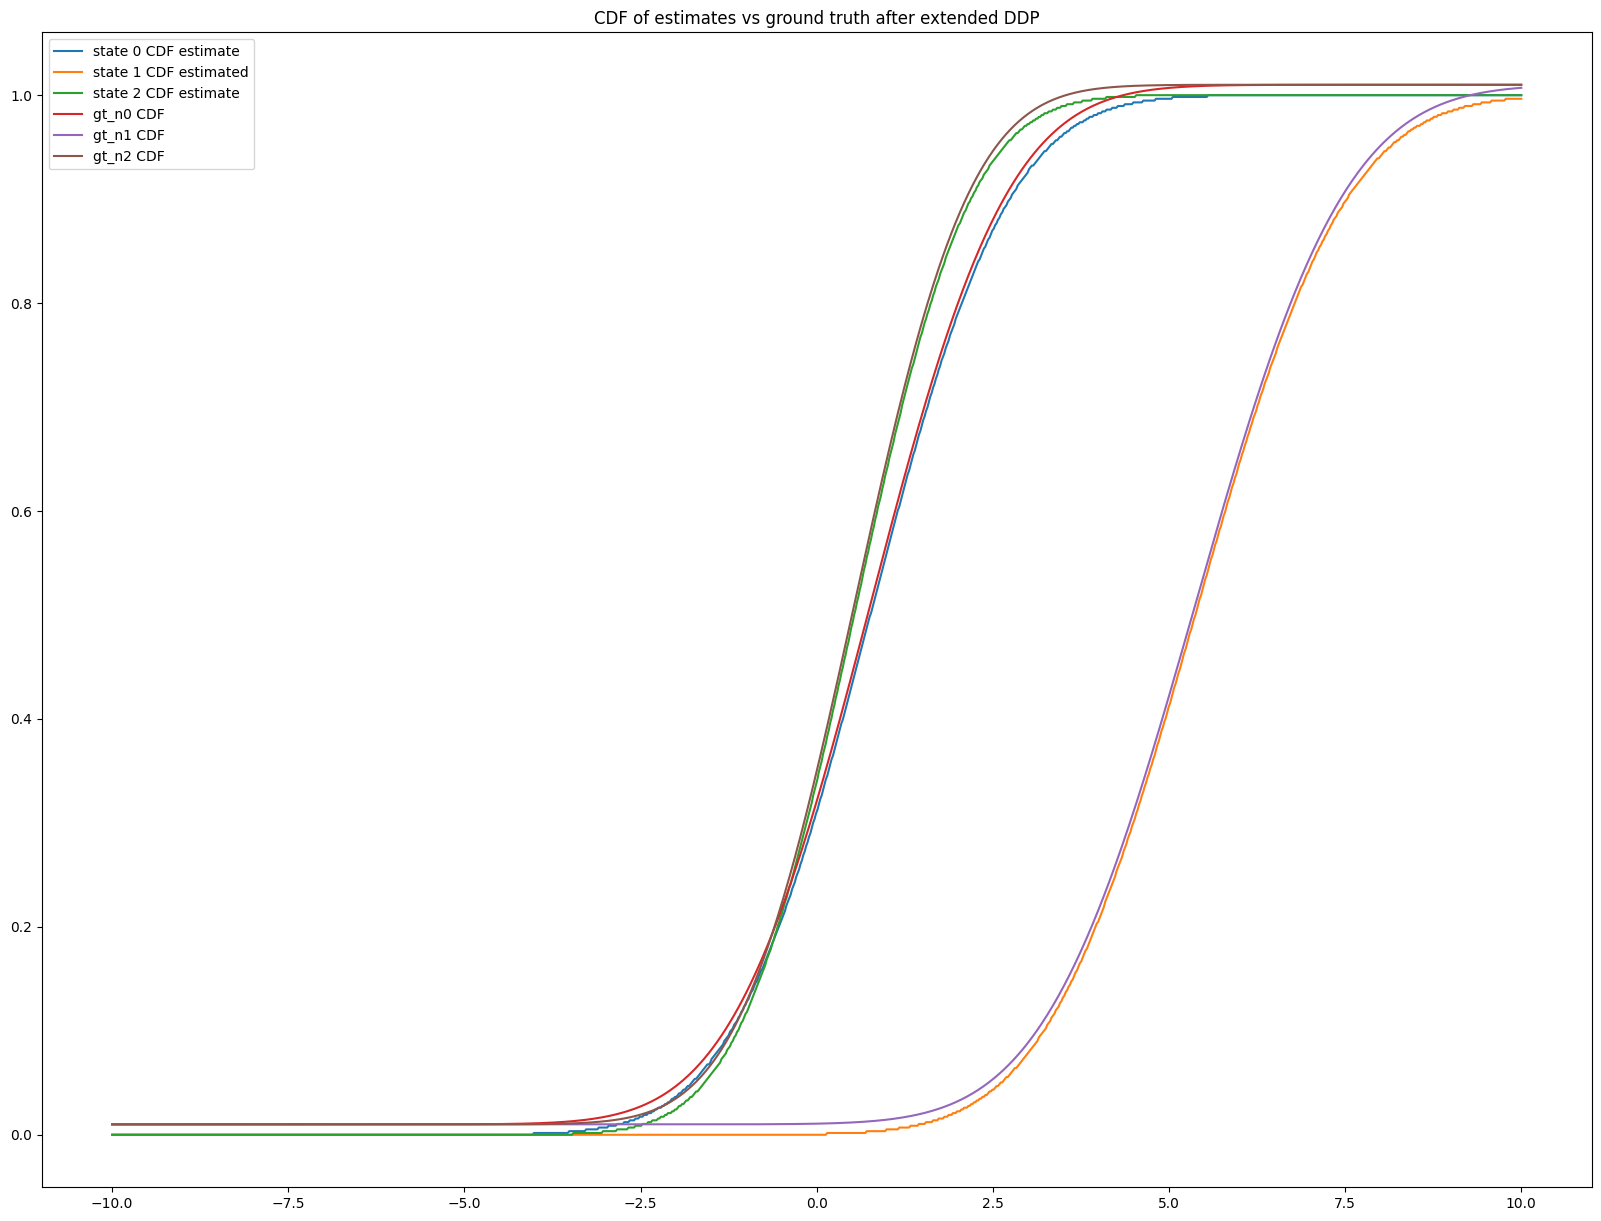

In [47]:
n_est_0 = n_ret_est[n_states[0]]
n_est_1 = n_ret_est[n_states[1]]
n_est_2 = n_ret_est[n_states[2]]


common_support = np.linspace(-10, 10, 1000)

plt.figure(figsize=(20,15))
plt.title("CDF of estimates vs ground truth after extended DDP")
plt.plot(common_support, n_est_0.cdf(common_support), label="state 0 CDF estimate")
plt.plot(common_support, n_est_1.cdf(common_support), label="state 1 CDF estimated")
plt.plot(common_support, n_est_2.cdf(common_support), label="state 2 CDF estimate")

plt.plot(np.linspace(-10,10, 1000), gt_n0.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n0 CDF")
plt.plot(np.linspace(-10,10, 1000), gt_n1.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n1 CDF")
plt.plot(np.linspace(-10,10, 1000), gt_n2.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n2 CDF")
plt.legend()


n_w1_bar = extended_metric(wasserstein_beta, gt_n_ret_distr_fun.distr, n_ret_est.distr)
n_linf_bar = extended_metric(birnb_orl_avg_dist_beta, gt_n_ret_distr_fun.distr, n_ret_est.distr, np.inf)
print(f"Extended 1-Wasserstein Distance: {n_w1_bar}")
print(f"Extended Kolmogorov Smirnov Distance: {n_linf_bar}")
print(f"Max Distribution Size: {n_ret_est.get_max_size()}")
print(f"Runtime of extended DDP: {stop-start} seconds")

## Quantile-Quantile-Projection

$\Pi_{\text{in}} = \Pi_{\Pi_{\text{q}}}$, $\Pi_{\text{out}} = \Pi_{\Pi_{\text{q}}}$ with size functions $M_{\text{in}}(n) \coloneqq n^{2}$, $M_{\text{out}}(n) \coloneqq n^{3}$

In [49]:

# param algo spec
poly2 = functools.partial(SizeFun.POLY, 2)
poly3 = functools.partial(SizeFun.POLY, 3)

param_algo_qq_poly2_poly3 = combine_to_param_algo(
    transform_to_param_algo(
        param_algo_from_size_fun,
        size_fun=poly2),
    transform_to_param_algo(
        param_algo_from_size_fun,
        size_fun=poly3,
        distr_coll=None)
    )

n_ret_est = deepcopy(n_ret_est_cp)
# warmup
for i in range(1,4):
    n_ret_est = ddp(
        cyclical_env.mdp,
        QuantileProjection,
        QuantileProjection,
        param_algo_qq_poly2_poly3,
        n_ret_est,
        cyclical_env.mdp.rewards,
        i
        )

# resetting return distribution estimate
n_ret_est = deepcopy(n_ret_est_cp)

start = time.time()
for i in range(1, 26):
    n_ret_est = ddp(
        cyclical_env.mdp,
        QuantileProjection,
        QuantileProjection,
        param_algo_qq_poly2_poly3,
        n_ret_est,
        cyclical_env.mdp.rewards,
        i
        )
    print(f"Iteration {i} of DDP completed.")
stop = time.time()
print(f"Duration: {stop - start}")

Iteration 1 of DDP completed.
Iteration 2 of DDP completed.
Iteration 3 of DDP completed.
Iteration 4 of DDP completed.
Iteration 5 of DDP completed.
Iteration 6 of DDP completed.
Iteration 7 of DDP completed.
Iteration 8 of DDP completed.
Iteration 9 of DDP completed.
Iteration 10 of DDP completed.
Iteration 11 of DDP completed.
Iteration 12 of DDP completed.
Iteration 13 of DDP completed.
Iteration 14 of DDP completed.
Iteration 15 of DDP completed.
Iteration 16 of DDP completed.
Iteration 17 of DDP completed.
Iteration 18 of DDP completed.
Iteration 19 of DDP completed.
Iteration 20 of DDP completed.
Iteration 21 of DDP completed.
Iteration 22 of DDP completed.
Iteration 23 of DDP completed.
Iteration 24 of DDP completed.
Iteration 25 of DDP completed.
Duration: 36.99932074546814


Extended 1-Wasserstein Distance: 0.001303456890994064
Max Distribution Size: 15625
Runtime of extended DDP: 36.99932074546814 seconds


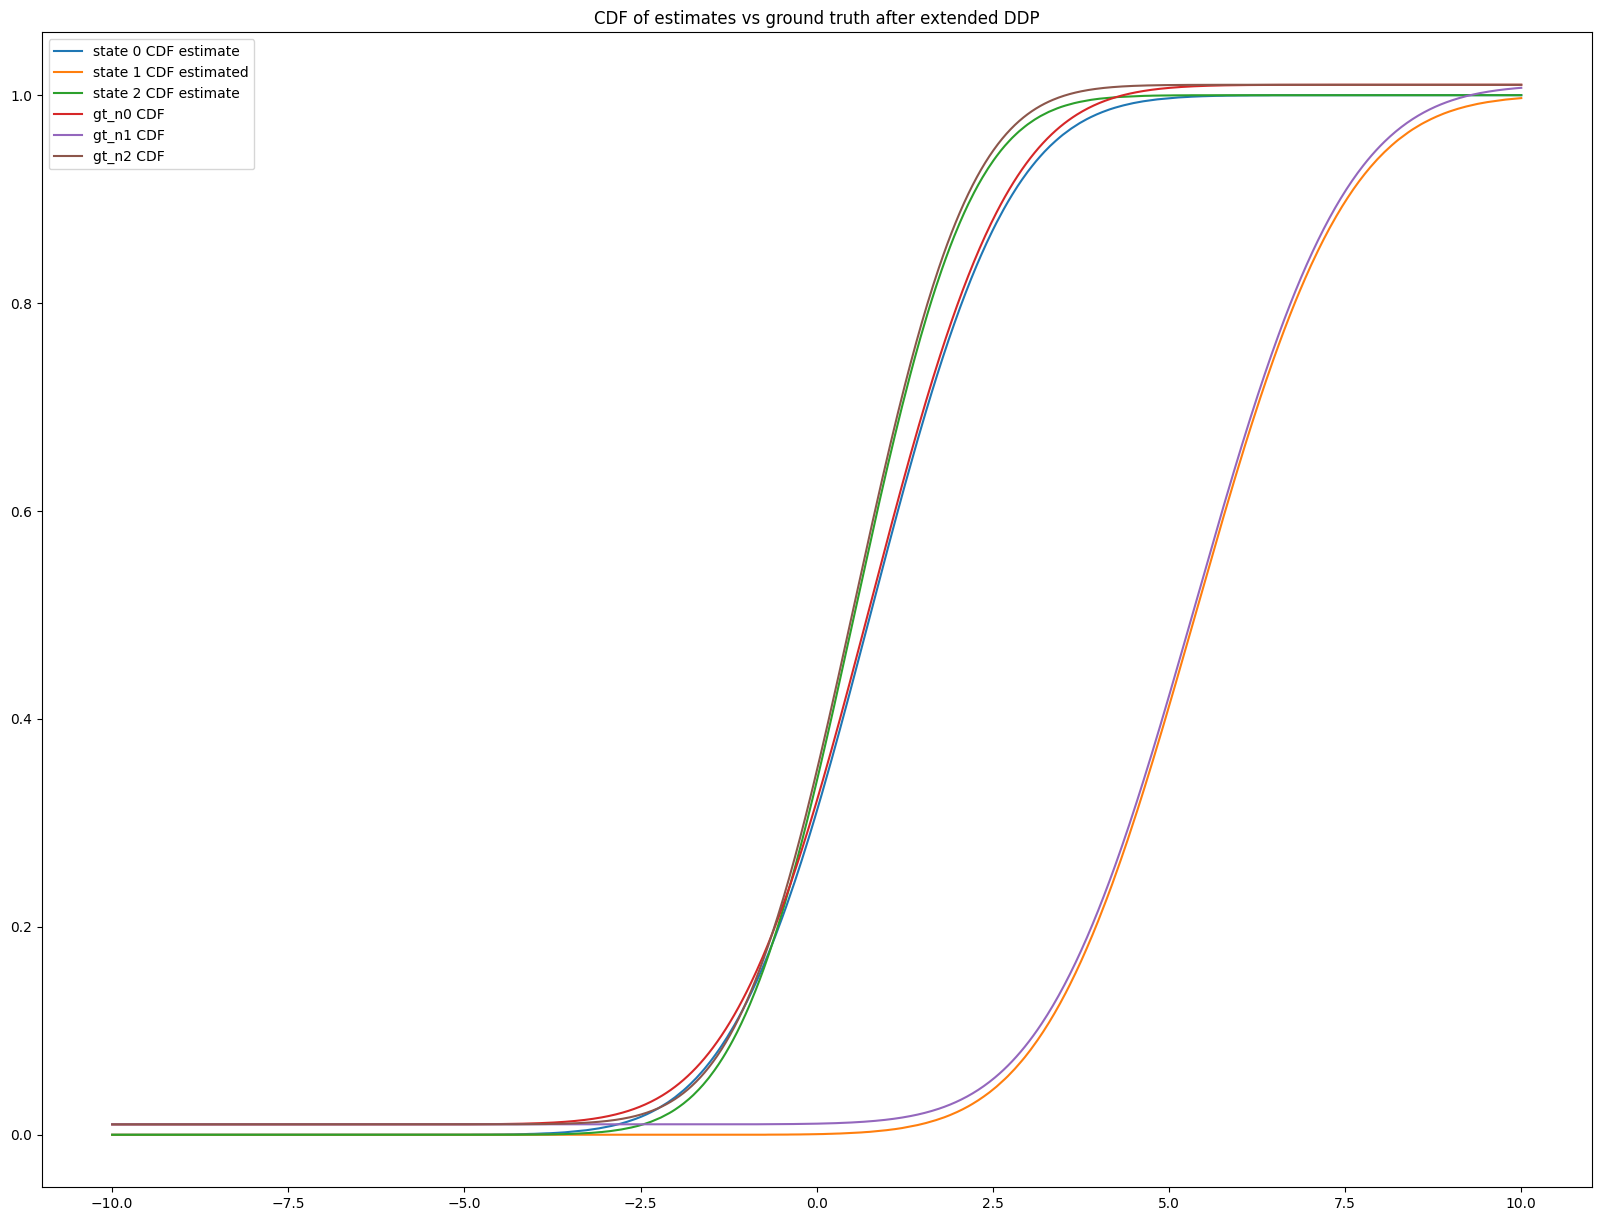

In [50]:
n_est_0 = n_ret_est[n_states[0]]
n_est_1 = n_ret_est[n_states[1]]
n_est_2 = n_ret_est[n_states[2]]


common_support = np.linspace(-10, 10, 1000)

plt.figure(figsize=(20,15))
plt.title("CDF of estimates vs ground truth after extended DDP")
plt.plot(common_support, n_est_0.cdf(common_support), label="state 0 CDF estimate")
plt.plot(common_support, n_est_1.cdf(common_support), label="state 1 CDF estimated")
plt.plot(common_support, n_est_2.cdf(common_support), label="state 2 CDF estimate")

plt.plot(np.linspace(-10,10, 1000), gt_n0.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n0 CDF")
plt.plot(np.linspace(-10,10, 1000), gt_n1.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n1 CDF")
plt.plot(np.linspace(-10,10, 1000), gt_n2.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n2 CDF")
plt.legend()


n_w1_bar = extended_metric(wasserstein_beta, gt_n_ret_distr_fun.distr, n_ret_est.distr)
print(f"Extended 1-Wasserstein Distance: {n_w1_bar}")
print(f"Max Distribution Size: {n_ret_est.get_max_size()}")
print(f"Runtime of extended DDP: {stop-start} seconds")

## Quantile-Quantile-Projection

$\Pi_{\text{in}} = \Pi_{\Pi_{\text{q}}}$, $\Pi_{\text{out}} = \Pi_{\Pi_{\text{q}}}$ with size functions $M_{\text{in}}(n) \coloneqq n^{1}$, $M_{\text{out}}(n) \coloneqq n^{2}$

In [51]:
# param algo spec
poly2 = functools.partial(SizeFun.POLY, 2)
poly1 = functools.partial(SizeFun.POLY, 1)

param_algo_qq_poly1_poly2 = combine_to_param_algo(
    transform_to_param_algo(
        param_algo_from_size_fun,
        size_fun=poly1),
    transform_to_param_algo(
        param_algo_from_size_fun,
        size_fun=poly2,
        distr_coll=None)
    )

n_ret_est = deepcopy(n_ret_est_cp)
# warmup
for i in range(1,4):
    n_ret_est = ddp(
        cyclical_env.mdp,
        QuantileProjection,
        QuantileProjection,
        param_algo_qq_poly1_poly2,
        n_ret_est,
        cyclical_env.mdp.rewards,
        i
        )

# resetting return distribution estimate
n_ret_est = deepcopy(n_ret_est_cp)

start = time.time()
for i in range(1, 122):
    n_ret_est = ddp(
        cyclical_env.mdp,
        QuantileProjection,
        QuantileProjection,
        param_algo_qq_poly1_poly2,
        n_ret_est,
        cyclical_env.mdp.rewards,
        i
        )
    print(f"Iteration {i} of DDP completed.")
    stop = time.time()
    if (stop - start) >= 45: break
print(f"Duration: {stop - start}")

Iteration 1 of DDP completed.
Iteration 2 of DDP completed.
Iteration 3 of DDP completed.
Iteration 4 of DDP completed.
Iteration 5 of DDP completed.
Iteration 6 of DDP completed.
Iteration 7 of DDP completed.
Iteration 8 of DDP completed.
Iteration 9 of DDP completed.
Iteration 10 of DDP completed.
Iteration 11 of DDP completed.
Iteration 12 of DDP completed.
Iteration 13 of DDP completed.
Iteration 14 of DDP completed.
Iteration 15 of DDP completed.
Iteration 16 of DDP completed.
Iteration 17 of DDP completed.
Iteration 18 of DDP completed.
Iteration 19 of DDP completed.
Iteration 20 of DDP completed.
Iteration 21 of DDP completed.
Iteration 22 of DDP completed.
Iteration 23 of DDP completed.
Iteration 24 of DDP completed.
Iteration 25 of DDP completed.
Iteration 26 of DDP completed.
Iteration 27 of DDP completed.
Iteration 28 of DDP completed.
Iteration 29 of DDP completed.
Iteration 30 of DDP completed.
Iteration 31 of DDP completed.
Iteration 32 of DDP completed.
Iteration 33 of D

Extended 1-Wasserstein Distance: 0.0044808675430660395
Max Distribution Size: 14641
Runtime of extended DDP: 43.21049499511719 seconds


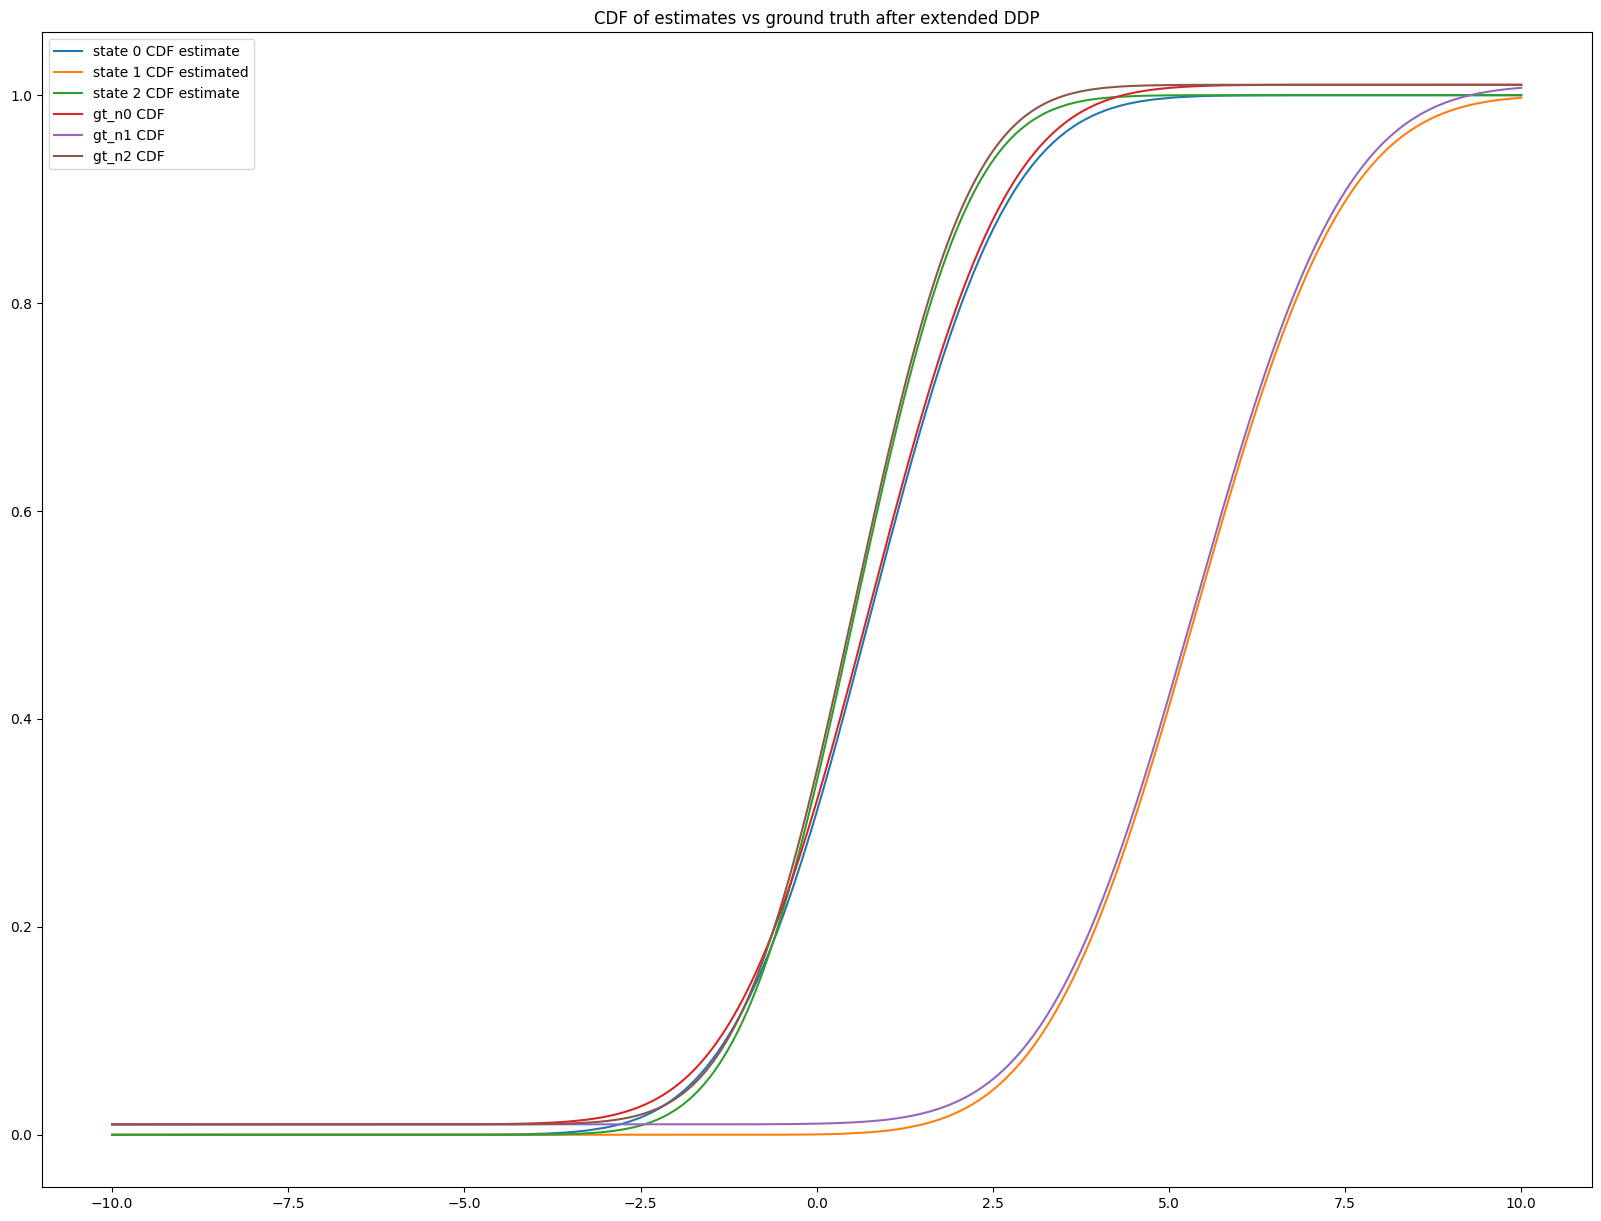

In [52]:
n_est_0 = n_ret_est[n_states[0]]
n_est_1 = n_ret_est[n_states[1]]
n_est_2 = n_ret_est[n_states[2]]


common_support = np.linspace(-10, 10, 1000)

plt.figure(figsize=(20,15))
plt.title("CDF of estimates vs ground truth after extended DDP")
plt.plot(common_support, n_est_0.cdf(common_support), label="state 0 CDF estimate")
plt.plot(common_support, n_est_1.cdf(common_support), label="state 1 CDF estimated")
plt.plot(common_support, n_est_2.cdf(common_support), label="state 2 CDF estimate")

plt.plot(np.linspace(-10,10, 1000), gt_n0.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n0 CDF")
plt.plot(np.linspace(-10,10, 1000), gt_n1.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n1 CDF")
plt.plot(np.linspace(-10,10, 1000), gt_n2.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n2 CDF")
plt.legend()


n_w1_bar = extended_metric(wasserstein_beta, gt_n_ret_distr_fun.distr, n_ret_est.distr)
print(f"Extended 1-Wasserstein Distance: {n_w1_bar}")
print(f"Max Distribution Size: {n_ret_est.get_max_size()}")
print(f"Runtime of extended DDP: {stop-start} seconds")

## Quantile-Quantile-Projection 

$\Pi_{\text{in}} = \Pi_{\Pi_{\text{q}}}$, $\Pi_{\text{out}} = \Pi_{\Pi_{\text{q}}}$ with size functions $M_{\text{in}}(n) \coloneqq n^{2}$, $M_{\text{out}}(n) \coloneqq (1/\gamma)^n$ where $\gamma$ is the discount factor in the MDP (as proposed by Gerstenberg et al in "On Policy Evaluation Algorithms in Distributional Reinforcement Learning")

In [26]:

from src.sample_envs import cyclical_env
from src.sample_envs import cyclical_real_return_distr_fun as gt_n_ret_distr_fun
# param algo spec
poly2 = functools.partial(SizeFun.POLY, 2)
poly1overgamma = functools.partial(SizeFun.EXP, 1/cyclical_env.mdp.gamma)

param_algo_qq_poly2_poly1overgamma = combine_to_param_algo(
    transform_to_param_algo(
        param_algo_from_size_fun,
        size_fun=poly2),
    transform_to_param_algo(
        param_algo_from_size_fun,
        size_fun=poly1overgamma,
        distr_coll=None)
    )

n_ret_est = deepcopy(n_ret_est_cp)
# warmup
for i in range(1,4):
    n_ret_est = ddp(
        cyclical_env.mdp,
        QuantileProjection,
        QuantileProjection,
        param_algo_qq_poly2_poly1overgamma,
        n_ret_est,
        cyclical_env.mdp.rewards,
        i
        )

# resetting return distribution estimate
n_ret_est = deepcopy(n_ret_est_cp)

start = time.time()
for i in range(1, 29):
    n_ret_est = ddp(
        cyclical_env.mdp,
        QuantileProjection,
        QuantileProjection,
        param_algo_qq_poly2_poly1overgamma,
        n_ret_est,
        cyclical_env.mdp.rewards,
        i
        )
    print(f"Iteration {i} of DDP completed.")
stop = time.time()
print(f"Duration: {stop - start}")

Iteration 1 of DDP completed.
Iteration 2 of DDP completed.
Iteration 3 of DDP completed.
Iteration 4 of DDP completed.
Iteration 5 of DDP completed.
Iteration 6 of DDP completed.
Iteration 7 of DDP completed.
Iteration 8 of DDP completed.
Iteration 9 of DDP completed.
Iteration 10 of DDP completed.
Iteration 11 of DDP completed.
Iteration 12 of DDP completed.
Iteration 13 of DDP completed.
Iteration 14 of DDP completed.
Iteration 15 of DDP completed.
Iteration 16 of DDP completed.
Iteration 17 of DDP completed.
Iteration 18 of DDP completed.
Iteration 19 of DDP completed.
Iteration 20 of DDP completed.
Iteration 21 of DDP completed.
Iteration 22 of DDP completed.
Iteration 23 of DDP completed.
Iteration 24 of DDP completed.
Iteration 25 of DDP completed.
Iteration 26 of DDP completed.
Iteration 27 of DDP completed.
Iteration 28 of DDP completed.
Duration: 32.56385803222656


Extended 1-Wasserstein Distance: 0.0008434724354154091
Extended Kolmogorov Smirnov Distance: 0.03737074517019329
Max Distribution Size: 21740
Runtime of extended DDP: 32.56385803222656 seconds


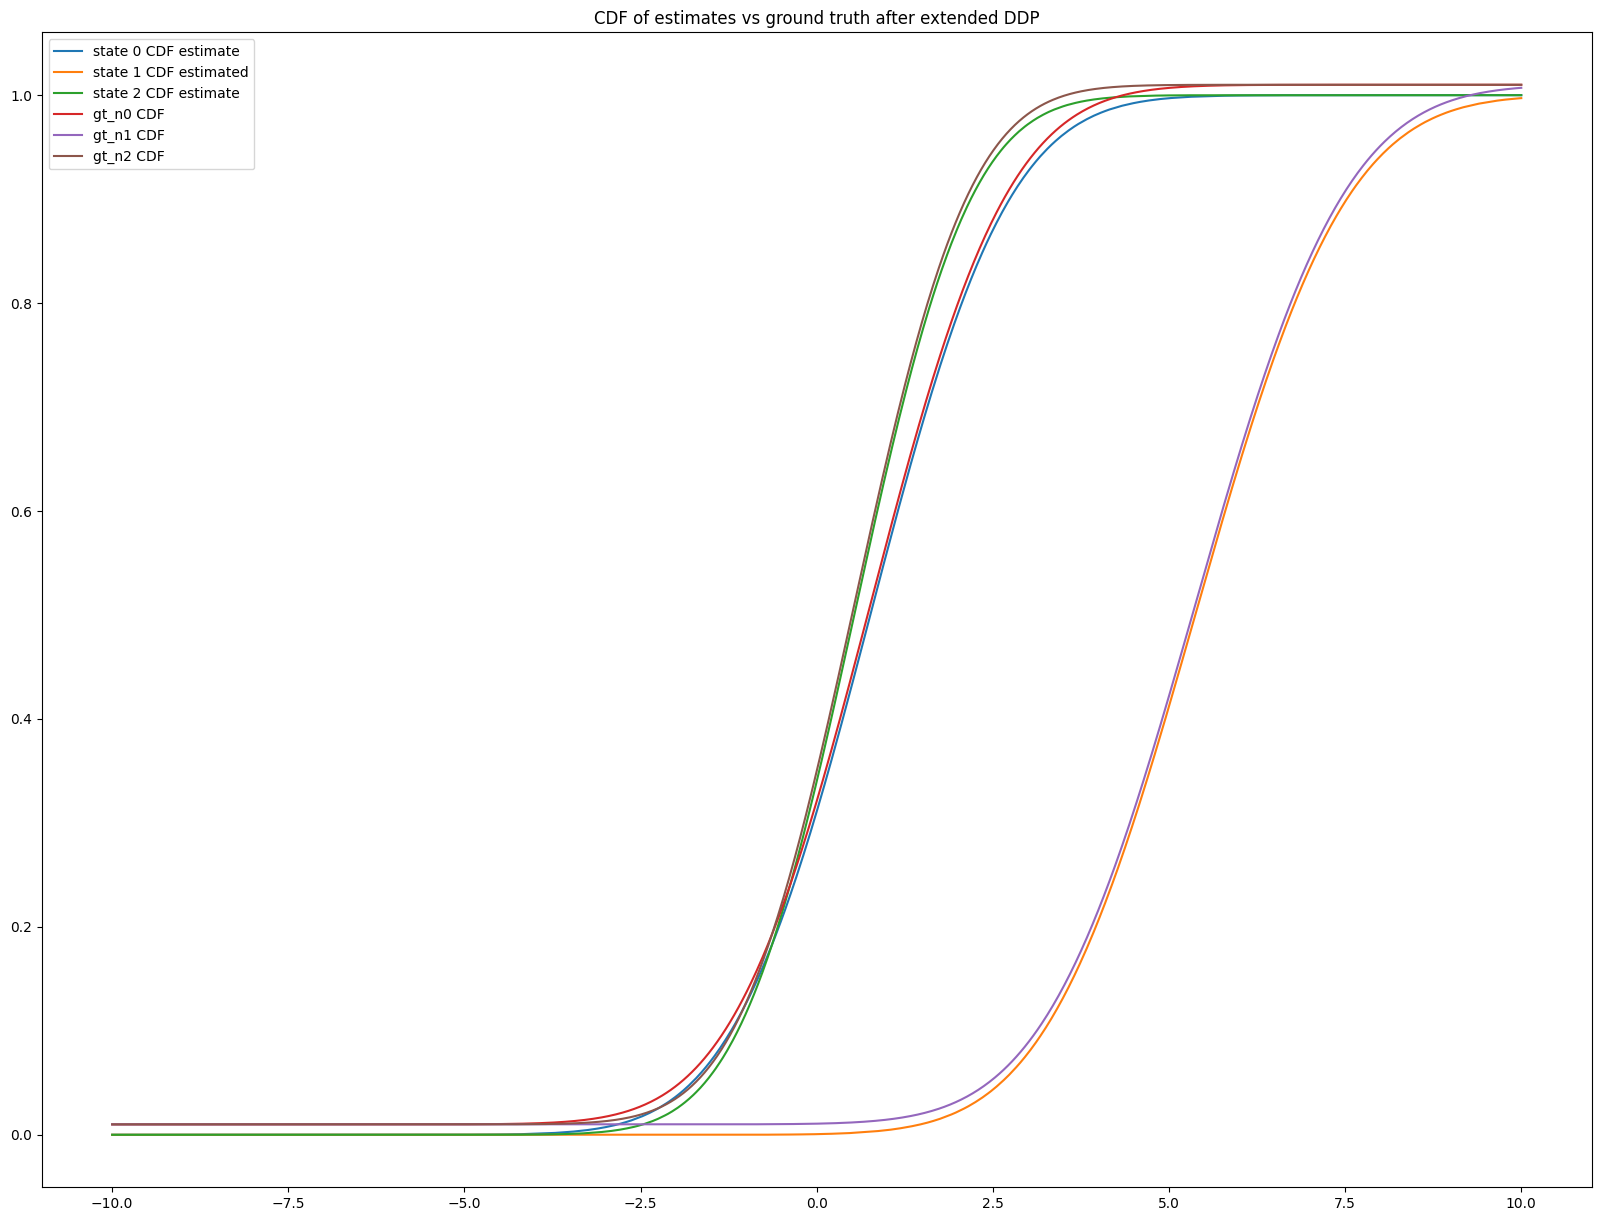

In [28]:

n_est_0 = n_ret_est[n_states[0]]
n_est_1 = n_ret_est[n_states[1]]
n_est_2 = n_ret_est[n_states[2]]


common_support = np.linspace(-10, 10, 1000)

plt.figure(figsize=(20,15))
plt.title("CDF of estimates vs ground truth after extended DDP")
plt.plot(common_support, n_est_0.cdf(common_support), label="state 0 CDF estimate")
plt.plot(common_support, n_est_1.cdf(common_support), label="state 1 CDF estimated")
plt.plot(common_support, n_est_2.cdf(common_support), label="state 2 CDF estimate")

plt.plot(np.linspace(-10,10, 1000), gt_n0.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n0 CDF")
plt.plot(np.linspace(-10,10, 1000), gt_n1.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n1 CDF")
plt.plot(np.linspace(-10,10, 1000), gt_n2.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n2 CDF")
plt.legend()


n_w1_bar = extended_metric(wasserstein_beta, gt_n_ret_distr_fun.distr, n_ret_est.distr)
n_linf_bar = extended_metric(birnb_orl_avg_dist_beta, gt_n_ret_distr_fun.distr, n_ret_est.distr, np.inf)
print(f"Extended 1-Wasserstein Distance: {n_w1_bar}")
print(f"Extended Kolmogorov Smirnov Distance: {n_linf_bar}")
print(f"Max Distribution Size: {n_ret_est.get_max_size()}")
print(f"Runtime of extended DDP: {stop-start} seconds")

## Random-Quantile-Projection

$\Pi_{\text{in}} = \Pi_{\Pi_{\text{rand}}}$, $\Pi_{\text{out}} = \Pi_{\Pi_{\text{q}}}$ with size functions $M_{\text{in}}(n) \coloneqq n^{2}$, $M_{\text{out}}(n) \coloneqq (1/\gamma)^n$ where $\gamma$ is the discount factor in the MDP (as proposed by Gerstenberg et al in "On Policy Evaluation Algorithms in Distributional Reinforcement Learning")

In [32]:
# param algo spec
poly2 = functools.partial(SizeFun.POLY, 2)
exp1overgamma = functools.partial(SizeFun.EXP, 1/cyclical_env.mdp.gamma)

param_algo_rq_exp1overgamma = combine_to_param_algo(
    transform_to_param_algo(
        param_algo_from_size_fun,
        size_fun=poly2),
    transform_to_param_algo(
        param_algo_from_size_fun,
        size_fun=exp1overgamma,
        distr_coll=None)
    )

n_ret_est = deepcopy(n_ret_est_cp)
# warmup
for i in range(1,4):
    n_ret_est = ddp(
        cyclical_env.mdp,
        RandomProjection,
        QuantileProjection,
        param_algo_rq_exp1overgamma,
        n_ret_est,
        cyclical_env.mdp.rewards,
        i
        )

# resetting return distribution estimate
n_ret_est = deepcopy(n_ret_est_cp)

start = time.time()
for i in range(1, 29):
    n_ret_est = ddp(
        cyclical_env.mdp,
        RandomProjection,
        QuantileProjection,
        param_algo_rq_exp1overgamma,
        n_ret_est,
        cyclical_env.mdp.rewards,
        i
        )
    print(f"Iteration {i} of DDP completed.")
stop = time.time()
print(f"Duration: {stop - start}")

Iteration 1 of DDP completed.
Iteration 2 of DDP completed.
Iteration 3 of DDP completed.
Iteration 4 of DDP completed.
Iteration 5 of DDP completed.
Iteration 6 of DDP completed.
Iteration 7 of DDP completed.
Iteration 8 of DDP completed.
Iteration 9 of DDP completed.
Iteration 10 of DDP completed.
Iteration 11 of DDP completed.
Iteration 12 of DDP completed.
Iteration 13 of DDP completed.
Iteration 14 of DDP completed.
Iteration 15 of DDP completed.
Iteration 16 of DDP completed.
Iteration 17 of DDP completed.
Iteration 18 of DDP completed.
Iteration 19 of DDP completed.
Iteration 20 of DDP completed.
Iteration 21 of DDP completed.
Iteration 22 of DDP completed.
Iteration 23 of DDP completed.
Iteration 24 of DDP completed.
Iteration 25 of DDP completed.
Iteration 26 of DDP completed.
Iteration 27 of DDP completed.
Iteration 28 of DDP completed.
Duration: 32.222551107406616


Extended 1-Wasserstein Distance: 0.060102611535253155
Extended Kolmogorov Smirnov Distance: 0.046253909843606
Max Distribution Size: 21740
Runtime of extended DDP: 32.222551107406616 seconds


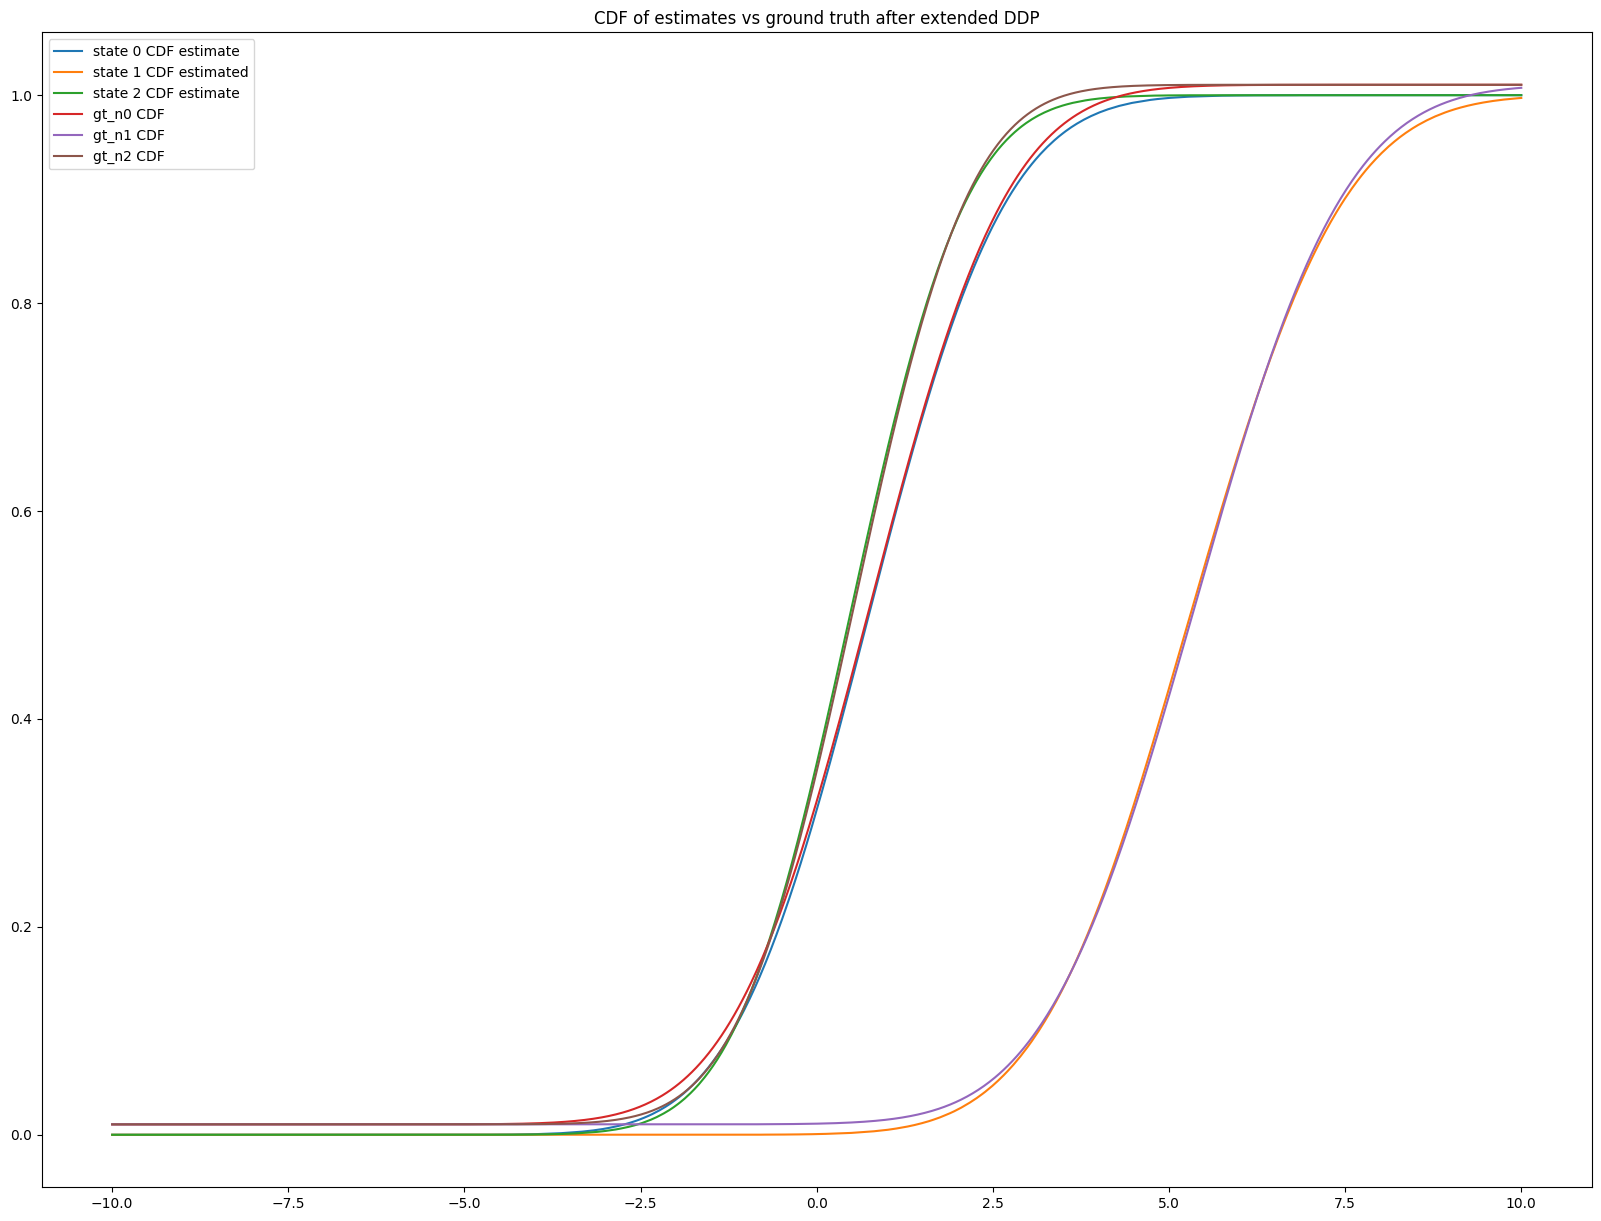

In [34]:
n_est_0 = n_ret_est[n_states[0]]
n_est_1 = n_ret_est[n_states[1]]
n_est_2 = n_ret_est[n_states[2]]


common_support = np.linspace(-10, 10, 1000)

plt.figure(figsize=(20,15))
plt.title("CDF of estimates vs ground truth after extended DDP")
plt.plot(common_support, n_est_0.cdf(common_support), label="state 0 CDF estimate")
plt.plot(common_support, n_est_1.cdf(common_support), label="state 1 CDF estimated")
plt.plot(common_support, n_est_2.cdf(common_support), label="state 2 CDF estimate")

plt.plot(np.linspace(-10,10, 1000), gt_n0.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n0 CDF")
plt.plot(np.linspace(-10,10, 1000), gt_n1.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n1 CDF")
plt.plot(np.linspace(-10,10, 1000), gt_n2.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n2 CDF")
plt.legend()


n_w1_bar = extended_metric(wasserstein_beta, gt_n_ret_distr_fun.distr, n_ret_est.distr)
n_linf_bar = extended_metric(birnb_orl_avg_dist_beta, gt_n_ret_distr_fun.distr, n_ret_est.distr, np.inf)
print(f"Extended 1-Wasserstein Distance: {n_w1_bar}")
print(f"Extended Kolmogorov Smirnov Distance: {n_linf_bar}")
print(f"Max Distribution Size: {n_ret_est.get_max_size()}")
print(f"Runtime of extended DDP: {stop-start} seconds")

## CDF-Quantile-Projection 

$\Pi_{\text{in}} = \Pi_{\Pi_{\text{CDF}}}$, $\Pi_{\text{out}} = \Pi_{\Pi_{\text{q}}}$ with size functions, $M_{\text{out}}(n) \coloneqq n^2$ where $\gamma$ is the discount factor in the MDP (as proposed by Gerstenberg et al in "On Policy Evaluation Algorithms in Distributional Reinforcement Learning")

Furthermore, choose 

In [39]:
# param algo spec
# from src.param_algorithms import param_algo_with_cdf_algo
param_algo_with_cdf_algo = combine_to_param_algo(
    transform_to_param_algo(
        algo_cdf_1,
        f_min=functools.partial(DecayFun.POLY, 2),
        f_max=functools.partial(DecayFun.POLY, 2),
        f_inter=functools.partial(DecayFun.EXP, 3)),  # type: ignore
    transform_to_param_algo(
        param_algo_from_size_fun,
        size_fun=functools.partial(SizeFun.POLY, 2),  # type: ignore
        distr_coll=None)
    )
cyc_mdp_rewards_approx = RewardDistributionCollection(
    cyclical_env.mdp.rewards.index_set,
    distributions=[cyclical_env.mdp.rewards[k].empirical() for k in cyclical_env.mdp.rewards.index_set]
)

n_ret_est = deepcopy(n_ret_est_cp)
# warmup
for i in range(1,4):
    n_ret_est = ddp(
        cyclical_env.mdp,
        GridValueProjection,
        QuantileProjection,
        param_algo_with_cdf_algo,
        n_ret_est,
        cyc_mdp_rewards_approx,
        i
        )

# resetting return distribution estimate
n_ret_est = deepcopy(n_ret_est_cp)

start = time.time()
for i in range(1, 26):
    n_ret_est = ddp(
        cyclical_env.mdp,
        GridValueProjection,
        QuantileProjection,
        param_algo_with_cdf_algo,
        n_ret_est,
        cyc_mdp_rewards_approx,
        i
        )
    print(f"Iteration {i} of DDP completed.")
stop = time.time()
print(f"Duration: {stop - start}")

Iteration 1 of DDP completed.
Iteration 2 of DDP completed.
Iteration 3 of DDP completed.
Iteration 4 of DDP completed.
Iteration 5 of DDP completed.
Iteration 6 of DDP completed.
Iteration 7 of DDP completed.
Iteration 8 of DDP completed.
Iteration 9 of DDP completed.
Iteration 10 of DDP completed.
Iteration 11 of DDP completed.
Iteration 12 of DDP completed.
Iteration 13 of DDP completed.
Iteration 14 of DDP completed.
Iteration 15 of DDP completed.
Iteration 16 of DDP completed.
Iteration 17 of DDP completed.
Iteration 18 of DDP completed.
Iteration 19 of DDP completed.
Iteration 20 of DDP completed.
Iteration 21 of DDP completed.
Iteration 22 of DDP completed.
Iteration 23 of DDP completed.
Iteration 24 of DDP completed.
Iteration 25 of DDP completed.
Duration: 43.69097399711609


Extended 1-Wasserstein Distance: 0.005660142585824697
Extended Kolmogorov Smirnov Distance: 0.07799999999999996
Max Distribution Size: 625
Runtime of extended DDP: 43.69097399711609 seconds


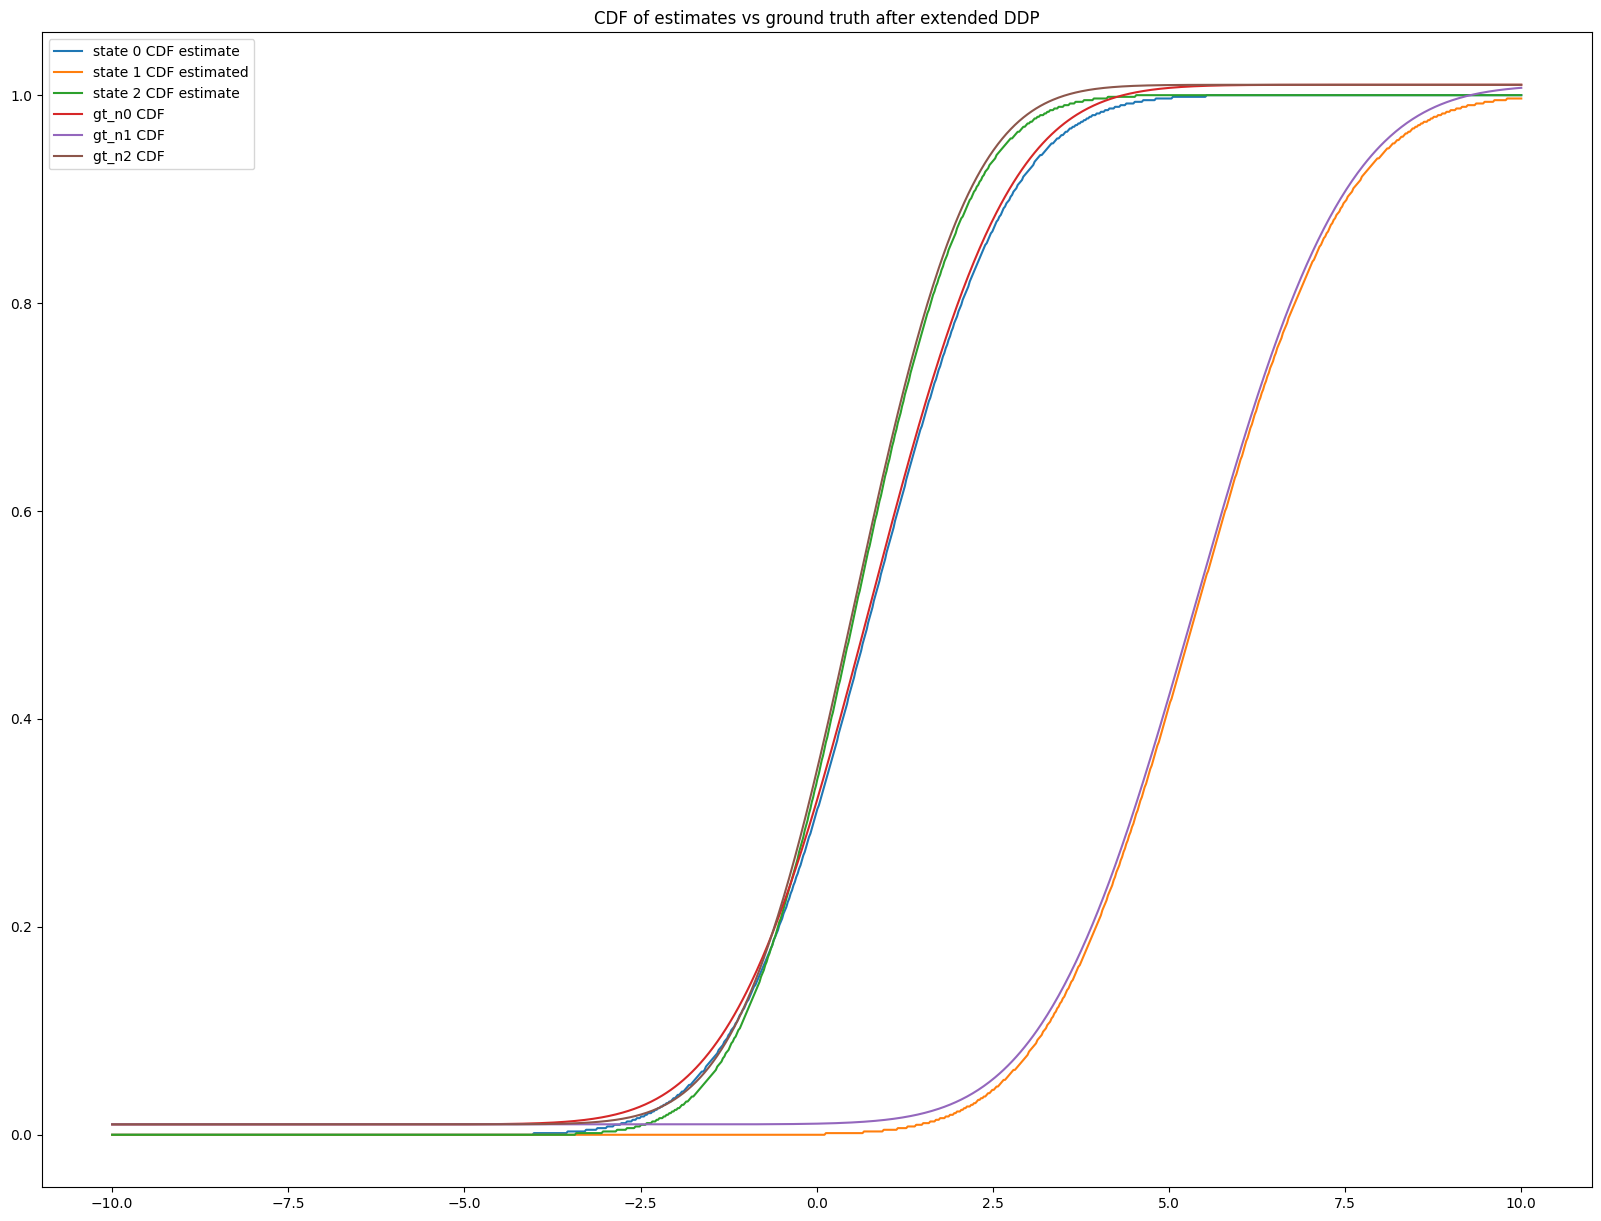

In [42]:
n_est_0 = n_ret_est[n_states[0]]
n_est_1 = n_ret_est[n_states[1]]
n_est_2 = n_ret_est[n_states[2]]


common_support = np.linspace(-10, 10, 1000)

plt.figure(figsize=(20,15))
plt.title("CDF of estimates vs ground truth after extended DDP")
plt.plot(common_support, n_est_0.cdf(common_support), label="state 0 CDF estimate")
plt.plot(common_support, n_est_1.cdf(common_support), label="state 1 CDF estimated")
plt.plot(common_support, n_est_2.cdf(common_support), label="state 2 CDF estimate")

plt.plot(np.linspace(-10,10, 1000), gt_n0.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n0 CDF")
plt.plot(np.linspace(-10,10, 1000), gt_n1.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n1 CDF")
plt.plot(np.linspace(-10,10, 1000), gt_n2.cdf(np.linspace(-10,10,1000))+0.01, label="gt_n2 CDF")
plt.legend()


n_w1_bar = extended_metric(wasserstein_beta, gt_n_ret_distr_fun.distr, n_ret_est.distr)
n_linf_bar = extended_metric(birnb_orl_avg_dist_beta, gt_n_ret_distr_fun.distr, n_ret_est.distr, np.inf)
print(f"Extended 1-Wasserstein Distance: {n_w1_bar}")
print(f"Extended Kolmogorov Smirnov Distance: {n_linf_bar}")
print(f"Max Distribution Size: {n_ret_est.get_max_size()}")
print(f"Runtime of extended DDP: {stop-start} seconds")